# Tạo máy ảo bằng Google Colab

## Kill kernel cũ đi đồng thời tạo kết nối mới

In [68]:
# use this for the first running 
!kill -9 -1 
# linux command to see available folders
!ls

# Phân tích cảm xúc với LSTMs

Trong assignment này, chúng ta sẽ dùng mạng LSTM để giải quyết bài toán phân tích cảm xúc (Sentiment Analysis) trên tập dữ liệu văn bản. Nếu nhìn theo kiểu black box, đầu vào của bài toán là một câu hoặc đoạn văn bản và đầu ra là trạng thái tích cực, tiêu cực hay trung hoà (positive - negative - neutral). Trong phạm vi của assignment này, chúng ta chỉ quan tâm đến hai trạng thái cảm xúc là positive và negative.

![caption](Images/input_output.png)

# Góc nhìn Word Vectors

Nếu như chúng ta giữ nguyên định dạng đầu vào là chuỗi ký tự thì rất khó để thực hiện các thao tác biến đổi như tích vô hướng (dot product) hoặc các thuật toán trên mạng neural network như backpropagation. Thay vì dữ liệu đầu vào là một chuỗi, chúng ta cần chuyển đổi các từ trong tập từ điển sang dạng vector số học trong đó có thể thực hiện được các phép toán nêu trên.

![caption](Images/word2vec.png)

Trong hình minh hoạ ở trên, ta có thể hình dung dữ liệu đầu vào của thuật toán phân tích cảm xúc là một ma trận 16 x D chiều. Trong đó 16 là số lượng từ trong câu và D là số chiều của không gian vector để biểu diễn từ. Để ánh xạ từ một từ sang một vector, chúng ta sử dụng ma trận word embedding như đã thực hiện trong bài Lab 2.

## Tập dữ liệu

Trong assignment này, chúng tôi sử dụng tập dữ liệu review trên trang Foody với khoảng 30,000 mẫu được gán nhãn. Trong đó có 15,000 mẫu positive và 15,000 mẫu negative. Nguồn: https://streetcodevn.com/blog/dataset. Tập dữ liệu này đã được đính kèm trong thư mục của assignment 3.

## Các bước để huấn luyện trên mạng RNN

Có 5 bước chính để giải quyết bài toán phân tích cảm xúc trong văn bản:

    1) Huấn luyện một mô hình phát sinh ra vector từ (như mô hình Word2Vec) hoặc tải lên các vector từ tiền huấn luyện.
    2) Tạo ma trận ID cho tập dữ liệu huấn luyện
    3) Tạo mô hình RNN với các đơn vị LSTM, sử dụng tensorflow
    4) Huấn luyện mô hình RNN với dữ liệu ma trận đã tạo ở bước 2
    5) Đánh giá mô hình đã huấn luyện với tập test

# 1. Load tập từ vựng và ma trận word embedding

Đầu tiên, để có thể biến đổi một từ thành một vector, chúng ta sử dụng mô hình đã được huấn luyện trước đó (pretrained model). Mô hình đã train trước đó cho tiếng Việt được lấy ở đây: https://s3-us-west-1.amazonaws.com/fasttext-vectors/word-vectors-v2/cc.vi.300.vec.gz

Tuy nhiên, số lượng từ vựng tiếng Việt được huấn luyện rất lớn, khoảng 2M từ. Mỗi từ được biểu diễn dưới dạng một vector 300 chiều. Với kích thước gốc của ma trận word embedding như vậy sẽ gây khó khăn cho việc load dữ liệu cũng như đưa vào thư viện tensorflow để huấn luyện nên chúng tôi đã tối giản lại với số lượng từ tối thiểu để có thể chạy được trên tập dữ liệu review về đồ ăn của Foody.


In [69]:
import numpy as np
import os
parent_dir = 'D:\Run'
print(os.listdir(parent_dir))

wordsList = np.load(os.path.join(parent_dir, 'wordsList.npy'))
print('Simplified vocabulary loaded!')
wordsList = wordsList.tolist()
#wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load(os.path.join(parent_dir, 'wordVectors.npy'))
wordVectors = np.float32(wordVectors)
print ('Word embedding matrix loaded!')

['.ipynb_checkpoints', 'Assignment3-SentimentAnalysis-with-LSTM.rar', 'assignment3.ipynb', 'data_train', 'data_train.zip', 'idsMatrix.npy', 'Images', 'models', 'wordsList.npy', 'wordVectors.npy', '_DS_Store']
Simplified vocabulary loaded!
Word embedding matrix loaded!


Để chắc chắn mọi dữ liệu được load lên một cách chính xác, chúng ta cần kiểm tra xem số lượng từ trong từ điển rút gọn và số chiều của ma trận word embedding có khớp với nhau hay không? Trong trường hợp này số từ mà chúng tôi giữ lại là 19,899 và số chiều trong không gian biểu diễn là 300 chiều.

In [70]:
print('Size of the vocabulary: ', len(wordsList))
print('Size of the word embedding matrix: ', wordVectors.shape)

Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


## Word2Vec trên một từ đơn

Để có thể xác định được vector biểu diễn của một từ tiếng Việt. Đầu tiên chúng ta sẽ xác định xem vị trí của từ đó trong wordsList. Sau đó lấy vector ở dòng tương ứng trên trên ma trận wordVectors. 

In [71]:
ngon_idx = wordsList.index('ngon')
print('Index of `ngon` in wordsList: ', ngon_idx)
ngon_vec = wordVectors[ngon_idx]
print('Vector representation of `ngon` is: ', ngon_vec)

Index of `ngon` in wordsList:  14598
Vector representation of `ngon` is:  [-2.040e-02 -9.800e-03  2.290e-01 -3.770e-02  5.430e-02 -2.680e-02
  2.190e-02 -6.290e-02 -2.200e-02 -1.010e-02  8.300e-03 -8.810e-02
 -3.630e-02  7.820e-02 -7.780e-02 -4.930e-02 -6.600e-03 -1.026e-01
 -1.040e-02  5.380e-02  4.100e-02  6.530e-02 -2.770e-02 -6.340e-02
  2.270e-02  4.420e-02  3.340e-02 -4.960e-02  8.290e-02 -3.990e-02
  3.750e-02  1.800e-02 -1.115e-01 -7.200e-02 -5.060e-02 -1.051e-01
 -4.560e-02 -1.765e-01 -3.300e-02 -6.800e-03  5.580e-02 -4.180e-02
  4.380e-02  4.940e-02  7.400e-03  4.020e-02 -8.850e-02 -9.840e-02
 -5.210e-02 -5.500e-03  3.730e-02 -8.460e-02 -6.910e-02 -4.980e-02
 -3.910e-02 -4.980e-02 -8.690e-02  6.100e-03 -5.360e-02 -3.800e-03
  1.162e-01 -4.160e-02  5.000e-03 -7.240e-02 -3.320e-02  1.800e-02
  1.200e-02 -4.420e-02  1.350e-01  6.580e-02 -1.110e-02  1.960e-02
  1.750e-02  2.010e-02  2.200e-03  1.810e-01 -6.610e-02 -6.860e-02
 -4.690e-02  7.890e-02  6.880e-02 -5.320e-02  2.770e-02

### ToDo 3.1: Word2Vec để biểu diễn một đoạn văn bản

Nâng cấp hơn so với phiên bản Word2Vec cho từ đơn, phần này chúng ta sẽ biểu diễn một câu dưới dạng một ma trận gồm các vector biểu diễn của từng từ chồng lên nhau.

Ví dụ như chúng ta muốn biểu diễn câu "Món này ăn hoài không biết chán". Đầu tiên, với mỗi từ trong câu ta sẽ tìm chỉ số tương ứng trong từ điển và lưu vào vector đặt tên là 'sentenceIndexes'. Sau đó, chúng ta có thể sử dụng hàm tra cứu ma trận word embedding của thư viện Tensorflow tf.nn.embedding_lookup để tra các vector tại các chỉ số trong 'sentenceIndexes'. Như vậy nếu chúng ta sử dụng tối đa 10 từ để lưu trữ cho một câu thì ma trận biểu diễn cho câu sẽ là một ma trận kích thước 10 x 300.

![caption](Images/embedding.png)

In [72]:
import tensorflow as tf
maxSeqLength = 10   #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
sentenceIndexes = np.zeros((maxSeqLength), dtype='int32')

# TODO 3.1: Gán chỉ số của các từ trong câu và 'sentenceIndexes'
items=[x for x in ("món này ăn hoài không biết chán").split(' ')]
for i in range(len(items)):
    sentenceIndexes[i]=wordsList.index(items[i])
# Các chỉ số 7, 8, 9 của sentenceIndexes  vẫn được gán bằng 0 như cũ
print('Row index for each word: ', sentenceIndexes)

# Ma trận biểu diễn:
print('Sentence representation of word vectors:')
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,sentenceIndexes).eval().shape)

(10,)
Row index for each word:  [  119  8136  4884 18791 16614 15951  3371     0     0     0]
Sentence representation of word vectors:
(10, 300)


Nếu như thực hiện đúng thì vector 'sentenceIndexes' sẽ có giá trị là: [119, 8136, 4884, 18791, 16614, 15951, 3371, 0, 0, 0]

# 2. Khảo sát tập dữ liệu huấn luyện và tạo ma trận ID

Trong assignment 3, chúng tôi sử dụng tập dữ liệu lấy từ trang web Foody trên miền dữ liệu liên quan đến ẩm thực. Tập dữ liệu bao gôm 15.000 review tích cực đặt trong thư mục 'positiveReviews' và 15.000 review tiêu cực đặt trong thư mục 'negativeReviews'. Do khối lượng dữ liệu lớn, nếu chúng ta chọn số lượng từ tối đa (maxSeqLength) quá cao thì sẽ bị lãng phí khi biểu diễn ở những câu review quá ngắn. Ngược lại, nếu sử dụng số lượng từ tối đa quá ít thì sẽ bị bỏ lỡ những từ quan trọng giúp cho việc phân tích cảm xúc.



In [73]:
from os import listdir
from os.path import isfile, join



data_dir = parent_dir+"/data_train/train"
positive_dir = data_dir+"/pos/"
negative_dir = data_dir+"/neg/"

positiveFiles = [positive_dir + f for f in listdir(positive_dir) if isfile(join(positive_dir, f))]
negativeFiles = [negative_dir + f for f in listdir(negative_dir) if isfile(join(negative_dir, f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

counter= 122
counter= 60
counter= 20
counter= 67
counter= 51
counter= 64
counter= 105
counter= 103
counter= 44
counter= 24
counter= 20
counter= 114
counter= 15
counter= 51
counter= 25
counter= 35
counter= 38
counter= 21
counter= 124
counter= 145
counter= 30
counter= 32
counter= 49
counter= 45
counter= 53
counter= 98
counter= 117
counter= 110
counter= 102
counter= 67
counter= 46
counter= 62
counter= 63
counter= 10
counter= 67
counter= 30
counter= 134
counter= 78
counter= 151
counter= 10
counter= 105
counter= 80
counter= 140
counter= 35
counter= 16
counter= 46
counter= 51
counter= 181
counter= 35
counter= 27
counter= 72
counter= 135
counter= 22
counter= 15
counter= 22
counter= 45
counter= 28
counter= 22
counter= 82
counter= 112
counter= 23
counter= 67
counter= 126
counter= 55
counter= 29
counter= 33
counter= 15
counter= 111
counter= 58
counter= 21
counter= 88
counter= 102
counter= 35
counter= 127
counter= 41
counter= 40
counter= 29
counter= 292
counter= 23
counter= 143
counter= 82
counte

counter= 63
counter= 5
counter= 25
counter= 61
counter= 34
counter= 72
counter= 34
counter= 34
counter= 53
counter= 117
counter= 8
counter= 41
counter= 16
counter= 59
counter= 25
counter= 13
counter= 48
counter= 19
counter= 64
counter= 45
counter= 47
counter= 108
counter= 61
counter= 12
counter= 7
counter= 123
counter= 106
counter= 61
counter= 15
counter= 102
counter= 31
counter= 41
counter= 48
counter= 23
counter= 36
counter= 31
counter= 18
counter= 62
counter= 34
counter= 146
counter= 117
counter= 92
counter= 121
counter= 90
counter= 104
counter= 12
counter= 12
counter= 24
counter= 15
counter= 39
counter= 1
counter= 76
counter= 97
counter= 40
counter= 17
counter= 20
counter= 247
counter= 50
counter= 44
counter= 35
counter= 162
counter= 147
counter= 48
counter= 49
counter= 72
counter= 73
counter= 6
counter= 26
counter= 72
counter= 49
counter= 96
counter= 14
counter= 29
counter= 32
counter= 23
counter= 57
counter= 30
counter= 11
counter= 92
counter= 196
counter= 96
counter= 13
counter=

counter= 110
counter= 19
counter= 28
counter= 56
counter= 13
counter= 20
counter= 64
counter= 65
counter= 120
counter= 28
counter= 21
counter= 88
counter= 25
counter= 102
counter= 31
counter= 23
counter= 18
counter= 139
counter= 19
counter= 185
counter= 23
counter= 24
counter= 60
counter= 33
counter= 64
counter= 49
counter= 64
counter= 33
counter= 58
counter= 30
counter= 22
counter= 44
counter= 186
counter= 13
counter= 81
counter= 29
counter= 64
counter= 7
counter= 53
counter= 29
counter= 45
counter= 68
counter= 97
counter= 23
counter= 16
counter= 13
counter= 45
counter= 13
counter= 138
counter= 41
counter= 16
counter= 16
counter= 44
counter= 47
counter= 25
counter= 54
counter= 48
counter= 91
counter= 48
counter= 52
counter= 24
counter= 22
counter= 32
counter= 126
counter= 45
counter= 32
counter= 30
counter= 34
counter= 15
counter= 16
counter= 22
counter= 114
counter= 29
counter= 80
counter= 32
counter= 5
counter= 32
counter= 27
counter= 91
counter= 15
counter= 17
counter= 48
counter= 

counter= 27
counter= 46
counter= 31
counter= 76
counter= 77
counter= 96
counter= 109
counter= 102
counter= 79
counter= 28
counter= 104
counter= 103
counter= 44
counter= 87
counter= 39
counter= 116
counter= 157
counter= 4
counter= 37
counter= 19
counter= 5
counter= 32
counter= 89
counter= 53
counter= 45
counter= 14
counter= 149
counter= 96
counter= 21
counter= 31
counter= 30
counter= 22
counter= 48
counter= 44
counter= 121
counter= 42
counter= 46
counter= 13
counter= 11
counter= 14
counter= 42
counter= 13
counter= 252
counter= 58
counter= 31
counter= 43
counter= 14
counter= 22
counter= 5
counter= 39
counter= 102
counter= 20
counter= 81
counter= 77
counter= 65
counter= 138
counter= 26
counter= 16
counter= 7
counter= 83
counter= 15
counter= 99
counter= 248
counter= 8
counter= 77
counter= 21
counter= 51
counter= 42
counter= 46
counter= 108
counter= 13
counter= 121
counter= 31
counter= 38
counter= 52
counter= 70
counter= 73
counter= 52
counter= 59
counter= 45
counter= 119
counter= 23
counte

counter= 20
counter= 59
counter= 15
counter= 49
counter= 21
counter= 37
counter= 72
counter= 23
counter= 80
counter= 62
counter= 15
counter= 44
counter= 30
counter= 49
counter= 96
counter= 27
counter= 48
counter= 38
counter= 5
counter= 59
counter= 16
counter= 32
counter= 60
counter= 81
counter= 39
counter= 28
counter= 83
counter= 19
counter= 165
counter= 42
counter= 20
counter= 17
counter= 15
counter= 26
counter= 39
counter= 15
counter= 32
counter= 132
counter= 49
counter= 20
counter= 105
counter= 13
counter= 30
counter= 40
counter= 52
counter= 73
counter= 176
counter= 9
counter= 131
counter= 49
counter= 105
counter= 89
counter= 15
counter= 29
counter= 20
counter= 27
counter= 8
counter= 17
counter= 7
counter= 53
counter= 89
counter= 21
counter= 29
counter= 56
counter= 137
counter= 28
counter= 32
counter= 10
counter= 78
counter= 30
counter= 53
counter= 41
counter= 64
counter= 20
counter= 72
counter= 21
counter= 50
counter= 27
counter= 34
counter= 139
counter= 55
counter= 61
counter= 46


counter= 135
counter= 35
counter= 32
counter= 49
counter= 40
counter= 215
counter= 21
counter= 42
counter= 51
counter= 80
counter= 92
counter= 54
counter= 88
counter= 47
counter= 54
counter= 19
counter= 141
counter= 21
counter= 188
counter= 17
counter= 14
counter= 15
counter= 39
counter= 102
counter= 125
counter= 15
counter= 40
counter= 31
counter= 76
counter= 13
counter= 39
counter= 86
counter= 9
counter= 29
counter= 69
counter= 51
counter= 27
counter= 45
counter= 129
counter= 35
counter= 130
counter= 14
counter= 38
counter= 95
counter= 44
counter= 14
counter= 42
counter= 52
counter= 30
counter= 53
counter= 14
counter= 32
counter= 24
counter= 127
counter= 86
counter= 32
counter= 44
counter= 6
counter= 53
counter= 33
counter= 36
counter= 12
counter= 33
counter= 47
counter= 117
counter= 154
counter= 38
counter= 10
counter= 15
counter= 55
counter= 22
counter= 42
counter= 31
counter= 29
counter= 3
counter= 104
counter= 74
counter= 87
counter= 35
counter= 17
counter= 107
counter= 109
count

counter= 57
counter= 19
counter= 10
counter= 61
counter= 31
counter= 146
counter= 50
counter= 116
counter= 42
counter= 24
counter= 10
counter= 27
counter= 22
counter= 6
counter= 79
counter= 10
counter= 28
counter= 83
counter= 13
counter= 21
counter= 36
counter= 106
counter= 107
counter= 16
counter= 104
counter= 44
counter= 113
counter= 30
counter= 111
counter= 40
counter= 90
counter= 213
counter= 237
counter= 17
counter= 31
counter= 36
counter= 144
counter= 13
counter= 139
counter= 8
counter= 37
counter= 168
counter= 65
counter= 17
counter= 32
counter= 45
counter= 27
counter= 14
counter= 31
counter= 126
counter= 37
counter= 74
counter= 27
counter= 43
counter= 38
counter= 52
counter= 89
counter= 55
counter= 141
counter= 13
counter= 7
counter= 17
counter= 89
counter= 46
counter= 8
counter= 47
counter= 38
counter= 240
counter= 52
counter= 47
counter= 16
counter= 69
counter= 24
counter= 94
counter= 21
counter= 50
counter= 47
counter= 40
counter= 91
counter= 86
counter= 26
counter= 119
coun

counter= 9
counter= 49
counter= 24
counter= 34
counter= 53
counter= 11
counter= 19
counter= 70
counter= 24
counter= 35
counter= 37
counter= 20
counter= 57
counter= 58
counter= 95
counter= 79
counter= 56
counter= 62
counter= 49
counter= 90
counter= 151
counter= 150
counter= 119
counter= 93
counter= 78
counter= 47
counter= 22
counter= 12
counter= 94
counter= 28
counter= 31
counter= 81
counter= 70
counter= 36
counter= 31
counter= 25
counter= 32
counter= 115
counter= 57
counter= 59
counter= 57
counter= 71
counter= 63
counter= 27
counter= 45
counter= 95
counter= 105
counter= 34
counter= 13
counter= 16
counter= 29
counter= 87
counter= 24
counter= 53
counter= 28
counter= 40
counter= 9
counter= 12
counter= 10
counter= 163
counter= 18
counter= 88
counter= 131
counter= 77
counter= 159
counter= 17
counter= 9
counter= 95
counter= 20
counter= 101
counter= 144
counter= 147
counter= 161
counter= 91
counter= 29
counter= 89
counter= 47
counter= 42
counter= 126
counter= 79
counter= 27
counter= 17
counte

counter= 144
counter= 90
counter= 75
counter= 55
counter= 25
counter= 48
counter= 112
counter= 27
counter= 24
counter= 47
counter= 80
counter= 45
counter= 49
counter= 42
counter= 217
counter= 16
counter= 51
counter= 77
counter= 6
counter= 36
counter= 69
counter= 41
counter= 57
counter= 14
counter= 68
counter= 12
counter= 58
counter= 56
counter= 16
counter= 52
counter= 43
counter= 81
counter= 26
counter= 40
counter= 17
counter= 110
counter= 23
counter= 43
counter= 53
counter= 38
counter= 89
counter= 14
counter= 108
counter= 30
counter= 119
counter= 66
counter= 36
counter= 19
counter= 90
counter= 99
counter= 290
counter= 74
counter= 114
counter= 41
counter= 53
counter= 28
counter= 24
counter= 74
counter= 28
counter= 107
counter= 42
counter= 6
counter= 22
counter= 13
counter= 29
counter= 77
counter= 33
counter= 93
counter= 11
counter= 20
counter= 11
counter= 40
counter= 15
counter= 31
counter= 15
counter= 62
counter= 267
counter= 50
counter= 59
counter= 53
counter= 98
counter= 32
counter=

counter= 17
counter= 4
counter= 72
counter= 68
counter= 11
counter= 98
counter= 81
counter= 89
counter= 28
counter= 13
counter= 43
counter= 140
counter= 23
counter= 24
counter= 33
counter= 86
counter= 72
counter= 54
counter= 22
counter= 40
counter= 62
counter= 71
counter= 76
counter= 28
counter= 68
counter= 42
counter= 66
counter= 31
counter= 33
counter= 59
counter= 34
counter= 30
counter= 38
counter= 143
counter= 59
counter= 20
counter= 198
counter= 104
counter= 39
counter= 29
counter= 13
counter= 21
counter= 86
counter= 38
counter= 55
counter= 21
counter= 46
counter= 39
counter= 31
counter= 38
counter= 35
counter= 122
counter= 8
counter= 258
counter= 24
counter= 31
counter= 32
counter= 50
counter= 37
counter= 72
counter= 35
counter= 12
counter= 17
counter= 55
counter= 1
counter= 16
counter= 31
counter= 137
counter= 103
counter= 136
counter= 198
counter= 49
counter= 19
counter= 50
counter= 41
counter= 39
counter= 58
counter= 28
counter= 91
counter= 51
counter= 77
counter= 11
counter= 

counter= 29
counter= 68
counter= 26
counter= 35
counter= 12
counter= 81
counter= 36
counter= 54
counter= 82
counter= 69
counter= 22
counter= 75
counter= 90
counter= 46
counter= 79
counter= 77
counter= 59
counter= 47
counter= 52
counter= 4
counter= 15
counter= 19
counter= 15
counter= 66
counter= 90
counter= 29
counter= 98
counter= 50
counter= 39
counter= 31
counter= 91
counter= 48
counter= 139
counter= 17
counter= 18
counter= 104
counter= 25
counter= 87
counter= 59
counter= 40
counter= 15
counter= 32
counter= 33
counter= 70
counter= 72
counter= 13
counter= 163
counter= 6
counter= 22
counter= 97
counter= 54
counter= 40
counter= 137
counter= 7
counter= 81
counter= 21
counter= 34
counter= 55
counter= 67
counter= 86
counter= 23
counter= 73
counter= 44
counter= 20
counter= 27
counter= 65
counter= 25
counter= 10
counter= 19
counter= 23
counter= 13
counter= 34
counter= 30
counter= 43
counter= 84
counter= 32
counter= 21
counter= 92
counter= 14
counter= 40
counter= 38
counter= 70
counter= 76
cou

counter= 19
counter= 198
counter= 32
counter= 194
counter= 35
counter= 87
counter= 65
counter= 21
counter= 20
counter= 49
counter= 80
counter= 62
counter= 14
counter= 84
counter= 56
counter= 46
counter= 20
counter= 6
counter= 37
counter= 129
counter= 15
counter= 91
counter= 52
counter= 63
counter= 53
counter= 105
counter= 108
counter= 13
counter= 115
counter= 83
counter= 42
counter= 60
counter= 80
counter= 71
counter= 14
counter= 36
counter= 40
counter= 125
counter= 40
counter= 62
counter= 57
counter= 145
counter= 29
counter= 50
counter= 181
counter= 21
counter= 41
counter= 32
counter= 8
counter= 195
counter= 33
counter= 14
counter= 65
counter= 78
counter= 67
counter= 46
counter= 16
counter= 22
counter= 22
counter= 176
counter= 7
counter= 19
counter= 21
counter= 36
counter= 149
counter= 49
counter= 117
counter= 45
counter= 40
counter= 180
counter= 237
counter= 34
counter= 82
counter= 26
counter= 67
counter= 30
counter= 142
counter= 98
counter= 7
counter= 53
counter= 70
counter= 111
cou

counter= 40
counter= 45
counter= 46
counter= 27
counter= 55
counter= 25
counter= 80
counter= 95
counter= 40
counter= 128
counter= 9
counter= 11
counter= 35
counter= 14
counter= 46
counter= 33
counter= 93
counter= 3
counter= 11
counter= 78
counter= 22
counter= 25
counter= 19
counter= 46
counter= 10
counter= 16
counter= 3
counter= 69
counter= 39
counter= 30
counter= 29
counter= 12
counter= 25
counter= 79
counter= 119
counter= 26
counter= 28
counter= 56
counter= 67
counter= 30
counter= 33
counter= 36
counter= 14
counter= 60
counter= 40
counter= 24
counter= 37
counter= 13
counter= 29
counter= 149
counter= 21
counter= 40
counter= 120
counter= 21
counter= 129
counter= 69
counter= 69
counter= 49
counter= 44
counter= 20
counter= 28
counter= 96
counter= 205
counter= 60
counter= 149
counter= 144
counter= 50
counter= 92
counter= 12
counter= 43
counter= 89
counter= 39
counter= 14
counter= 26
counter= 21
counter= 18
counter= 21
counter= 66
counter= 122
counter= 88
counter= 60
counter= 10
counter= 2

counter= 23
counter= 4
counter= 74
counter= 40
counter= 32
counter= 21
counter= 36
counter= 32
counter= 19
counter= 43
counter= 54
counter= 113
counter= 97
counter= 36
counter= 31
counter= 66
counter= 24
counter= 70
counter= 31
counter= 38
counter= 18
counter= 43
counter= 8
counter= 89
counter= 10
counter= 27
counter= 24
counter= 31
counter= 11
counter= 9
counter= 41
counter= 26
counter= 39
counter= 24
counter= 124
counter= 51
counter= 33
counter= 91
counter= 41
counter= 59
counter= 21
counter= 16
counter= 36
counter= 13
counter= 7
counter= 121
counter= 76
counter= 38
counter= 216
counter= 50
counter= 46
counter= 10
counter= 106
counter= 28
counter= 45
counter= 112
counter= 36
counter= 34
counter= 100
counter= 61
counter= 12
counter= 54
counter= 73
counter= 19
counter= 13
counter= 10
counter= 4
counter= 34
counter= 159
counter= 236
counter= 28
counter= 6
counter= 26
counter= 36
counter= 3
counter= 17
counter= 107
counter= 21
counter= 91
counter= 38
counter= 70
counter= 77
counter= 58
c

counter= 290
counter= 32
counter= 33
counter= 10
counter= 500
counter= 15
counter= 18
counter= 87
counter= 34
counter= 89
counter= 197
counter= 75
counter= 55
counter= 51
counter= 36
counter= 130
counter= 33
counter= 16
counter= 16
counter= 47
counter= 11
counter= 67
counter= 22
counter= 17
counter= 69
counter= 38
counter= 42
counter= 21
counter= 34
counter= 87
counter= 226
counter= 35
counter= 18
counter= 18
counter= 25
counter= 105
counter= 13
counter= 77
counter= 26
counter= 51
counter= 25
counter= 111
counter= 22
counter= 17
counter= 15
counter= 111
counter= 41
counter= 38
counter= 16
counter= 170
counter= 6
counter= 18
counter= 22
counter= 22
counter= 57
counter= 20
counter= 16
counter= 32
counter= 15
counter= 127
counter= 45
counter= 9
counter= 72
counter= 15
counter= 10
counter= 89
counter= 8
counter= 41
counter= 38
counter= 37
counter= 46
counter= 45
counter= 4
counter= 21
counter= 27
counter= 17
counter= 179
counter= 20
counter= 30
counter= 156
counter= 13
counter= 68
counter=

counter= 143
counter= 62
counter= 27
counter= 16
counter= 43
counter= 6
counter= 32
counter= 59
counter= 66
counter= 34
counter= 36
counter= 44
counter= 45
counter= 16
counter= 31
counter= 81
counter= 23
counter= 23
counter= 5
counter= 39
counter= 43
counter= 62
counter= 15
counter= 38
counter= 12
counter= 26
counter= 75
counter= 29
counter= 90
counter= 15
counter= 28
counter= 35
counter= 70
counter= 16
counter= 314
counter= 55
counter= 28
counter= 48
counter= 48
counter= 46
counter= 15
counter= 38
counter= 32
counter= 23
counter= 28
counter= 38
counter= 41
counter= 24
counter= 38
counter= 24
counter= 30
counter= 9
counter= 23
counter= 21
counter= 31
counter= 37
counter= 17
counter= 47
counter= 61
counter= 29
counter= 18
counter= 76
counter= 29
counter= 11
counter= 30
counter= 31
counter= 49
counter= 45
counter= 9
counter= 90
counter= 64
counter= 82
counter= 38
counter= 21
counter= 12
counter= 7
counter= 8
counter= 72
counter= 12
counter= 66
counter= 22
counter= 81
counter= 28
counter=

counter= 55
counter= 7
counter= 85
counter= 73
counter= 277
counter= 36
counter= 15
counter= 48
counter= 70
counter= 44
counter= 27
counter= 6
counter= 123
counter= 23
counter= 137
counter= 153
counter= 30
counter= 126
counter= 28
counter= 101
counter= 80
counter= 139
counter= 52
counter= 29
counter= 51
counter= 77
counter= 110
counter= 11
counter= 182
counter= 81
counter= 11
counter= 23
counter= 42
counter= 119
counter= 7
counter= 56
counter= 52
counter= 19
counter= 96
counter= 23
counter= 60
counter= 10
counter= 46
counter= 39
counter= 44
counter= 27
counter= 50
counter= 105
counter= 23
counter= 75
counter= 68
counter= 111
counter= 31
counter= 25
counter= 17
counter= 62
counter= 78
counter= 54
counter= 46
counter= 41
counter= 41
counter= 44
counter= 142
counter= 181
counter= 196
counter= 127
counter= 12
counter= 23
counter= 234
counter= 6
counter= 21
counter= 26
counter= 21
counter= 51
counter= 140
counter= 34
counter= 112
counter= 156
counter= 40
counter= 12
counter= 65
counter= 146

counter= 109
counter= 65
counter= 173
counter= 115
counter= 48
counter= 31
counter= 112
counter= 7
counter= 44
counter= 62
counter= 38
counter= 36
counter= 91
counter= 96
counter= 23
counter= 37
counter= 42
counter= 113
counter= 48
counter= 24
counter= 42
counter= 10
counter= 127
counter= 53
counter= 34
counter= 89
counter= 66
counter= 38
counter= 44
counter= 73
counter= 13
counter= 46
counter= 43
counter= 27
counter= 43
counter= 86
counter= 11
counter= 101
counter= 109
counter= 98
counter= 25
counter= 43
counter= 32
counter= 14
counter= 10
counter= 28
counter= 476
counter= 11
counter= 50
counter= 28
counter= 115
counter= 114
counter= 40
counter= 45
counter= 58
counter= 62
counter= 60
counter= 61
counter= 100
counter= 22
counter= 79
counter= 25
counter= 20
counter= 44
counter= 101
counter= 81
counter= 116
counter= 14
counter= 30
counter= 197
counter= 50
counter= 24
counter= 7
counter= 19
counter= 18
counter= 95
counter= 49
counter= 53
counter= 45
counter= 12
counter= 50
counter= 53
cou

counter= 45
counter= 49
counter= 369
counter= 6
counter= 9
counter= 25
counter= 9
counter= 76
counter= 43
counter= 58
counter= 48
counter= 14
counter= 70
counter= 35
counter= 23
counter= 184
counter= 7
counter= 44
counter= 68
counter= 32
counter= 51
counter= 28
counter= 87
counter= 47
counter= 47
counter= 38
counter= 15
counter= 19
counter= 51
counter= 99
counter= 20
counter= 16
counter= 55
counter= 107
counter= 6
counter= 107
counter= 11
counter= 65
counter= 71
counter= 106
counter= 168
counter= 63
counter= 63
counter= 37
counter= 113
counter= 7
counter= 26
counter= 30
counter= 37
counter= 37
counter= 3
counter= 76
counter= 39
counter= 19
counter= 55
counter= 213
counter= 171
counter= 29
counter= 146
counter= 254
counter= 34
counter= 15
counter= 26
counter= 20
counter= 20
counter= 23
counter= 53
counter= 72
counter= 16
counter= 96
counter= 28
counter= 43
counter= 30
counter= 24
counter= 91
counter= 15
counter= 39
counter= 23
counter= 67
counter= 36
counter= 19
counter= 147
counter= 34

counter= 96
counter= 2
counter= 62
counter= 69
counter= 104
counter= 92
counter= 7
counter= 22
counter= 12
counter= 28
counter= 27
counter= 76
counter= 37
counter= 5
counter= 116
counter= 62
counter= 22
counter= 48
counter= 30
counter= 26
counter= 56
counter= 27
counter= 55
counter= 100
counter= 102
counter= 29
counter= 19
counter= 42
counter= 11
counter= 45
counter= 48
counter= 10
counter= 142
counter= 34
counter= 74
counter= 14
counter= 44
counter= 64
counter= 72
counter= 21
counter= 82
counter= 137
counter= 54
counter= 19
counter= 46
counter= 16
counter= 64
counter= 19
counter= 11
counter= 53
counter= 15
counter= 32
counter= 42
counter= 74
counter= 47
counter= 13
counter= 30
counter= 69
counter= 27
counter= 63
counter= 120
counter= 26
counter= 185
counter= 97
counter= 10
counter= 18
counter= 10
counter= 20
counter= 19
counter= 13
counter= 52
counter= 11
counter= 7
counter= 12
counter= 47
counter= 71
counter= 18
counter= 145
counter= 15
counter= 36
counter= 59
counter= 49
counter= 11

counter= 7
counter= 59
counter= 182
counter= 40
counter= 60
counter= 33
counter= 42
counter= 62
counter= 38
counter= 62
counter= 101
counter= 47
counter= 110
counter= 55
counter= 7
counter= 36
counter= 162
counter= 97
counter= 14
counter= 9
counter= 170
counter= 80
counter= 43
counter= 35
counter= 77
counter= 70
counter= 24
counter= 34
counter= 26
counter= 41
counter= 56
counter= 25
counter= 108
counter= 124
counter= 74
counter= 147
counter= 40
counter= 94
counter= 104
counter= 56
counter= 54
counter= 22
counter= 14
counter= 73
counter= 79
counter= 46
counter= 38
counter= 47
counter= 22
counter= 14
counter= 87
counter= 17
counter= 60
counter= 51
counter= 21
counter= 50
counter= 8
counter= 15
counter= 8
counter= 36
counter= 44
counter= 22
counter= 253
counter= 39
counter= 44
counter= 88
counter= 27
counter= 30
counter= 5
counter= 96
counter= 9
counter= 38
counter= 22
counter= 76
counter= 20
counter= 12
counter= 27
counter= 147
counter= 6
counter= 20
counter= 42
counter= 170
counter= 157

Chúng ta có thể sử dụng thư viện Matplot để minh hoạ phân bố về chiều dài của các câu review trong tập dữ liệu:

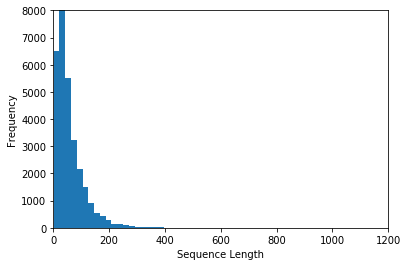

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Dựa trên biểu đồ histogram ở trên chúng ta có thể thấy là 180 là kết quả tương đối hợp lý. 

In [75]:
maxSeqLength = 180

Để có cảm nhận rõ hơn về dữ liệu, chúng ta có thể hiển thị một số review bất kỳ như sau.

In [76]:
print('A positive sentence: ')
fname = positiveFiles[5] # Randomly select a positive file to view
with open(fname, encoding='utf-8') as f:
    for lines in f:
        print(lines)

print('A negative sentence: ')
fname = negativeFiles[11] # Randomly select a negative file to view
with open(fname, encoding='utf-8') as f:
    for lines in f:
        print(lines)


A positive sentence: 
Mình đến Nồi_Bay hôm trước và có gọi bánh Mousse_Coffee và Chaka việt quất . Bánh rất ngon > v . Trong khi mấy quán em đi thì chẳng chỗ nào như_vậy , toàn phải gọi thêm nước uống 20-30k trở_lên TvT . Như_vậy nghĩa_là quán rất quan_tâm đến khách_hàng . Yêu_Nồi lắm ạ . Em sẽ quay lại lần tới : 3 .

Ảnh dưới do mải ăn quá mãi mới nhớ ra phải chụp ảnh nên bánh nó mất một góc ; v ;

A negative sentence: 
Không_gian quán ok như những quán king khác .

Đồ_ăn ngoài kệ thì nhiều nhưng_mà đồ gì đâu không ngon . Tráng_miệng thì ok nhất . Kem ở king thì siêu ngon rồi . Rau_câu chè cũng ok .

Về phần thịt thì_phải nói là siêu dở . Dở nhất trong những quán hq mình từng ăn luôn . Thịt nướng mà đông đá cứng ngắt . Nướng lên có nghe mùi_vị gì nữa đâu . Thấy kinh_khủng .

Nv thì hách nhất_là ông kia . Kiu k trả_lời liền đâu . Bạn mình để quên đồ mà ở đó nói là tưởng rác mang đi giục luôn . Hâh .

Ai k biết ăn_ở đây rồi chắc k dám ăn king ở tp nữa luôn qua . Mất_mặt cả chi_nhánh



## Chuẩn hoá văn bản và tách từ

Để tiết kiệm công sức và cũng nằm ngoài phạm vi của khoá học, chúng tôi đã chuẩn bị sẵn tập dữ liệu đã được tách từ. Giữa hai từ có thể ghép lại để tạo thành một khái niệm mới chúng tôi sử dụng ký tự '_' để nối các từ đó. Ví dụ: 'sinh_viên', 'sinh_học'.

Chúng tôi chuẩn bị sẵn các hàm chuẩn hoá văn bản nhằm loại bỏ các ký tự đặc biệt. Tham khảo ở hàm 'cleanSentences'.

In [77]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^\w0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

Bây giờ chúng ta sẽ biểu diễn 30.000 review dưới dạng các chỉ số của các từ. Tập dữ liệu positive và negative sẽ được tính hợp lại thành một ma trận 30000x180. Trong đó 30000 là số lượng review và 180 là số lượng từ tối đa cho một câu. Do bước chuẩn bị này tốn khá nhiều tài nguyên tính toán nên sau khi tính toán xong, chúng ta sẽ lưu lại để sử dụng cho những lần chạy thí nghiệm sau. Ma trận lưu trữ các chỉ số này là: 'ids'.

### ToDo 3.2: xác định chỉ số của từng từ trong review

Trong phần này chúng ta sẽ tiến hành tra cứu từng từ trong review, sau đó gán vào ma trận 'ids'. Trong đó chỉ số dòng của ma trận tương ứng với file review, chỉ số cột của ma trận tương ứng với một từ của review. Trường hợp từ nào không có trong tập từ điển thì ta sẽ gán bằng chỉ số của từ 'UNK' (unknow).

In [78]:
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
nFiles = 0
# Index of Unknow word
unk_idx = wordsList.index('UNK')

for pf in positiveFiles:
    with open(pf, "r", encoding="utf-8") as f:
        nIndexes = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            # TODO 3.2: Nếu 'word' thuộc tập 'wordsList' thì gán chỉ số của 'word' vào ma trận ids
            if word in wordsList: 
                ids[positiveFiles.index(pf)][split.index(word)]=wordsList.index(word)
            # Ngược lại: gán 'unk_idx' vào ma trận ids
            else: 
                ids[positiveFiles.index(pf)][split.index(word)]=wordsList.index("UNK")
            nIndexes = nIndexes + 1
            if nIndexes >= maxSeqLength:
                break
        nFiles = nFiles + 1 

print('Positive files are indexed!')
for nf in negativeFiles:
    with open(nf, "r", encoding="utf-8") as f:
        nIndexes = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            # ToDo 3.2: tương tự như trên. Không khác gì hết.
            if word in wordsList: 
                ids[negativeFiles.index(pf)][split.index(word)]=wordsList.index(word)
            # Ngược lại: gán 'unk_idx' vào ma trận ids
            else: 
                ids[negativeFiles.index(pf)][split.index(word)]=wordsList.index("UNK")
            nIndexes = nIndexes + 1
            if nIndexes >= maxSeqLength:
                break
        nFiles = nFiles + 1 

print('Negative files are indexed!')
# Save ids Matrix for future uses.
np.save(os.path.join(currentDir,'idsMatrix.npy'), ids)

'ids = np.zeros((numFiles, maxSeqLength), dtype=\'int32\')\nnFiles = 0\n# Index of Unknow word\nunk_idx = wordsList.index(\'UNK\')\n\nfor pf in positiveFiles:\n    with open(pf, "r", encoding="utf-8") as f:\n        nIndexes = 0\n        line=f.readline()\n        cleanedLine = cleanSentences(line)\n        split = cleanedLine.split()\n        for word in split:\n            # TODO 3.2: Nếu \'word\' thuộc tập \'wordsList\' thì gán chỉ số của \'word\' vào ma trận ids\n            if word in wordsList: \n                ids[positiveFiles.index(pf)][split.index(word)]=wordsList.index(word)\n            # Ngược lại: gán \'unk_idx\' vào ma trận ids\n            else: \n                ids[positiveFiles.index(pf)][split.index(word)]=wordsList.index("UNK")\n            nIndexes = nIndexes + 1\n            if nIndexes >= maxSeqLength:\n                break\n        nFiles = nFiles + 1 \n\nprint(\'Positive files are indexed!\')\nfor nf in negativeFiles:\n    with open(nf, "r", encoding="utf-8"

In [79]:
# LƯU Ý: Bước thực hiện trên tương đối mất thời gian.
# Trường hợp đã tính toán và lưu ma trận 'ids' rồi thì ta có thể load lên để sử dụng luôn
currentDir=parent_dir
ids = np.load(os.path.join(currentDir,'idsMatrix.npy'))
print('Word indexes of the first review: ', ids[0])


Word indexes of the first review:  [19898  1906  4454  5284 10661 11694 11994 18784 18569 18619 13174  9821
 14794  8884  6443  5767  8589 18850 15570  5596   799 11060  4222 16893
 13078  8136  3364  4454  4756 10304  8885  3553  9782  1232 14359 10606
   579 15522  2219 15092 14855 15253  4884  3364  5519  4558  9649   269
 15522 12309 14855 11503  2212  4884  7155 11577  4222  5767 15076 12225
 10774  1218  2876 19584  4558  2974 13452  5013   842 10642 17292 11895
   803 11060 16760  1906 15253 14598 15253  1047  5668  4884 10642 12225
  7090 17292 18109 13078 16334  1238  3364  5519  4135  3553 14967  4964
 15385  9673  2997 14855  7446  8038 11440  1345   842  5767   803 11060
 18791  5013     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    

Nếu như quá trình chuyển từ câu dạng văn bảng sang vector các chỉ số trong từ điển ở trên đúng thì ids[0] sẽ nhận giá trị: [19898  1906  4454  5284 10661 11694 11994 18784 18569 18619 13174  9821 ...]

## Xây dựng hàm lấy dữ liệu train và test theo từng batch

Dưới đây chúng tôi xây dựng các hàm để lấy dữ liệu train và test theo từng batch. Bạn hãy giải thích tại sao lại có các con số 13999, 14999, 15999, 29999 nhé.

In [80]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            # Pick positive samples randomly
            num = randint(1,13999)
            labels.append([1,0])
        else:
            # Pick negative samples randomly
            num = randint(15999,29999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(13999,15999)
        if (num <= 14999):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

# 3. Xây dựng RNN Model với Tensorflow

Đầu tiên chúng tôi sẽ khởi tạo các tham số cho mô hình mạng RNN với các cell là các LSTM. Kiến trúc mạng ở đây bao gồm 128 đơn vị cho mỗi lớp, số lượng layer là 2, số lượng phân lớp là 2 và số vòng lặp khi huấn luyện là 30000.

In [81]:
# Initialize paramters
numDimensions = 300
batchSize = 64
lstmUnits = 128
nLayers = 2
numClasses = 2
iterations = 30000

Để lưu trữ dữ liệu input và ouput, chúng ta sẽ sử dụng hai kiểu dữ liệu placeholder. Một trong những điều quan trọng nhất khi khởi tạo các biến input và output này là xác định kích thước của các tensor. Mỗi output của mạng (hay còn gọi là label) sẽ là một vector one hot với hai giá trị tương ứng với hai loại cảm xúc: [1, 0] cho positive và [0, 1] cho negative.

![caption](Images/data_batch.png)

## ToDo 3.3: Xác định input và output

Khởi tạo hai biến 'inputs' và 'labels' bằng kiểu placeholder.

Sau đó tạo dữ liệu word vector từ khối dữ liệu đầu vào với ma trận word embedding. Nếu như quá trình khởi tạo đúng thì sẽ tạo ra các kiểu dữ liệu sau:
labels --> Tensor("Placeholder:0", shape=(64, 2), dtype=float32)
inputs --> Tensor("Placeholder_1:0", shape=(64, 10), dtype=int32)

![caption](Images/embedding_data.png)

Như vậy sau bước này chúng ta đã có dữ liệu để đưa vào mạng mạng các LSTM. Để khởi tạo một LSTM chúng ta sử dụng hàm tf.nn.rnn_cell.BasicLSTMCell. Hàm này cần tham số đầu vào là số lượng đơn vị muốn khởi tạo. Đây chính là một hyperparamter đã được khởi tạo trước đó.
Để chống lại việc overfitting, chúng ta sử dụng lớp dropout. 

Để tăng tính phức tạp cho kiến trúc mạng chúng ta chồng các lớp LSTM lên nhau (Stack LSTM Layers). Trong trường hợp này chúng ta sử dụng 2 lớp LSTM. Việc chồng thêm các lớp LSTM sẽ giúp cho mô hình có khả năng nhớ nhiều thông tin hơn nhưng đồng thời cũng làm tăng số lượng tham số khi huấn luyện. Điều này cũng có nghĩa là sẽ làm tăng thời gian huấn luyện cũng như là cần thêm nhiều dữ liệu hơn.

Cuối cùng là đưa toàn bộ dữ liệu đầu vào vào mạng các LSTM sử dụng hàm tf.nn.dynamic_rnn. Chi tiết kiến trúc mạng LSTM sử dụng cho bài tập này được mô tả trong hình sau:

![caption](Images/architecture.png)

In [82]:
import tensorflow as tf
tf.reset_default_graph()

# TODO 3.3: Khởi tạo hai biến 'inputs' và 'labels'
inputs = tf.placeholder(tf.int32,[batchSize, maxSeqLength])
labels = tf.placeholder(tf.float32,[batchSize, numClasses])
data = tf.nn.embedding_lookup(wordVectors, inputs)
def generate_a_lstm_layer():
    # Khởi tạo một LSTM layer với 'lstmUnits' unit sử dụng hàm tf.contrib.rnn.BasicLSTMCell
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstmUnits)
    # Sau đó tạo một lớp dropout để chống overfitting với hệ số out_keep_prob bằng 0.75
    # Sử dụng hàm tf.contrib.rnn.DropoutWrapper
    dropout_lstm = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.75)
    return dropout_lstm

cell=generate_a_lstm_layer()
# Sau khi đã có hàm tạo một LSTM Layer, ta sử dụng hàm này để chồng các LSTM lên
# Stack các LSTM layer với hàm tf.nn.rnn_cell.MultiRNNCell
cells = tf.nn.rnn_cell.MultiRNNCell([cell],nLayers)

# Feed data variable vào mạng LSTM sử dụng hàm tf.nn.dynamic_rnn

outputs,_ = tf.nn.dynamic_rnn(cell=cells,inputs= data, dtype=tf.float32)
print(outputs)

Tensor("rnn/transpose_1:0", shape=(64, 180, 128), dtype=float32)


Sau khi ra khỏi mạng LSTM, biến outputs sẽ là một tensor có kích thước [batchSize x maxSeqLength x lstmUnits], cụ thể là [64 x 180 x 128].

Sau đó, chúng ta chỉ lấy dữ liệu ở LSTM cell cuối cùng và cho đi qua lớp kết nối đầy đủ để phân loại thành 2 trạng thái. Chỉ số của LSTM cell cuối cùng là 179 (do có 180 cell theo chiều ngang)  nên để có thể lấy được giá trị ta sẽ chuyển vị về tensor có kích thước [maxSeqLength x batchSize x lstmUnits] hay [180 x 64 x 128]. Sử dụng hàm tf.gather để lấy tensor thứ 179 có kích thước [64 x 128] bao gồm 64 mẫu vector 128 chiều. Vector 128 chiều này sẽ được đưa vào lớp fully connected để chuyển đổi về vector 2 chiều tương ứng với 2 trạng thái.

Lớp kết nối đầy đủ bao gồm các bộ tham số 'weight' và 'bias' để thực hiện việc dự đoán kết quả. Bước này chính là tạo một lớp Fully Connected như trong sơ đồ kiến trúc mạng LSTM.

In [83]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
# Lấy giá trị output tại LSTM cell cuối cùng
outputs = tf.transpose(outputs, [1, 0, 2])
last = tf.gather(outputs, int(outputs.get_shape()[0]) - 1)
# Đưa qua mạng Fully Connected mà không có activation function
prediction = (tf.matmul(last, weight) + bias)


Để xác định độ chính xác của hệ thống, ta đếm số lượng labels khớp với giá trị dự đoán (prediction). Sau đó tính độ chính xác bằng cách tính giá trị trung bình của các kết quả trả về đúng.

In [84]:
correctResult = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctResult, tf.float32))

Sau đó chúng ta sẽ xác định hàm độ lỗi sử dụng softmax cross entropy được tính từ dữ liệu dự đoán và tập labels. Cuối cùng là chọn thuật toán tối ưu với tham số learning rate mặc định là 0.001. 

In [85]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

## Sử dụng Tensorboard để visualize kết quả

Trong quá trình huấn luyện, chương trình sẽ ghi log về độ lỗi và độ chính xác trên tập train vào thư mục 'tensorboard', lưu lại model sau mỗi 2000 vòng lặp ở thư mục 'models'. Việc huấn luyện trên 30,000 vòng lặp mất khoảng vài tiếng với GPU K80 được cung cấp bởi Google Colab.

# 4. Huấn luyện

Với mỗi vòng lặp, ta sẽ lấy ra một batch dữ liệu train để đưa vào mạng sử dụng `feed_dict`. với các tham số input và label là các placeholders. Bước huấn luyện này được lặp lại cho đến khi hết số lần cần huấn luyện.

In [86]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"


In [87]:
sess = tf.InteractiveSession()
writer = tf.summary.FileWriter(logdir, sess.graph)
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
print (logdir)

for i in range(iterations):
    # TODO 3.5
    # Get next training batch
    nextBatch, nextBatchLabels=getTrainBatch()
    # Feed to optimizer
    sess.run(optimizer, feed_dict={inputs: nextBatch, labels: nextBatchLabels})
    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {inputs: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)
    
    # Save model every 2000 training iterations
    loss1=sess.run(loss, feed_dict={inputs: nextBatch, labels: nextBatchLabels})
    print ("loss=",loss1)
    print ("epoch=",i)
    if (i % 2000 == 0 and i != 0):
        save_path = saver.save(sess, os.path.join(currentDir,"models/pretrained_lstm.ckpt"), global_step=i)
        print("saved to %s" % save_path)
writer.close()

tensorboard/20180621-170236/
pred= [[ 0.8181139   1.1621046 ]
 [ 2.1867495   0.82093143]
 [ 2.5587454   1.8124036 ]
 [-0.18639103  2.122069  ]
 [ 2.8652425  -0.18910578]
 [ 2.1584945   1.4372634 ]
 [ 0.95878273  0.34586334]
 [ 1.2320396   0.33381906]
 [ 2.6927876   1.8435827 ]
 [ 2.35787     0.31825045]
 [ 2.1767678   2.4843504 ]
 [ 1.4134954   1.6590029 ]
 [ 2.7782679   1.2322754 ]
 [ 2.3599265   0.198603  ]
 [ 3.5667267   0.97273827]
 [ 1.4972264   1.0743009 ]
 [ 2.593341    0.8746145 ]
 [ 1.1168687   3.702748  ]
 [ 2.074381    2.7618098 ]
 [ 1.3353384   2.1666284 ]
 [ 3.3043447   0.9258167 ]
 [ 0.7865095   0.14993274]
 [ 2.5199692   3.264841  ]
 [-0.5541     -0.5487085 ]
 [ 1.8024155   2.6158595 ]
 [ 1.9189248  -0.2652982 ]
 [ 1.3258257   2.940958  ]
 [ 2.781666    2.2377057 ]
 [ 2.1437554   1.3259841 ]
 [ 1.007093    1.568845  ]
 [ 1.6913428  -0.16340712]
 [ 2.4325008   2.454882  ]
 [ 1.916312    0.785205  ]
 [ 0.9710647   2.4146478 ]
 [ 2.1269505   0.6505555 ]
 [ 0.3483276   2.388

loss= 1.8674926
epoch= 4
pred= [[ 1.4248953  -0.36970028]
 [ 2.7926247  -0.6373312 ]
 [ 2.7224815  -0.17898169]
 [ 0.83392596 -1.6434107 ]
 [ 1.5355796  -1.1134677 ]
 [ 4.100491    1.0471932 ]
 [ 2.8117363  -1.3738968 ]
 [ 3.7764223  -0.829724  ]
 [ 3.6498744  -2.1558123 ]
 [ 1.5150697  -2.0004163 ]
 [ 0.83339876 -0.25838926]
 [ 2.7820637   0.26967567]
 [ 0.35872513 -1.833261  ]
 [ 0.6938219  -3.1407027 ]
 [ 2.4194021   0.0120072 ]
 [ 3.921904    0.28478277]
 [ 0.9204968  -2.753086  ]
 [ 1.8633351  -3.2669213 ]
 [ 0.72046053 -1.9053032 ]
 [ 0.72928125 -2.6093297 ]
 [ 1.7615393  -1.6890712 ]
 [ 1.9831553  -0.20258161]
 [ 1.6361542  -0.90853554]
 [ 1.7244544  -2.3151507 ]
 [ 2.9343565  -2.013566  ]
 [ 1.8574402  -0.04684214]
 [ 2.0388632  -1.8737411 ]
 [ 3.0137036  -1.1716998 ]
 [ 1.4714484  -0.17467049]
 [ 3.5354455  -2.3199549 ]
 [ 1.6951694  -1.8118535 ]
 [ 3.1033392  -1.8538648 ]
 [ 2.7391331   0.38726172]
 [ 2.7212775  -0.7956992 ]
 [ 1.8967793  -0.01274655]
 [ 2.7084546  -0.0589141

loss= 1.235937
epoch= 9
pred= [[ 0.19836855  0.31155926]
 [-1.6372656   1.9621347 ]
 [-0.28983623  2.4027731 ]
 [ 0.18465501  0.58908033]
 [-0.7813374   1.7038338 ]
 [-0.4215079   1.5719751 ]
 [-0.7132353   2.3211617 ]
 [ 1.1854503   1.4222815 ]
 [-1.4005833   2.9325895 ]
 [-1.1878773   2.770712  ]
 [-1.0835056  -0.20789108]
 [-0.37147307  0.15615189]
 [-0.32163048  2.1371868 ]
 [-1.2282807   3.32214   ]
 [-2.214959    2.3790603 ]
 [-0.3157431   2.0301504 ]
 [-0.54758406  2.1712728 ]
 [ 0.17847851  2.550863  ]
 [ 0.17425823  0.01354267]
 [-0.90201515  2.384059  ]
 [ 0.42943406  2.9456835 ]
 [ 0.06093866  2.3053617 ]
 [-0.72380173  2.7411819 ]
 [-1.8923634   1.0697134 ]
 [-1.0644227   2.489668  ]
 [-1.8000177   0.55421203]
 [ 0.04679746  2.16584   ]
 [ 0.38476855  2.896447  ]
 [-1.1870646   1.7316935 ]
 [-1.1865498   2.293152  ]
 [-0.28207725  1.3011352 ]
 [-1.6598216   1.9671184 ]
 [-0.7671514   2.6880896 ]
 [ 1.2152538   1.9477692 ]
 [-0.28301805  0.67723596]
 [ 0.8671569   1.4964123 

loss= 1.2620507
epoch= 14
pred= [[ 0.3135401  -1.0151018 ]
 [ 1.0336838  -2.0771396 ]
 [ 1.5760733  -0.6062047 ]
 [-0.544579   -1.3288118 ]
 [ 0.8507735  -2.1007879 ]
 [ 0.29307237  0.13216029]
 [ 1.8183812   0.1130884 ]
 [ 2.0031447  -1.7447591 ]
 [ 1.1707767   1.1733905 ]
 [ 0.5273156  -2.59303   ]
 [ 0.44369107 -0.9704496 ]
 [ 1.6793944   0.4338318 ]
 [ 0.8892999   0.44026417]
 [ 0.8156928  -0.83004093]
 [ 0.16768742 -0.82626885]
 [ 0.89619315  0.00379924]
 [ 0.2005673   1.0743347 ]
 [-0.88539696 -0.7289776 ]
 [ 1.2899399  -0.15584742]
 [ 1.6118919  -0.03155933]
 [ 1.3771597   0.1619608 ]
 [ 0.7236567  -0.9314098 ]
 [ 1.4934688  -1.5859948 ]
 [ 0.52067626 -0.05728845]
 [-0.43725014  1.052785  ]
 [ 0.6047571  -0.8505469 ]
 [ 0.02758646 -0.00358178]
 [ 0.02365535 -0.57380044]
 [ 1.2239105  -1.338956  ]
 [ 1.8928419  -1.7464238 ]
 [ 1.3911074  -1.4977746 ]
 [ 1.4673728  -2.3311346 ]
 [ 0.8266624   1.0354894 ]
 [ 0.07161275  0.9932215 ]
 [ 2.7175565   1.22202   ]
 [ 1.216499    0.976157

loss= 0.8976032
epoch= 19
pred= [[-0.11851002  0.32055512]
 [-1.1776975  -0.33429745]
 [-0.22612399 -0.05423791]
 [-0.6637445   0.7733042 ]
 [-0.90402275  0.93752146]
 [-0.4868896   0.4258548 ]
 [-0.5360317   1.2203526 ]
 [-1.0927473   0.7175324 ]
 [-0.5642466  -0.54580045]
 [-0.28074157  0.45785323]
 [ 0.5033092   2.5154166 ]
 [ 0.84664893  1.745961  ]
 [-0.42729634  0.66514695]
 [-1.2704989   0.5191934 ]
 [-0.25300324 -0.41916046]
 [-0.29024     0.01347735]
 [-0.25937966  1.0807143 ]
 [-0.9875191   0.88350886]
 [-1.5424181   1.1528661 ]
 [-0.60600126 -0.44986144]
 [-1.5420278  -0.33553982]
 [-1.0156927  -0.11682496]
 [-0.98396283 -0.5026958 ]
 [-0.45594555 -0.1164429 ]
 [-1.9241947  -0.8954021 ]
 [ 0.20833236  1.7974683 ]
 [ 1.4169313   1.3957195 ]
 [-0.26483122  1.3420444 ]
 [-0.59829587  0.31690773]
 [ 0.34733656  1.5511091 ]
 [-0.9853774   0.16769603]
 [ 0.19079202 -0.09156991]
 [-1.1611674  -0.43592998]
 [-1.0692266  -0.08015809]
 [-0.00537331 -0.40886477]
 [-1.218242    0.196203

loss= 0.7662902
epoch= 24
pred= [[ 0.09817937  0.18158321]
 [ 1.0984538   0.35342425]
 [-0.56068575 -1.0847327 ]
 [-0.7421293  -0.61123437]
 [ 0.9805522   0.05370526]
 [-0.38347426 -1.3695743 ]
 [-0.07100418 -0.7634896 ]
 [-1.3281975  -0.95419633]
 [-0.11056596 -0.31761652]
 [-0.32337734 -0.09916402]
 [ 0.21699908 -0.63921607]
 [-0.21050051 -0.03589107]
 [-0.5747374  -0.47265363]
 [-0.60420966 -0.2349263 ]
 [ 0.804263    0.07986493]
 [-0.52041614  1.2385207 ]
 [-0.5959084  -1.0052676 ]
 [ 0.60495996 -0.02717878]
 [ 0.45403507 -0.3143924 ]
 [-0.7803985  -0.19535048]
 [ 0.29244018 -0.70937514]
 [-0.24341765 -1.0669904 ]
 [-0.23492676 -0.98844683]
 [-0.21863928 -0.88985884]
 [ 0.0947108  -0.62868106]
 [-0.5026624   0.1401379 ]
 [ 0.18680769 -0.10869385]
 [ 0.85374904 -0.13887526]
 [ 0.07142881 -0.26942623]
 [ 0.46349496 -0.6851785 ]
 [-0.9994495   0.40126246]
 [ 0.32368925 -0.74750507]
 [-0.44844702 -1.2258639 ]
 [ 0.21538964 -0.263439  ]
 [ 0.3258363  -0.11767422]
 [ 0.95032585 -0.696398

loss= 0.7325312
epoch= 29
pred= [[-7.3968786e-01  5.6950003e-04]
 [-7.6404411e-01 -9.7906196e-01]
 [-5.4933739e-01 -4.1614291e-01]
 [ 1.0551713e-01 -1.1886619e+00]
 [-7.9897702e-01 -2.0988274e+00]
 [ 2.2136214e-01 -4.0014230e-02]
 [ 1.8618426e-01 -7.2746581e-01]
 [ 7.3907363e-01  6.1241083e-02]
 [-3.4498045e-01 -6.6067374e-01]
 [ 1.3644174e-01  2.5477606e-01]
 [ 6.5887618e-01  1.1504569e+00]
 [ 4.4943345e-01 -1.5584984e+00]
 [-6.6915369e-01 -9.1967963e-02]
 [-2.9277213e-02 -8.2326794e-01]
 [-5.1637149e-01 -1.0411261e+00]
 [-1.3364419e+00 -1.3542784e+00]
 [-3.8459638e-01  1.9951198e-01]
 [ 2.4575096e-01  2.4452120e-01]
 [-6.3658911e-01 -3.9679709e-01]
 [-7.0172596e-01 -1.0524621e+00]
 [-1.4233628e-01 -1.9076859e+00]
 [-7.8999028e-03 -1.4754730e+00]
 [ 2.0925686e-01 -7.3324621e-01]
 [-4.4918504e-01 -2.9121032e-01]
 [-3.5084650e-01 -7.3648840e-01]
 [-6.3262677e-01 -7.6208472e-01]
 [-2.7990419e-01 -1.2859756e+00]
 [-1.5826307e-02 -4.2322341e-01]
 [-3.9946817e-02  5.6115377e-01]
 [-8.988970

loss= 0.8134911
epoch= 34
pred= [[-9.01552260e-01 -1.56574249e+00]
 [-9.62373316e-01  1.30718994e+00]
 [-2.13147685e-01  3.70657504e-01]
 [-6.51492834e-01 -5.65207481e-01]
 [-7.49580801e-01  2.19720006e-01]
 [-5.28865755e-01 -1.73166394e-01]
 [-2.70159245e-01 -4.36634064e-01]
 [-2.50423670e-01  6.51734412e-01]
 [-5.24686933e-01  5.59906811e-02]
 [ 3.28413725e-01 -2.38870144e-01]
 [-5.89749992e-01 -2.05349040e+00]
 [-8.36730599e-01 -5.98875880e-02]
 [-3.71578574e-01 -5.72012901e-01]
 [-1.02448928e+00  1.21855937e-01]
 [-1.48758635e-01 -1.03188723e-01]
 [-2.94336379e-01 -5.99838614e-01]
 [-1.92928576e+00 -1.75898123e+00]
 [-2.80888259e-01 -1.70830071e-01]
 [ 7.73431361e-03 -4.54589427e-01]
 [-5.39409101e-01 -1.40674293e+00]
 [-2.73205996e-01 -1.61864257e+00]
 [-1.93828776e-01  1.78337991e-02]
 [-8.84328604e-01  6.17913246e-01]
 [ 5.89636266e-01  2.27048993e-01]
 [ 6.09035015e-01  4.40031081e-01]
 [-3.27014685e-01 -2.46851772e-01]
 [-1.10910583e+00 -7.05394268e-01]
 [-6.41056240e-01 -5.60

loss= 0.8121021
epoch= 39
pred= [[-1.2353976  -0.7680622 ]
 [-0.13613296 -0.73416764]
 [-1.2804378  -0.9742505 ]
 [-0.44179776 -1.0583206 ]
 [-0.61184514 -1.1067472 ]
 [ 0.1276305  -1.2888446 ]
 [-0.4604493  -1.6165081 ]
 [-0.36742076 -1.4671724 ]
 [ 0.06847874 -0.3949429 ]
 [-0.36679083 -1.0090865 ]
 [-0.30552557 -1.3145429 ]
 [-0.26069012  0.03848267]
 [ 0.41202256  0.5404561 ]
 [-0.84072095 -0.80580395]
 [ 0.16525525 -0.40679964]
 [-0.23703039 -0.77460486]
 [-0.7348618  -0.01093533]
 [-0.6056339  -0.9938353 ]
 [-0.18911016 -1.8667687 ]
 [-0.06018373 -0.3992494 ]
 [-0.7054423  -0.68859464]
 [-0.8948621  -1.67039   ]
 [-0.35457718 -1.4835662 ]
 [ 0.7970383   0.44462523]
 [ 0.9972735  -0.4193742 ]
 [-0.24025974 -0.4853365 ]
 [ 0.5358777  -0.4278228 ]
 [-0.39350542 -0.4727864 ]
 [-0.67417854 -1.1574435 ]
 [-0.83995837 -0.98305184]
 [-0.5590908  -1.5075954 ]
 [-0.18346813 -0.31700894]
 [ 0.8483197   0.06393374]
 [-0.5413884  -0.11116489]
 [ 0.9595031   0.07402206]
 [ 0.02504913 -0.741825

loss= 0.73249996
epoch= 44
pred= [[ 1.0591149   0.06385703]
 [ 0.6118195  -0.9090842 ]
 [-1.3576598  -0.45916584]
 [-0.25907156 -0.4364814 ]
 [-0.01446114 -0.51800644]
 [-0.5300206   0.22780031]
 [-0.67938393 -0.09783762]
 [-0.86025935 -0.3376545 ]
 [ 0.17161682 -0.21900648]
 [ 0.40265974 -0.2853783 ]
 [ 0.5852918   0.13846132]
 [-1.9214363  -1.6678002 ]
 [-0.08380296  0.70866895]
 [-0.09743457 -0.3863652 ]
 [-0.75818896 -0.32780337]
 [ 0.27120975  0.36046547]
 [ 0.47919664  0.56494   ]
 [-0.5265515   0.73147565]
 [-0.44718847  0.38268265]
 [-1.2482985  -0.4019101 ]
 [-0.52887535 -1.3101611 ]
 [-0.86036813 -0.06018641]
 [-0.48007885 -1.1336548 ]
 [-0.9491644  -0.936298  ]
 [-1.1005746  -0.1843954 ]
 [-0.75990057  0.21791923]
 [-0.25266764  0.7213019 ]
 [-0.25250968 -0.03077253]
 [-0.58285195  0.45002708]
 [-1.6672796  -1.2263156 ]
 [-0.39520314 -0.34230646]
 [-1.1563425  -0.3952477 ]
 [-0.7658602  -0.36482668]
 [-0.5765724   0.29565915]
 [-0.82140636 -0.470035  ]
 [-0.6966401  -0.27470

loss= 0.68089354
epoch= 49
pred= [[-0.47425562 -0.9984897 ]
 [-0.03335346 -0.7560068 ]
 [-0.43402475  0.27154383]
 [-0.19130296 -0.4943817 ]
 [-0.3386128   0.08824494]
 [-0.15519613 -1.1580408 ]
 [-0.40864825 -0.6776957 ]
 [-1.0407175  -1.2792546 ]
 [-0.9746964  -1.4306806 ]
 [-0.5971435  -0.94243497]
 [-0.6887917  -0.96895367]
 [ 0.5204876   0.30919525]
 [ 0.17039147 -0.31158808]
 [ 0.24350253  0.0457245 ]
 [-0.18397504 -0.33946308]
 [-0.1637026  -0.0631066 ]
 [ 0.6503306   0.19342616]
 [-1.305896   -1.1974854 ]
 [-0.36870396 -0.43002728]
 [-0.0735381  -0.32225284]
 [-0.08364535 -0.34899113]
 [-0.5934283  -0.7928315 ]
 [-0.40983737 -1.0438585 ]
 [ 0.8350549   0.01173749]
 [-0.7578428  -1.2172135 ]
 [-1.1196364  -1.3214576 ]
 [ 1.0464807  -0.06707961]
 [-0.74493444 -1.2465277 ]
 [ 0.29422343  0.29225194]
 [-0.5138744  -1.0094833 ]
 [-0.4565642  -0.68858695]
 [ 0.7118305   0.43323237]
 [-0.49947053  0.07435387]
 [-0.21018955  0.27563164]
 [-0.34653294 -0.5589494 ]
 [-0.854156   -0.61523

loss= 0.7510431
epoch= 54
pred= [[-0.7228187  -0.863685  ]
 [-0.23941427 -0.07769206]
 [-0.5707706  -0.15732686]
 [ 0.24281321  0.13522305]
 [-0.27877653 -0.7440863 ]
 [-0.5071203  -0.52613574]
 [-0.5145604  -0.56450874]
 [-0.9999413  -0.46881598]
 [-1.1539478  -1.3119487 ]
 [-0.87090343 -0.76848745]
 [ 0.37982965  0.8248075 ]
 [-0.09583068 -0.03589277]
 [-1.0294249  -0.8982265 ]
 [-0.7213247  -0.13214016]
 [-0.574794   -0.48185718]
 [-0.7210218  -0.8031551 ]
 [-0.51561135 -0.6704563 ]
 [-0.6322189  -0.45247197]
 [-0.43987048 -1.06936   ]
 [-0.49965352 -0.13336714]
 [-0.68685216 -0.6684321 ]
 [-0.9201421   0.00424518]
 [-1.1928692   0.18556668]
 [-0.49056804 -0.5479267 ]
 [-0.69651854 -0.7465808 ]
 [-1.1186726  -0.02860694]
 [-0.07765746  0.04744799]
 [-0.11345783 -0.3782792 ]
 [-0.87069976 -0.74328136]
 [-0.05751738 -0.29514056]
 [-0.23378074 -0.7986654 ]
 [ 0.25877437  0.17915882]
 [ 1.0262167  -0.08365802]
 [-0.27525568 -0.9012356 ]
 [-1.2357054  -1.6879244 ]
 [-0.03100222 -0.325469

loss= 0.7654746
epoch= 59
pred= [[-0.4550956  -1.0506567 ]
 [-1.4453917  -0.762175  ]
 [-0.22643071 -0.931021  ]
 [-0.79810435 -1.3447158 ]
 [-0.94127184 -0.3981263 ]
 [-0.7092685  -0.45818925]
 [-0.27669185 -0.06761952]
 [-1.3743498  -0.87516874]
 [-0.48191118 -0.7155222 ]
 [-1.3657649  -1.421351  ]
 [-0.16476452 -0.7614142 ]
 [ 0.24561025 -0.5117667 ]
 [-0.53483665 -0.6106763 ]
 [-0.73340774  0.27836782]
 [-0.4069944   0.00974549]
 [-0.5796742  -1.0064888 ]
 [-1.1869903  -1.4842257 ]
 [-0.70544386 -0.30180377]
 [-0.7641489  -0.7742869 ]
 [-0.51658356 -1.046592  ]
 [-0.41138357  0.05684026]
 [-0.44912297 -0.03143586]
 [ 0.13274372  0.31595087]
 [-0.45453697  0.23590854]
 [ 0.72048527  0.33315915]
 [-0.68529314 -0.88320196]
 [-1.2543051  -1.9292309 ]
 [-0.01847852 -0.68636394]
 [-0.42947263 -0.57367814]
 [ 0.16683224  0.45252806]
 [-1.0840173  -0.8909357 ]
 [ 0.36171234  0.2418801 ]
 [-0.33592844 -0.5422529 ]
 [ 0.51526755 -0.4126523 ]
 [-1.0620046  -1.168288  ]
 [ 0.45654157  0.465826

loss= 0.74969673
epoch= 64
pred= [[-0.4106914  -0.6302298 ]
 [-0.8598747  -1.0761029 ]
 [-0.45469764 -0.8179492 ]
 [-0.6967832  -1.4626235 ]
 [ 0.05644444  0.14960726]
 [-1.0030434  -0.2376997 ]
 [-0.04544893 -0.8472835 ]
 [-0.51812077 -0.7897365 ]
 [ 1.30589     0.337503  ]
 [-0.26800996  0.2584523 ]
 [-0.21799484 -1.3322477 ]
 [-1.1593595  -1.7849377 ]
 [-0.83941936 -1.0639892 ]
 [-1.0375092  -1.4621159 ]
 [ 0.27800265 -0.3792395 ]
 [-0.8200016  -0.9300239 ]
 [-0.6482229  -0.20541106]
 [ 0.1274791  -0.7320248 ]
 [-0.45730087 -0.89940363]
 [-0.4444947  -0.52693367]
 [-0.24183452 -1.2121543 ]
 [-0.12305769 -0.45326418]
 [-0.24196148 -0.49915504]
 [-0.33245987 -1.0400735 ]
 [-0.55934453 -1.4600583 ]
 [-0.3756714   0.13372642]
 [-0.25385067 -0.2664494 ]
 [-0.317081   -0.80375624]
 [-0.44316903 -1.3116456 ]
 [-0.5124192  -1.0762304 ]
 [ 0.13579932  0.50312567]
 [-0.2899789  -0.8606154 ]
 [-0.9085264  -1.4000745 ]
 [-0.82672715 -0.8839547 ]
 [ 0.35541767 -0.3779937 ]
 [-0.9995736  -0.98950

loss= 0.73011315
epoch= 69
pred= [[-1.11047447e+00 -4.43761528e-01]
 [-1.14654374e+00 -1.28097966e-01]
 [-7.80646801e-01 -3.40308309e-01]
 [-9.42113101e-02 -1.68423638e-01]
 [-7.63907909e-01 -6.91197753e-01]
 [-3.67024213e-01 -2.42024377e-01]
 [-3.98042530e-01 -5.89345098e-01]
 [-5.95870733e-01 -3.12375069e-01]
 [-1.00047815e+00 -7.67148376e-01]
 [-9.75987673e-01 -9.29132402e-01]
 [ 7.64996052e-01  1.92649528e-01]
 [-2.53251195e-01 -2.94737101e-01]
 [ 2.64670730e-01  5.93564093e-01]
 [ 6.49677157e-01  1.12025869e+00]
 [-9.20832157e-04  6.64992213e-01]
 [-1.86530232e-01 -1.03349835e-02]
 [-2.87000746e-01 -4.95616436e-01]
 [-1.18463326e+00 -1.00011814e+00]
 [-5.15451550e-01 -5.38530886e-01]
 [-9.59455848e-01 -2.72552371e-02]
 [-1.02986693e+00 -7.25937009e-01]
 [-1.69328421e-01 -3.83950412e-01]
 [-4.61619228e-01  3.65155280e-01]
 [-1.10533404e+00 -1.06942546e+00]
 [-5.40853739e-01 -4.57294166e-01]
 [ 2.73593009e-01 -3.64261121e-02]
 [-1.07361865e+00 -8.07881594e-01]
 [-2.53198534e-01  2.0

loss= 0.696173
epoch= 74
pred= [[ 0.57440853  0.4800477 ]
 [-0.06445166 -0.5640245 ]
 [ 1.0935572   0.34425867]
 [-0.1169225  -0.53946483]
 [ 0.01938736 -0.35968423]
 [-0.9580348  -1.0781524 ]
 [-0.7914167  -0.6983379 ]
 [ 0.32727587 -0.25129277]
 [ 0.18065739  0.09484972]
 [-0.44497395 -0.9198439 ]
 [ 0.2685284  -0.75797415]
 [-0.71701556 -0.16404055]
 [-0.8523753  -0.5134909 ]
 [-1.4816482  -1.9134519 ]
 [-0.53849185 -1.4096276 ]
 [-0.70322394 -1.5776061 ]
 [-0.35113966 -0.7742769 ]
 [ 0.18445729  0.07370259]
 [-0.20909613 -0.63532436]
 [-0.347697   -0.15508612]
 [-0.5002407  -0.43819487]
 [-0.7524908  -0.18268053]
 [-1.4353733  -1.0172323 ]
 [-0.24816525 -0.81932205]
 [-0.46855366 -0.43839192]
 [ 0.10316187  0.2907492 ]
 [-0.42877096 -1.0759261 ]
 [-0.7679617  -0.24436323]
 [-0.30579746 -0.7679254 ]
 [-0.7878439  -1.3594985 ]
 [-0.23947129 -0.52175146]
 [-0.5871117  -1.5806046 ]
 [ 0.34321377  0.14943038]
 [ 0.15981321 -0.3506838 ]
 [-0.7615871  -1.0041554 ]
 [-0.24559936 -0.9994814

loss= 0.7253128
epoch= 79
pred= [[-1.03596    -1.4432324 ]
 [-0.79791015 -0.33587503]
 [-0.16162309 -0.52300227]
 [-0.30786943 -0.03750703]
 [-0.796583   -1.0055462 ]
 [-1.5212646  -1.1776489 ]
 [-0.75944144 -0.42524663]
 [-0.60284454  0.06975371]
 [-0.9909411  -1.0598938 ]
 [-0.7731649  -0.27659386]
 [-0.5179053  -0.53505325]
 [-1.264788   -1.5581475 ]
 [-0.40649885 -0.3699664 ]
 [-0.08248887  0.769433  ]
 [-0.65674007 -0.9695728 ]
 [-0.41795963 -0.09230251]
 [-0.49825883 -0.27026078]
 [-0.76652724 -0.11202752]
 [-0.36267632 -0.61036986]
 [ 0.22584793  0.12781847]
 [-1.4596357  -1.6333234 ]
 [-1.1426986  -1.013248  ]
 [-0.86069006 -0.7112814 ]
 [-0.90796345 -0.6684789 ]
 [-0.25415155 -0.0907451 ]
 [-0.28019053 -0.15714157]
 [-0.71297365 -0.34818804]
 [ 0.33580625  0.45906472]
 [ 0.32272482  0.29221094]
 [-0.580778   -0.17467037]
 [-0.87326235 -0.50467134]
 [-0.88663584 -0.7880472 ]
 [-0.9146729  -1.2294929 ]
 [-1.1781107  -0.3907432 ]
 [-0.27842617 -0.15685424]
 [ 0.00730538 -0.343310

loss= 0.71606123
epoch= 84
pred= [[-0.2265869  -0.5745331 ]
 [ 0.20044868 -0.48176703]
 [-0.62626773 -0.3941344 ]
 [-0.3503666  -0.5937382 ]
 [-1.0442362  -0.61530566]
 [-0.64476    -1.0259004 ]
 [-0.64363384 -0.35799077]
 [-0.50494856 -0.69448364]
 [-0.4369082  -0.5514674 ]
 [ 0.24060209  0.2496857 ]
 [ 0.48894155 -0.23462015]
 [-1.0968324  -1.3082836 ]
 [-1.1524544  -0.99896   ]
 [-0.31206667 -1.35891   ]
 [-0.39020497 -0.5791825 ]
 [-1.0426918  -1.3772103 ]
 [-0.6360485  -0.9709234 ]
 [-0.77233344 -1.0997818 ]
 [-0.3508132  -0.5007074 ]
 [ 0.09831904 -0.13134976]
 [ 0.3524378   0.06670888]
 [-1.107035   -0.5464808 ]
 [-0.43139726 -0.1083177 ]
 [-1.3873568  -1.3438997 ]
 [-0.13391292 -0.67640007]
 [-0.07313986 -0.20146164]
 [-0.85173464 -1.3199996 ]
 [-0.4629829  -0.49379745]
 [-0.58816296 -0.39345035]
 [-0.2210085  -0.10051432]
 [-1.5042205  -1.5772095 ]
 [-0.40109736 -1.2586687 ]
 [-0.49192256 -0.7213708 ]
 [-0.39104855 -0.43889573]
 [ 0.13115795  0.30655015]
 [-0.65969163 -1.28040

loss= 0.71970093
epoch= 89
pred= [[-4.4996595e-01 -6.1939365e-01]
 [-6.8221098e-01 -5.7989758e-01]
 [-6.1740416e-01 -1.2829079e-01]
 [-1.2531393e+00 -1.3499082e+00]
 [-9.3189543e-01 -6.6962337e-01]
 [-2.6717660e-01 -2.6809764e-01]
 [-7.9824156e-01 -7.3058015e-01]
 [-2.2327992e-01 -3.8370019e-01]
 [-1.3403888e+00 -6.3663006e-01]
 [ 1.8036906e-01  2.0745780e-01]
 [-1.2867370e+00 -1.1279539e+00]
 [ 7.6149076e-02 -1.8952923e-01]
 [-1.3308793e-01  2.7405477e-01]
 [-1.8973163e-01 -8.5600269e-01]
 [-3.0137518e-01 -2.5600845e-01]
 [-2.6640356e-01 -5.7374150e-01]
 [-6.5232855e-01 -1.1839298e+00]
 [ 3.6802676e-01  1.8198301e-01]
 [-3.9318889e-01  6.9885314e-02]
 [-1.0254371e+00 -3.9806879e-01]
 [ 1.0315597e-01 -7.5558618e-02]
 [-1.8600288e-01  1.2664856e-01]
 [-4.0973258e-01 -8.4490910e-02]
 [-1.1063569e+00 -1.0776533e+00]
 [-8.9723557e-01 -1.2016362e+00]
 [-3.8217631e-01 -5.0248623e-01]
 [ 2.7217150e-02  2.9222351e-01]
 [-1.0390356e+00 -4.8918092e-01]
 [-8.8810331e-01 -4.3661070e-01]
 [-4.68000

loss= 0.68573993
epoch= 94
pred= [[-1.0368655  -0.08114834]
 [-0.6408875  -0.04271509]
 [ 0.522887   -0.05429386]
 [ 0.05315861 -0.10509397]
 [-0.77775586 -0.34205073]
 [-0.6375685  -0.17469569]
 [-0.96687067 -0.940028  ]
 [-0.59849477 -0.6496647 ]
 [-0.7430835  -0.6381275 ]
 [-0.9904442  -0.9223637 ]
 [-0.84105086  0.13388102]
 [ 0.4346638  -0.40680712]
 [-0.00198822  0.03930475]
 [-0.42618224 -0.4557994 ]
 [-0.6787101  -0.90286356]
 [-0.1538282  -0.48759007]
 [-0.14433077 -0.25528264]
 [-0.18249375 -0.7867934 ]
 [-0.1889605  -0.6301162 ]
 [-0.7508825  -0.6259577 ]
 [-0.7580668  -1.1786387 ]
 [-0.17077708 -0.5362584 ]
 [-0.18368787 -0.3136645 ]
 [-0.84232306 -0.5930123 ]
 [-0.55022955 -0.5227009 ]
 [-0.90270793 -1.0652072 ]
 [-1.1789172  -0.04825504]
 [-0.60918283 -0.6469754 ]
 [ 0.06130221 -0.06973462]
 [-0.5831704  -0.8882649 ]
 [-0.6503959  -0.8980933 ]
 [-0.81648064 -0.9325407 ]
 [-0.250993   -0.1600085 ]
 [ 0.26799622  0.00412978]
 [-0.7981769  -0.44401127]
 [-0.6377702  -0.91360

loss= 0.7179444
epoch= 99
pred= [[-0.3205225  -0.6164538 ]
 [-0.8004352  -1.0774913 ]
 [-0.809403   -0.43845752]
 [-0.41801882 -0.573108  ]
 [ 0.35750562  0.6405476 ]
 [-0.19902015 -0.69416505]
 [-0.4605     -1.004941  ]
 [-0.3252394  -0.33554456]
 [-0.2271379  -0.1415411 ]
 [-0.96244967 -1.2983963 ]
 [-0.4845866  -0.03552822]
 [-0.57409227 -1.1946981 ]
 [-0.88927484 -1.2531097 ]
 [-0.42934418 -0.4083024 ]
 [-1.1776193  -1.2895437 ]
 [-0.95452166 -1.1907195 ]
 [-0.740187   -0.04814155]
 [-1.0043608  -0.83092356]
 [ 0.0917855  -0.16239771]
 [-0.69290453 -0.672798  ]
 [-0.47626913 -0.23166004]
 [-0.2924766  -0.11413191]
 [-0.31000602 -0.56004673]
 [-0.8675521  -0.48577932]
 [-1.1708989  -1.2309653 ]
 [-0.69386244 -0.6333339 ]
 [-1.1847703  -0.6130551 ]
 [-0.52464354  0.8650231 ]
 [-0.7113251  -0.72737837]
 [-0.6027721  -0.69616073]
 [-0.76130205 -0.7580732 ]
 [-0.989632   -1.1238986 ]
 [-0.20794523 -0.16370377]
 [ 0.0821866  -0.33481523]
 [-0.708589    0.08177134]
 [-0.24591851 -0.271897

loss= 0.693324
epoch= 104
pred= [[-0.9653975  -1.1422832 ]
 [-0.8613465  -0.92666465]
 [-0.90993917 -0.7762967 ]
 [ 0.00643596  0.02835885]
 [-1.2331492  -0.5904905 ]
 [-1.1262045  -1.2649722 ]
 [-0.7669529  -0.15501113]
 [-0.7804492  -0.8296785 ]
 [-0.7831039  -0.62327915]
 [-1.1261694  -0.9438674 ]
 [-1.0575212  -1.3709245 ]
 [-1.4590602  -1.3218147 ]
 [-1.046489   -1.2818978 ]
 [-0.6558397  -0.88711244]
 [-0.00257227 -0.30302495]
 [-0.73934674 -0.6261353 ]
 [-0.2809722  -0.14170729]
 [-1.3154175  -1.5267891 ]
 [-0.7336735  -0.46909755]
 [-1.0673397  -1.0568202 ]
 [-0.9851258  -0.7795619 ]
 [-0.07783097 -0.53982514]
 [-0.9921675  -0.8686734 ]
 [-1.1452696  -1.257478  ]
 [-0.8071789  -1.166042  ]
 [-0.51946986 -0.40353292]
 [-0.1846909  -0.4858945 ]
 [ 0.15258199  0.07136334]
 [-1.0624359  -1.3447142 ]
 [-1.2096472  -1.5604205 ]
 [-0.23808125 -0.4753669 ]
 [-0.96549296 -0.7077984 ]
 [-0.780656   -0.7973118 ]
 [-0.29365706 -0.9423216 ]
 [-0.60038155 -0.16147418]
 [-0.523391   -0.954437

loss= 0.6971195
epoch= 109
pred= [[-0.51367664 -0.87257665]
 [-0.9039638  -1.0486454 ]
 [-0.35075894 -0.88555336]
 [-0.6035374  -0.7885699 ]
 [-0.41996247 -0.8879313 ]
 [-0.9390867  -0.90871924]
 [-1.0548576  -1.0244825 ]
 [-0.43921685 -0.7509559 ]
 [-1.2167985  -0.7906124 ]
 [-0.46534222 -0.61743385]
 [-1.4609249  -1.8993301 ]
 [-1.1964657  -1.4012785 ]
 [-0.57752335 -1.0721197 ]
 [ 0.09750074 -0.00393492]
 [-0.752699   -1.0529276 ]
 [-1.075566   -1.4394648 ]
 [-1.1686438  -0.9773453 ]
 [-0.3336178   0.05118974]
 [-1.178608   -1.5812902 ]
 [-0.9956114  -0.932612  ]
 [-0.89762354 -1.3261613 ]
 [-1.3392079  -1.2744155 ]
 [-1.2098632  -0.9271063 ]
 [-0.75514877 -0.96711415]
 [-0.5137231  -0.9171801 ]
 [-0.54521394 -0.3885575 ]
 [-1.1430941  -0.9590424 ]
 [-1.3735214  -1.5233679 ]
 [-1.0880611  -1.0672357 ]
 [-1.4032464  -1.171572  ]
 [-0.73699635 -0.9887226 ]
 [-0.36489353 -0.45208496]
 [-0.09261142 -0.5315063 ]
 [-1.0754906  -1.1661996 ]
 [-1.0179174  -0.52003473]
 [-1.2208006  -0.95409

loss= 0.70912135
epoch= 114
pred= [[-1.2435019  -0.45887735]
 [-0.6312006  -0.8228076 ]
 [-1.0003002  -1.0794053 ]
 [-0.7708977  -0.2687693 ]
 [-1.064335   -0.9638555 ]
 [-0.75564855  0.02940296]
 [-1.6398989  -1.2281702 ]
 [-1.3348075  -1.2941043 ]
 [-1.0728254  -0.6687337 ]
 [-1.2534088  -1.1337624 ]
 [-1.3811543  -0.75753593]
 [-1.2367476  -0.6290387 ]
 [-1.1402167  -1.1849979 ]
 [-0.58884525 -0.30686656]
 [-1.5977558  -0.8855224 ]
 [ 0.46872836 -0.2683004 ]
 [-1.1281427  -1.1441417 ]
 [-1.3191508  -1.1091409 ]
 [-1.2037656  -1.2639599 ]
 [-1.0677527  -0.95222247]
 [-1.1180118  -0.8324537 ]
 [-1.2291602  -0.8981282 ]
 [-1.2783448  -0.96230245]
 [-1.1700073  -1.0222754 ]
 [-0.19370556 -0.02652659]
 [-1.3264831  -0.947646  ]
 [-1.2078177  -0.7697191 ]
 [-1.6302935  -1.7551079 ]
 [-1.1841744  -0.37409183]
 [-0.70184994 -0.4616733 ]
 [-0.99931175 -1.4780836 ]
 [-1.1702045  -1.102243  ]
 [-1.6764606  -0.89356625]
 [-0.2999251  -0.4770907 ]
 [-1.0029633  -0.92596877]
 [-0.28349563 -0.4986

loss= 0.7028366
epoch= 119
pred= [[-1.944739   -1.604146  ]
 [-0.90024877 -1.1362544 ]
 [-0.73086125 -0.9645225 ]
 [-0.20145571 -0.8100154 ]
 [-1.2310245  -0.93182933]
 [-1.1422819  -1.4831218 ]
 [-0.9684947  -0.7203702 ]
 [-0.10232697  0.03760155]
 [-0.8130776  -0.52656144]
 [ 0.35875583  0.35782743]
 [-0.6039415  -0.84636986]
 [-0.13209665 -0.2191723 ]
 [-0.96300405 -1.21563   ]
 [-1.2095488  -0.8309583 ]
 [-0.8153508  -1.1049739 ]
 [-0.6729124  -0.50788105]
 [-0.09944453 -0.03064107]
 [-1.250142   -1.3176891 ]
 [-1.1174576  -1.5813581 ]
 [-0.35922253 -0.35375723]
 [-0.7981041  -0.84279424]
 [-1.3116692  -1.519005  ]
 [-0.14993802 -0.8855854 ]
 [-1.3634481  -1.3431708 ]
 [-0.41585565 -0.4767809 ]
 [-0.5348256  -0.7351068 ]
 [-0.30470204 -0.52666974]
 [-0.9775123  -1.194921  ]
 [-0.8359537  -1.0767565 ]
 [-0.6849233  -0.90980697]
 [-0.9589786  -1.2957784 ]
 [-0.28732258 -0.65633154]
 [-0.49232215 -1.3155148 ]
 [-0.9491574  -0.69979364]
 [-1.0406536  -1.1653498 ]
 [-0.9868956  -1.07303

loss= 0.75589395
epoch= 124
pred= [[-0.8206821  -0.3369009 ]
 [-0.76019895 -0.32520422]
 [-1.1238388  -0.98838156]
 [-1.0050064  -0.7853939 ]
 [-0.91042286 -1.263911  ]
 [-0.2410281  -0.30469063]
 [-0.28656167 -0.4972473 ]
 [-1.2856809  -1.3237939 ]
 [-0.98586315 -0.5603903 ]
 [-0.70280135 -0.67954904]
 [-1.0773507  -0.6628167 ]
 [-1.4954965  -1.5110052 ]
 [-0.16049728 -0.60246855]
 [-0.5406504  -0.35768747]
 [-1.2986058  -0.43995282]
 [-0.95669407 -0.6679287 ]
 [-0.67303556 -0.70003045]
 [-1.2297055  -0.9575409 ]
 [-0.387244   -0.6516531 ]
 [-1.5116153  -1.2534769 ]
 [-0.47554395 -0.63714164]
 [-0.6590902  -1.3297838 ]
 [-0.25206795  0.23089996]
 [-0.724321   -0.7606056 ]
 [-1.5336848  -0.6981816 ]
 [-0.90794307 -0.59258574]
 [-0.8728308  -0.5757509 ]
 [-0.47625974  0.2193352 ]
 [-0.8410996  -1.1788269 ]
 [-0.84656495 -0.21897522]
 [-0.5636757  -0.22192267]
 [-0.75251484 -0.75931424]
 [-0.9457157  -0.12453546]
 [-0.6396204  -0.40364143]
 [-0.8485822  -0.8034633 ]
 [-1.3518225  -0.6006

loss= 0.7032987
epoch= 129
pred= [[-0.5125488  -1.1088154 ]
 [-0.5816198  -1.3281515 ]
 [-1.4198045  -1.7087833 ]
 [-0.6971465  -0.49985716]
 [-0.9307912  -1.1183522 ]
 [-0.9575837  -1.1307768 ]
 [-0.5772319  -0.7821958 ]
 [-0.90188843 -0.88238114]
 [-1.1886249  -0.99316067]
 [-0.9693226  -1.0346913 ]
 [-0.41726992 -0.75626755]
 [-1.1844997  -1.1329415 ]
 [-1.1034627  -0.6995194 ]
 [-1.0307249  -1.5396593 ]
 [ 0.26643682 -0.3667719 ]
 [-1.4269915  -1.1472323 ]
 [-0.45773003 -0.52457744]
 [-0.72916234 -0.8946793 ]
 [-1.1543758  -0.9522621 ]
 [ 0.46587902  0.07394361]
 [-0.9628437  -1.3358817 ]
 [-0.45505235 -0.46214887]
 [-0.90975887 -0.6031433 ]
 [-0.6843828  -1.0372225 ]
 [-0.7672185  -0.94428486]
 [-0.710581   -0.8818925 ]
 [-1.6447991  -1.4137945 ]
 [-0.7542172  -0.7653951 ]
 [-1.8570927  -1.3358859 ]
 [-0.5345276  -1.2187827 ]
 [-1.021903   -1.3198332 ]
 [-1.0634605  -1.6958619 ]
 [-0.9744919  -1.1403604 ]
 [-0.6291495  -1.1353649 ]
 [-0.07480263  0.49051136]
 [-0.7429538  -0.52176

loss= 0.69842815
epoch= 134
pred= [[-0.899144   -0.9926424 ]
 [-0.34937543 -0.6918992 ]
 [-0.93607885 -0.9094279 ]
 [-0.7696106  -1.1389543 ]
 [-1.028635   -0.8886198 ]
 [-1.1038878  -1.2333727 ]
 [ 0.18115726  0.28977868]
 [-0.40547997  0.400874  ]
 [-1.220547   -0.9199103 ]
 [-0.98482317 -0.7262228 ]
 [-0.7112803  -0.71220344]
 [-0.80947405 -0.63159025]
 [-0.28872436  0.12292131]
 [-1.3088014  -0.82249933]
 [-0.39357874 -0.07643262]
 [-0.649203   -0.81853706]
 [-0.6328185  -0.80966544]
 [-0.63369566 -0.54121614]
 [-1.2401211  -0.8789474 ]
 [-0.87193793 -1.259389  ]
 [-1.6126235  -1.7423539 ]
 [-1.0858729  -0.49198985]
 [-1.0741287  -1.092944  ]
 [-0.6694312  -0.47215152]
 [-0.9126205  -1.2675432 ]
 [-0.47324008 -0.7154473 ]
 [-1.4365463  -1.2732348 ]
 [-0.90031725 -1.0075103 ]
 [-0.9697874  -1.2733465 ]
 [-0.59823376 -0.3379494 ]
 [-1.0179572  -0.67578363]
 [-0.48117095 -0.56660354]
 [-1.4575588  -1.4613204 ]
 [-1.5053495  -1.0647352 ]
 [-1.1806796  -0.9900811 ]
 [-0.671848    0.5355

loss= 0.70517015
epoch= 139
pred= [[-0.43261597 -0.6965776 ]
 [-1.1403501  -0.8832127 ]
 [-0.0544079  -0.5725653 ]
 [-1.0154378  -1.2605711 ]
 [-1.271845   -1.4013515 ]
 [ 0.3352638   0.10061739]
 [-0.695373   -1.0234262 ]
 [ 0.14861599 -0.04334275]
 [-0.54168844 -0.58443123]
 [ 0.11735848 -0.3100154 ]
 [-0.26235905 -0.72031444]
 [-0.20829737 -0.6812827 ]
 [-1.554025   -1.2957089 ]
 [-0.60831666 -0.47206002]
 [-1.0381736  -1.1149327 ]
 [-1.0613824  -1.3311098 ]
 [ 0.68975985  0.0643994 ]
 [-0.76713264 -0.8750494 ]
 [-0.5457301   0.12023728]
 [-0.42865977 -0.21338236]
 [ 0.3498626   0.08923316]
 [-1.0951891  -1.2709612 ]
 [-1.3463815  -1.1314279 ]
 [-0.15656886 -0.6416364 ]
 [ 0.17320609 -0.11785487]
 [-0.9788003  -1.0664884 ]
 [-0.87772727 -0.8447414 ]
 [-1.0590329  -0.81336755]
 [-1.1252493  -1.2275774 ]
 [-0.9865248  -0.9455598 ]
 [-0.87041986 -1.0629956 ]
 [-1.0688425  -1.5013995 ]
 [-1.1596195  -1.1929032 ]
 [-0.603946   -0.3561703 ]
 [ 0.04134665 -0.2452229 ]
 [-1.0890769  -1.1744

loss= 0.6934973
epoch= 144
pred= [[-1.0253276  -0.77990556]
 [-1.3832804  -1.2297575 ]
 [-0.63552016 -0.18531752]
 [-1.4032238  -1.5001105 ]
 [-0.69586474 -0.9578616 ]
 [-1.04125    -0.99532837]
 [-0.9006573  -1.5544586 ]
 [-0.99714184 -1.3224198 ]
 [-0.6803009  -0.7401917 ]
 [-1.2898738  -1.3307692 ]
 [-0.84224665 -1.1488839 ]
 [-0.9922533  -0.99052805]
 [-1.4895971  -1.7255974 ]
 [-0.64007854 -0.8522511 ]
 [-1.4838537  -0.90227336]
 [-1.2398663  -0.6355677 ]
 [-0.8204137  -0.5124753 ]
 [-1.5711235  -1.202453  ]
 [-1.7649955  -1.4553237 ]
 [-1.5209066  -1.5545994 ]
 [-1.0275326  -1.0503358 ]
 [-1.484365   -1.1860373 ]
 [-1.3424009  -1.1207364 ]
 [-0.48370492 -0.4756139 ]
 [-0.9214395  -0.9510135 ]
 [-0.12292083 -0.5551452 ]
 [-0.5530722   0.14084205]
 [-0.54997593 -0.66979057]
 [-1.2603196  -0.89989704]
 [-0.5057632  -1.1144944 ]
 [-1.4543905  -1.6234932 ]
 [-1.1613849  -1.1136651 ]
 [-0.00261103  0.00506544]
 [-0.986349   -0.8960605 ]
 [ 0.04848299  0.03284887]
 [-1.0745312  -1.56663

loss= 0.6714395
epoch= 149
pred= [[-0.60431683 -0.6541592 ]
 [-1.2632811  -1.0352716 ]
 [-0.46074075 -0.48699757]
 [-1.1558535  -1.2175267 ]
 [-0.43959427 -0.40245345]
 [-1.5869428  -1.4414321 ]
 [-1.0514749  -0.6881292 ]
 [-0.9272745  -1.1132791 ]
 [-1.1167454  -1.2622826 ]
 [-1.5680528  -2.1540384 ]
 [-0.5000035  -0.31214318]
 [-1.57785    -1.3541738 ]
 [-0.6447399  -1.7017745 ]
 [-0.6241104  -0.35431945]
 [-1.0296383  -0.948365  ]
 [-1.0348082  -0.8816067 ]
 [-0.3231864  -0.822278  ]
 [-1.0762635  -1.1106565 ]
 [-0.52632695 -0.9329238 ]
 [-1.5889388  -1.57476   ]
 [-1.8035818  -1.9231403 ]
 [-1.8041805  -1.4060117 ]
 [-0.13720284 -0.35832462]
 [-1.227892   -0.9447721 ]
 [-1.3596576  -1.4304366 ]
 [-1.3851535  -1.3011575 ]
 [-0.9929097  -0.7219595 ]
 [-1.576804   -1.61497   ]
 [-0.35512626 -0.51480806]
 [-1.3873662  -1.7222648 ]
 [-1.1365147  -0.89949965]
 [-1.8597399  -1.9421856 ]
 [-0.73283905 -0.8478631 ]
 [-1.1687516  -0.54268014]
 [-1.7624058  -1.677007  ]
 [-0.9280264  -1.14754

loss= 0.7155537
epoch= 154
pred= [[-9.6224338e-01 -6.9133151e-01]
 [-1.4619167e+00 -1.3414532e+00]
 [-5.7579502e-02 -9.5477864e-02]
 [-1.5857838e+00 -1.3051883e+00]
 [-1.3198000e+00 -9.5595801e-01]
 [ 6.1546460e-02 -3.5616058e-01]
 [-1.0430478e+00 -1.4299972e+00]
 [-1.7279872e+00 -1.5427351e+00]
 [-8.0306041e-01 -1.0123820e+00]
 [-1.4254817e+00 -8.8786411e-01]
 [-1.0217966e+00 -9.5479965e-01]
 [-6.0386533e-01 -9.7691870e-01]
 [-3.0240989e-01 -4.7698471e-01]
 [-1.2425941e+00 -1.1293817e+00]
 [-3.1918216e-01 -1.5878981e-01]
 [-1.2138966e+00 -1.0641341e+00]
 [-1.0145358e+00 -1.1168890e+00]
 [-1.2678633e+00 -1.6942712e+00]
 [-1.2126070e+00 -1.3611580e+00]
 [-1.2948576e+00 -1.9166269e+00]
 [-1.8013652e-01 -3.1916097e-02]
 [-1.1633487e-01  2.9869854e-02]
 [-1.7947803e-01 -7.6128173e-01]
 [-1.0303606e-01  3.3789128e-04]
 [-1.3023471e+00 -1.3621086e+00]
 [-3.7039965e-03  4.2420900e-01]
 [-1.6673247e+00 -1.7782447e+00]
 [-1.9843382e+00 -1.7242938e+00]
 [-3.1520802e-01  1.8693422e-01]
 [-1.45926

loss= 0.6911156
epoch= 159
pred= [[-5.0105494e-01 -5.1865506e-01]
 [-3.8667679e-01 -2.9089329e-01]
 [-6.7863321e-01 -8.4138536e-01]
 [-8.3077753e-01 -8.3564234e-01]
 [-1.2706276e+00 -1.0630203e+00]
 [-1.0812572e+00 -1.0851789e+00]
 [-1.1603640e-01 -3.9978501e-01]
 [-8.0982751e-01 -8.9642024e-01]
 [-9.4870085e-01 -1.0828778e+00]
 [-1.2922872e+00 -9.2621696e-01]
 [-1.5621330e+00 -1.4063355e+00]
 [-6.0023373e-01 -2.6259756e-01]
 [-1.4450990e+00 -8.4912634e-01]
 [-9.8014838e-01 -8.5160077e-01]
 [-1.2700489e+00 -1.1410897e+00]
 [-9.5761865e-01 -1.3340905e+00]
 [-1.3538930e+00 -1.3493292e+00]
 [-1.4021221e+00 -1.1693952e+00]
 [-7.8988522e-01 -4.4539687e-01]
 [-1.5039169e+00 -1.4624157e+00]
 [-1.0617651e+00 -7.6288450e-01]
 [-7.9857367e-01 -1.0840099e+00]
 [-9.3904585e-01 -1.2604983e+00]
 [-1.4677836e-01 -3.1011820e-02]
 [-1.4667262e+00 -1.5645590e+00]
 [-1.6377276e+00 -1.5504723e+00]
 [-1.2523234e+00 -1.1332723e+00]
 [-8.7378818e-01 -7.7167487e-01]
 [-1.0671735e+00 -1.2086900e+00]
 [-1.51716

loss= 0.67557436
epoch= 164
pred= [[-1.2342657  -1.1119121 ]
 [-0.7663396  -0.5055454 ]
 [-1.427318   -1.3286881 ]
 [-0.27997768 -0.3301319 ]
 [-1.109677   -1.4235784 ]
 [-0.64846635 -0.79005575]
 [-0.24584304 -0.6473286 ]
 [-0.31849563 -0.4778106 ]
 [-0.05434288  0.54411054]
 [-0.5139391  -0.77921927]
 [-0.70809245 -1.0279285 ]
 [-0.7419822  -0.42114547]
 [-1.0186583  -1.0341114 ]
 [-0.7908684  -0.49729005]
 [-0.7856377  -0.71684396]
 [-0.7262597  -0.43478754]
 [-0.35952818 -0.6298574 ]
 [-0.748735   -0.7011745 ]
 [-0.7152207  -0.79790616]
 [-1.2629746  -1.252051  ]
 [-1.1737903  -1.3297125 ]
 [-0.22688474  0.11250612]
 [-1.482854   -1.5195304 ]
 [-0.5356426  -0.49217167]
 [-1.12383    -1.0706444 ]
 [-0.3109808   0.9342313 ]
 [-0.84273875 -1.1510262 ]
 [-0.8251823  -0.7823396 ]
 [-1.090393   -1.3985044 ]
 [-1.2639102  -1.5331687 ]
 [-0.96067715 -0.626243  ]
 [-1.0584334  -1.5741373 ]
 [-1.2018555  -1.1160554 ]
 [-1.5134016  -1.6186413 ]
 [-1.1025363  -1.3118812 ]
 [ 0.40088016 -0.2179

loss= 0.7026161
epoch= 169
pred= [[-1.1245079  -0.9716017 ]
 [-0.63240635 -0.9710213 ]
 [-0.674163   -0.4777254 ]
 [-0.8616376  -1.1064466 ]
 [-0.3800586  -0.66620123]
 [-1.256701   -1.1726531 ]
 [-1.2558895  -1.159729  ]
 [-1.7186784  -1.2906722 ]
 [-0.6131247  -0.5106271 ]
 [-0.45347098 -0.9837439 ]
 [-0.64361584 -0.7909882 ]
 [-1.4107885  -1.2483485 ]
 [-0.26477948 -0.61761165]
 [-1.1024218  -1.3933871 ]
 [-0.27930158  0.28309858]
 [-0.6828567  -0.47041607]
 [-0.70153713 -1.1198542 ]
 [ 0.09115258  0.05247618]
 [-1.5300715  -0.98456264]
 [-1.3976072  -1.4250133 ]
 [-1.2137682  -0.8783958 ]
 [-0.8098192  -1.2715633 ]
 [-1.1716816  -1.3566923 ]
 [-1.1672053  -0.89425504]
 [-1.6887621  -1.7954578 ]
 [-0.8849367  -0.5725335 ]
 [-0.6802983  -0.74812746]
 [-1.3834133  -1.157431  ]
 [-1.3142438  -1.2332408 ]
 [-1.0354962  -1.0490847 ]
 [-1.1233025  -1.5756563 ]
 [-1.7525136  -1.7220435 ]
 [-1.2273424  -1.141494  ]
 [-1.4283783  -1.1684103 ]
 [-0.20846781 -0.42784172]
 [-0.75277865 -1.14519

loss= 0.6740456
epoch= 174
pred= [[-0.27851725 -0.49903473]
 [-0.4375499  -1.2109442 ]
 [-1.2168305  -1.8595068 ]
 [-0.4730541  -0.701313  ]
 [-0.5195102  -0.45850477]
 [-0.4939114  -0.68512785]
 [-0.4036218  -1.0848175 ]
 [-0.65651566 -0.6392491 ]
 [-1.0894539  -1.335972  ]
 [-0.54261935  0.00460412]
 [-1.1793171  -1.3998126 ]
 [-0.92396075 -0.79310054]
 [-0.7388716  -0.53324443]
 [-0.5265044  -0.27408347]
 [-0.34267443 -0.9061855 ]
 [-1.588083   -1.7224811 ]
 [-1.1864579  -1.2586268 ]
 [-1.1802969  -1.2565707 ]
 [-0.43994272 -0.68010044]
 [-1.4524194  -1.7075661 ]
 [-1.0484233  -1.285747  ]
 [-1.1182076  -1.0535368 ]
 [-1.471381   -1.3407097 ]
 [-1.0156975  -0.8031352 ]
 [-0.9738769  -0.84564775]
 [-1.373474   -1.5370731 ]
 [-0.40675908 -0.69016486]
 [-1.4058675  -1.3068445 ]
 [-1.5276096  -1.1505952 ]
 [-0.6761648  -0.8574754 ]
 [-0.9145934  -0.5669465 ]
 [-0.60556835 -0.37393305]
 [-0.7123133  -1.3311291 ]
 [-0.28312987 -0.2851018 ]
 [ 0.00710326  0.5444001 ]
 [-1.2411399  -0.86673

loss= 0.6950984
epoch= 179
pred= [[-1.632547   -1.1585915 ]
 [-0.98548955 -0.96645516]
 [-0.9932527  -1.7072287 ]
 [-1.6262196  -1.6441178 ]
 [-1.7695935  -1.2101945 ]
 [-0.24643728 -0.15304637]
 [-0.1813612  -0.6138252 ]
 [-1.0594014  -0.74816495]
 [-1.1232064  -1.5674429 ]
 [-0.14348489  0.10789815]
 [-1.1837242  -0.857696  ]
 [-1.6000943  -1.703027  ]
 [-1.2945706  -1.0016477 ]
 [-0.14225602 -0.26263082]
 [-1.3596021  -0.604417  ]
 [-0.6647832  -0.8613002 ]
 [-0.88010055 -0.48651788]
 [-0.74571186 -0.97247046]
 [-0.68033415 -0.82250035]
 [-1.4914769  -1.4756244 ]
 [-0.6993903  -0.87195915]
 [-0.50945956 -1.1788288 ]
 [-0.872113   -1.1637417 ]
 [-1.2446173  -0.9678698 ]
 [-0.69670933 -0.5406899 ]
 [-1.6612097  -1.5424176 ]
 [-0.7314092  -1.1487156 ]
 [-1.2085829  -1.4617102 ]
 [-0.26377812 -0.47524115]
 [-0.76640075 -0.4425204 ]
 [-1.1070765  -1.520674  ]
 [-1.0753485  -0.8126343 ]
 [-1.3780497  -1.1035286 ]
 [-1.0109943  -0.8670326 ]
 [-0.4280313  -0.2214247 ]
 [-1.0494912  -0.78290

loss= 0.69677526
epoch= 184
pred= [[-0.53607106 -0.564916  ]
 [-0.6308717  -0.93432796]
 [-1.1091934  -1.1107688 ]
 [-0.5416957  -0.5480422 ]
 [-0.346394   -0.33001462]
 [-0.48330855 -0.6017066 ]
 [-1.1656582  -1.3088478 ]
 [-0.9841777  -0.54916453]
 [-0.9991517  -1.1859182 ]
 [-1.2231389  -1.1900934 ]
 [-1.0401998  -0.90343463]
 [-1.3340327  -1.3004581 ]
 [-1.6350323  -1.4910957 ]
 [-0.5228864  -0.35862154]
 [-0.99434483 -1.335199  ]
 [-1.3270442  -1.6517649 ]
 [-0.8408717  -0.61430824]
 [-0.24227951 -0.22252986]
 [ 0.6742494  -0.1241062 ]
 [-1.3963399  -1.6783501 ]
 [-0.17700143 -0.5382879 ]
 [-1.2914788  -1.265298  ]
 [-0.6311084  -0.623     ]
 [-0.32869738 -0.36788762]
 [-0.03656581 -0.19122425]
 [-1.212155   -1.1336988 ]
 [-0.6001954  -1.0960582 ]
 [-0.265334   -0.13473734]
 [-0.05676119 -0.4196618 ]
 [-0.74820364 -0.5484463 ]
 [-1.053933   -1.5169444 ]
 [ 0.04041357 -0.51168036]
 [-1.0963017  -0.7709309 ]
 [-0.8849114  -1.0051078 ]
 [-0.48415333 -0.46204796]
 [-0.5713655  -0.5585

loss= 0.7235606
epoch= 189
pred= [[-0.8309513  -0.9121685 ]
 [-0.47991425 -0.9657632 ]
 [-1.5316501  -1.1489524 ]
 [-0.996754   -0.63059765]
 [-0.5556192  -0.15323481]
 [-1.472733   -1.6307584 ]
 [-0.47348213 -0.53025097]
 [-0.48441774 -0.38218337]
 [-0.9219329  -0.6998384 ]
 [-1.4781852  -0.8705393 ]
 [-1.1577251  -0.8138176 ]
 [-0.30906612 -0.17520723]
 [-0.9626933  -0.7206326 ]
 [-0.95691353 -1.3645267 ]
 [-1.2482231  -1.0400772 ]
 [-1.1647723  -1.0901954 ]
 [-1.5296713  -1.1921341 ]
 [-0.43251806  0.03382891]
 [-1.5221001  -1.4862622 ]
 [-0.23327301 -0.330387  ]
 [ 0.22545306 -0.42484546]
 [-0.88188404 -1.0445409 ]
 [-1.0464201  -0.65859455]
 [-0.6161786  -0.12877779]
 [-0.42374414 -0.02396452]
 [-0.54351074 -0.26048625]
 [ 0.05133817 -0.03941327]
 [-1.095222   -1.0689915 ]
 [-1.3819162  -1.5369054 ]
 [-0.7896592  -1.1182315 ]
 [-1.3130102  -0.8039935 ]
 [-0.49675423 -0.3779308 ]
 [-1.422417   -1.2906438 ]
 [-0.70609564 -0.77281284]
 [-0.95221275 -1.596447  ]
 [-0.94183    -0.74112

loss= 0.68177646
epoch= 194
pred= [[-0.8999767  -0.6319102 ]
 [-1.1988331  -1.663809  ]
 [-0.6207498  -1.0468876 ]
 [-1.131689   -1.1044394 ]
 [-0.73604304 -0.72563875]
 [-0.5196325  -0.7881009 ]
 [-0.36084974 -0.34695202]
 [-0.1359331  -0.21142676]
 [-0.18984862 -0.2625547 ]
 [-0.96504277 -1.0783176 ]
 [-0.7528537  -0.47791266]
 [-1.280564   -1.298788  ]
 [-1.0591959  -0.8760569 ]
 [-0.63481545 -0.98325014]
 [-0.9435751  -0.80161536]
 [ 0.38275796 -0.13102186]
 [-0.13931482 -0.5625468 ]
 [ 0.68493205  0.7901521 ]
 [-0.9136086  -0.75242555]
 [-0.77851444 -0.9516238 ]
 [-0.736746   -1.0535191 ]
 [-1.0205777  -1.3565023 ]
 [-1.4503461  -1.208038  ]
 [-1.284729   -1.5574311 ]
 [-1.0778388  -0.98200345]
 [-0.38602728 -0.33149052]
 [-0.7804358  -0.9446956 ]
 [-0.10897212  0.02112547]
 [-1.2507179  -1.5571433 ]
 [-0.6813908  -0.8033087 ]
 [-1.27239    -1.0080954 ]
 [-0.83464754 -0.52524996]
 [-1.139162   -1.252585  ]
 [-1.2104272  -0.9483321 ]
 [-0.81113    -0.30112237]
 [-0.69426924 -0.0121

loss= 0.7148714
epoch= 199
pred= [[-1.2705266  -1.8861295 ]
 [-1.0253098  -0.9703076 ]
 [-1.1207976  -1.4412405 ]
 [-1.0283576  -0.83142865]
 [-0.76752704 -0.6588814 ]
 [-0.84991425 -0.5799136 ]
 [-0.86786324 -0.695608  ]
 [-0.59113485 -0.04078242]
 [-1.5970591  -1.7196236 ]
 [-1.1506315  -1.2657193 ]
 [-0.98625654 -0.37232637]
 [-0.84503084 -1.138817  ]
 [-1.2629329  -1.3201171 ]
 [-0.9399784  -0.7947352 ]
 [-1.1822517  -1.0245463 ]
 [-1.0011264  -0.8043215 ]
 [-1.1722302  -0.988464  ]
 [-1.3179916  -1.3069731 ]
 [-0.908359   -0.46483418]
 [-1.0816467  -1.3309332 ]
 [-0.8654388  -0.7442398 ]
 [-0.5941167  -0.78064   ]
 [-0.9560165  -0.8518896 ]
 [ 0.404487    0.3371791 ]
 [-0.23434116 -0.2689577 ]
 [-1.5328386  -1.4655937 ]
 [-0.5417023  -0.26992697]
 [-0.09831119  0.17092976]
 [-0.8632017  -1.1179271 ]
 [-0.16611885  1.064958  ]
 [-0.66146857 -0.30746827]
 [-1.0711529  -1.1502042 ]
 [-0.976808   -1.169061  ]
 [-0.5167023  -0.6715863 ]
 [-0.84210575 -0.82397354]
 [-1.2799877  -1.11880

loss= 0.69108915
epoch= 204
pred= [[-0.9298864  -0.66730225]
 [-1.4207555  -1.865569  ]
 [-1.1591249  -1.300114  ]
 [-0.9343446  -0.82975125]
 [-0.6297657  -0.9944154 ]
 [-0.89981794 -0.8488647 ]
 [-0.25758648 -0.24346921]
 [-0.6921766  -1.198886  ]
 [-0.50548273 -0.6293793 ]
 [-1.1496896  -1.0802968 ]
 [-1.1578298  -0.9740212 ]
 [-0.56889665 -0.6519903 ]
 [-0.6674812  -1.1132333 ]
 [-0.8910733   0.04963879]
 [-0.98027295 -1.2657065 ]
 [-1.2588152  -1.8522236 ]
 [-0.34893698 -0.60374296]
 [-1.2251681  -1.1996728 ]
 [-0.5742708  -0.92714703]
 [-0.25707662 -0.4063613 ]
 [-0.17846738  0.6894268 ]
 [-0.41812843 -0.6996093 ]
 [-0.64029115 -0.73562753]
 [-0.9539996  -1.3669674 ]
 [-0.54130816 -0.72513485]
 [-0.6650506  -1.239133  ]
 [-1.2772712  -1.8403628 ]
 [-0.87812763 -0.986405  ]
 [-1.3544093  -1.1744324 ]
 [-1.3853621  -1.1831187 ]
 [ 0.06795895 -0.06847432]
 [-0.48415053 -0.89251447]
 [-1.2408108  -1.4010955 ]
 [-0.04554062 -0.6514853 ]
 [-0.4721504  -0.3406089 ]
 [-0.4628908  -0.6885

loss= 0.7133808
epoch= 209
pred= [[-1.4819869  -1.076552  ]
 [-0.7588042   0.6736284 ]
 [-1.1808788  -0.83686763]
 [-1.159663   -1.1161338 ]
 [-1.3803513  -1.1128083 ]
 [-0.9437212  -0.7451109 ]
 [-1.1351055  -1.0666238 ]
 [-0.62132764 -0.68397063]
 [-0.8226429  -0.5327972 ]
 [-1.8966056   1.3164831 ]
 [-0.51683843 -0.2522708 ]
 [-1.5446194  -1.261211  ]
 [-0.36007875 -0.01684411]
 [-0.22490245 -0.46574667]
 [-0.76893914 -1.0601712 ]
 [-1.5228517  -1.4449255 ]
 [-1.3750092  -1.4872001 ]
 [-1.237436   -0.7879316 ]
 [-1.356283   -1.2647488 ]
 [-1.2324145  -1.1372665 ]
 [-0.91152096 -0.7814436 ]
 [-1.0446192  -0.65875465]
 [-1.1683917  -1.1988927 ]
 [-0.76099664 -0.6603667 ]
 [-1.0836645  -1.1777272 ]
 [-0.36442935 -0.28059193]
 [-0.7655145  -0.8367476 ]
 [-1.1633811  -0.7486164 ]
 [-0.7459166  -0.45064285]
 [-1.1177303  -0.9750033 ]
 [-1.723166   -1.4795593 ]
 [-1.3273197  -1.4166837 ]
 [-1.7719784  -1.4830089 ]
 [-1.3404571  -0.8371015 ]
 [-1.4346951  -1.4596045 ]
 [-0.33906493 -0.30890

loss= 0.7050592
epoch= 214
pred= [[-1.3129319  -1.605381  ]
 [-1.3153769  -1.490612  ]
 [-0.8286412  -1.3045515 ]
 [-1.1982758  -1.1329861 ]
 [-1.060885   -1.3566322 ]
 [-1.8620024  -1.9320328 ]
 [-1.4328592  -1.6344215 ]
 [-0.65895146 -0.7718704 ]
 [-1.4644827  -1.2437283 ]
 [-1.2813638  -1.5950053 ]
 [-1.2660581  -1.1043999 ]
 [-1.4440485  -1.512493  ]
 [-0.79253834 -1.0703055 ]
 [-0.01666791 -0.59352267]
 [-1.245908   -1.4104127 ]
 [-0.907193   -0.8529059 ]
 [-0.8492983  -0.9154258 ]
 [-1.2783326  -1.7034787 ]
 [-1.5588374  -1.551293  ]
 [-0.793997   -1.0327206 ]
 [-0.5979177  -0.5047933 ]
 [-1.3617355  -1.5377908 ]
 [-1.0807626  -0.77140576]
 [-1.1599714  -1.1192739 ]
 [-0.19479445 -0.48543537]
 [-1.5891004  -1.6965446 ]
 [-0.99360555 -1.5237356 ]
 [-0.79460144 -1.381033  ]
 [-0.8581038  -0.80212754]
 [-0.43518373 -0.8941414 ]
 [-0.84334826 -0.870518  ]
 [-1.072499   -1.3266927 ]
 [-1.105294   -1.4659961 ]
 [-0.28809264 -0.48084754]
 [-1.1121216  -1.7066745 ]
 [-0.7763305  -0.90151

loss= 0.7067522
epoch= 219
pred= [[-0.6718515  -0.50959384]
 [-1.5784138  -1.6031312 ]
 [-0.30566865 -0.06940675]
 [-0.7678035  -0.66943085]
 [-1.1294286  -0.97903085]
 [-0.7313572  -0.8328947 ]
 [-0.36928892  0.02550869]
 [-0.5690828  -0.51935065]
 [-1.5327001  -1.0798002 ]
 [-1.2107422  -0.6894202 ]
 [-1.4217407  -1.0147332 ]
 [-0.62010854 -0.70453954]
 [-0.9868472  -0.7011906 ]
 [-0.8535424  -0.5991578 ]
 [-0.8928478  -0.47953835]
 [-0.66237533 -0.71111715]
 [-0.6845897  -0.5347117 ]
 [-0.983326   -0.96432173]
 [-1.2247062  -1.2156934 ]
 [-0.9456398  -0.5584632 ]
 [-0.74190253 -0.49342486]
 [-1.5327591  -1.3538246 ]
 [-0.7755099  -0.8600974 ]
 [-1.1739576   0.23520097]
 [-1.6726109  -1.2675451 ]
 [-1.1133881  -0.6720996 ]
 [-1.6402309  -1.5464765 ]
 [-0.66985184 -0.58242416]
 [-0.21565314  0.40434244]
 [-1.5183448  -1.3261472 ]
 [-1.4671715  -1.5474681 ]
 [-0.9968249  -0.79877913]
 [-0.72550386 -0.4359496 ]
 [-0.47555292 -0.15112802]
 [-1.7687383  -1.7293266 ]
 [-1.3163762  -1.11355

loss= 0.6874217
epoch= 224
pred= [[-0.789366   -1.3728633 ]
 [-1.40684    -1.5419215 ]
 [-1.1359777  -1.2639055 ]
 [-1.1949134  -1.3686953 ]
 [-1.1607949  -1.3978294 ]
 [-1.5883757  -1.5876166 ]
 [-1.3040022  -1.8522413 ]
 [-1.010876   -0.82623273]
 [-0.138571   -0.53606886]
 [-0.9892415  -1.0182736 ]
 [-0.917501   -1.1089357 ]
 [-0.45636472 -0.878516  ]
 [-1.4758725  -1.7785418 ]
 [-1.3143948  -1.3983712 ]
 [-0.9581424   0.03856115]
 [-0.9162284  -1.0759491 ]
 [-0.542356   -0.60946333]
 [-1.3019502  -1.4277683 ]
 [-1.5223166  -1.3811699 ]
 [-1.5242231  -1.7190896 ]
 [-1.3471268  -1.7037919 ]
 [-0.83854604 -0.81138265]
 [-0.93129516 -0.96091074]
 [-1.375456   -1.698352  ]
 [-1.2738801  -1.0361186 ]
 [-0.9879254  -0.9187736 ]
 [ 0.10177243 -0.41156512]
 [-0.8820443  -1.435936  ]
 [-0.55866396 -0.65074414]
 [-1.2626415  -1.7929045 ]
 [-1.3140574  -1.334143  ]
 [-0.88838243 -1.0109798 ]
 [-0.79166865 -1.1956571 ]
 [-1.2149888  -1.4298337 ]
 [-0.8140446  -1.211574  ]
 [-1.0538188  -1.42933

loss= 0.7229496
epoch= 229
pred= [[-0.79057574 -0.49154836]
 [-1.023349   -0.47926438]
 [-0.92857707 -0.77213395]
 [-0.6115546  -0.2283455 ]
 [-1.5044976  -1.229277  ]
 [-0.26915103 -0.5751243 ]
 [-1.2273014  -0.7536748 ]
 [-0.2878926   0.4997394 ]
 [-1.0983733  -0.7335108 ]
 [-1.3044888  -1.3906108 ]
 [-0.48988017 -0.03520232]
 [-0.95439184 -0.7666246 ]
 [-0.76786304 -0.7445897 ]
 [-1.2384952  -1.2651819 ]
 [-1.0479264  -1.2981129 ]
 [-0.73583186 -0.6058746 ]
 [-1.6981925  -1.233734  ]
 [-1.34836    -0.7022523 ]
 [-0.32491514 -0.37988997]
 [-1.4655603  -1.0935091 ]
 [-1.512031   -1.1228386 ]
 [-1.5738145  -1.5842279 ]
 [-0.74483883 -0.48713088]
 [-1.3247491  -1.3986984 ]
 [ 0.14574853  0.36960566]
 [-0.36632475 -0.4688809 ]
 [-1.3632684  -0.9171847 ]
 [-1.0241648  -0.9994787 ]
 [-1.4954445  -1.5215305 ]
 [-1.3943474  -1.2486851 ]
 [-0.76388466 -0.18871234]
 [-0.7805885  -0.44807315]
 [-1.4347169  -1.4590213 ]
 [-1.5319307  -1.5160252 ]
 [-1.2861701  -0.90261686]
 [-1.3115953  -1.54067

loss= 0.70461583
epoch= 234
pred= [[-1.3968569e+00 -1.8478131e+00]
 [-1.5544508e-01  2.6486176e-01]
 [-1.4210447e+00 -1.4350622e+00]
 [-1.5912368e+00 -1.4969454e+00]
 [-6.6775894e-01 -9.9353588e-01]
 [-8.7635559e-01 -1.2593457e+00]
 [-1.1694845e+00 -1.3811237e+00]
 [-1.3690183e+00 -1.5601081e+00]
 [-1.7338367e+00 -2.1694252e+00]
 [-1.4276143e+00 -1.8424463e+00]
 [-1.2893085e+00 -1.7609872e+00]
 [-1.3711002e+00 -1.3462942e+00]
 [-1.2529638e+00 -1.6728188e+00]
 [-6.6401035e-01 -1.2784076e+00]
 [-8.5375261e-01 -1.0168148e+00]
 [-1.0217605e+00 -9.1193378e-01]
 [-1.4898629e+00 -1.4292747e+00]
 [-9.0743548e-01 -8.2136214e-01]
 [-1.7681403e+00 -1.5702008e+00]
 [-1.0954115e+00 -1.2773441e+00]
 [-1.3992505e+00 -1.0983573e+00]
 [-1.5442941e+00 -1.8107308e+00]
 [-1.2046449e+00 -1.7269657e+00]
 [-1.1747571e+00 -1.2724704e+00]
 [-9.9813026e-01 -1.1499095e+00]
 [-9.0328497e-01 -1.2016705e+00]
 [ 1.5462711e-03 -4.9081859e-01]
 [-1.6356204e+00 -2.0014627e+00]
 [-6.0115087e-01 -4.8616037e-01]
 [-9.0805

loss= 0.72357404
epoch= 239
pred= [[-1.2661746  -1.4266912 ]
 [-0.982469   -1.2059647 ]
 [-0.69029176 -0.46318033]
 [-1.6057553  -1.563183  ]
 [-1.5734532  -1.5301788 ]
 [-0.1706626  -0.08038084]
 [-1.7431537  -1.3993453 ]
 [-0.6249091  -0.50890064]
 [-0.9405417  -0.5938246 ]
 [-1.1000042  -1.1138777 ]
 [-1.6918371  -1.5599083 ]
 [-0.81170005 -0.71074665]
 [-1.8333952  -1.7414001 ]
 [-1.917234   -1.9667197 ]
 [-0.6421279  -0.78281593]
 [-0.21215923  0.6190624 ]
 [-1.3723874  -1.8456122 ]
 [-1.6768786  -1.3458952 ]
 [-1.6684701  -1.6969224 ]
 [-1.7556579  -1.6338593 ]
 [-0.91099304 -0.6565484 ]
 [-1.9747195  -1.5305331 ]
 [-0.39740533 -0.45355627]
 [-1.0941546  -1.1848525 ]
 [-1.2471768  -1.3893492 ]
 [-0.4555902   0.15769294]
 [-1.1594361  -1.2461866 ]
 [-1.060344   -0.78646994]
 [-1.2351452  -0.8426814 ]
 [-1.5240018  -1.1085638 ]
 [-1.391642   -1.1712652 ]
 [-1.0177114  -0.37673792]
 [-0.84543395 -0.982054  ]
 [-1.7324234  -1.8783267 ]
 [-1.4728122  -1.5482705 ]
 [-1.1991701  -1.2909

loss= 0.7076482
epoch= 244
pred= [[-0.9229163  -1.030974  ]
 [-1.9420162  -1.8046863 ]
 [-1.1886595  -1.3225898 ]
 [-1.6188791  -1.518544  ]
 [-1.600303   -1.5297787 ]
 [-1.2712857  -1.4343516 ]
 [-1.5510119  -1.501426  ]
 [-1.0553975  -1.5009625 ]
 [-1.1534158  -0.9792864 ]
 [-0.47894225 -0.5326219 ]
 [-0.9873878  -1.4525343 ]
 [-0.75657356 -1.0354748 ]
 [-1.3792562  -1.3943416 ]
 [-0.9811089  -1.0029941 ]
 [-1.5261939  -1.4965047 ]
 [-1.3868536  -1.4069804 ]
 [-0.7492697  -0.675427  ]
 [-1.0196193  -0.7603851 ]
 [-1.1830974  -1.4845836 ]
 [-0.86748517 -1.0056369 ]
 [-1.2949296  -1.4545674 ]
 [-1.3490349  -1.5415154 ]
 [-1.3116168  -1.3776217 ]
 [-1.7745544  -1.4409294 ]
 [-1.630537   -2.2061386 ]
 [-1.0550203  -0.9325215 ]
 [-0.8634858  -0.9242471 ]
 [-1.6346546  -1.4429741 ]
 [-0.96908414  0.19255748]
 [-0.13200127 -0.1998759 ]
 [-1.6762203  -1.5700402 ]
 [-0.679988   -0.9930487 ]
 [-1.3868636  -1.2605255 ]
 [-1.2471552  -0.8600245 ]
 [-1.1803294  -1.0827262 ]
 [-1.5167145  -1.76558

loss= 0.6839504
epoch= 249
pred= [[-1.2854306  -1.4630059 ]
 [-1.2236569  -1.0909745 ]
 [-1.0331011  -1.1835486 ]
 [-1.7119544  -1.3669766 ]
 [-0.51900256 -0.66855675]
 [-1.2313273  -0.81527174]
 [-0.6810472   0.04429605]
 [-1.4792454  -1.2065804 ]
 [-1.7201126  -1.5120901 ]
 [-1.6791363  -1.2699383 ]
 [-1.5510145  -1.241412  ]
 [-0.78939104 -0.68814737]
 [-0.49685058 -0.9269813 ]
 [-1.3758718  -1.5209781 ]
 [-1.0426438  -0.88916683]
 [-1.8177061  -1.7402545 ]
 [-1.8248143  -1.870309  ]
 [-1.185905   -1.2663759 ]
 [-1.2744436  -0.7797958 ]
 [-1.3073293  -1.2059554 ]
 [-1.5885825  -1.5646533 ]
 [-0.6011929  -0.8054001 ]
 [-1.5717827  -1.6791437 ]
 [-1.2317349  -1.0215508 ]
 [-1.1274414  -1.3284022 ]
 [-1.2118415  -1.0050975 ]
 [-0.9388039  -1.0803488 ]
 [-1.7748351  -1.5449742 ]
 [-1.3795944  -1.3510448 ]
 [-1.6684996  -1.5777035 ]
 [-0.38820258 -0.4345851 ]
 [-1.3422639  -1.0879347 ]
 [-0.8675538  -0.8168208 ]
 [-1.6915282  -1.2453066 ]
 [-1.3857169  -1.3671972 ]
 [-0.93559504 -0.96147

loss= 0.70489275
epoch= 254
pred= [[-0.5224068  -0.7361561 ]
 [-1.7262263  -1.7920398 ]
 [-1.4319353  -1.3962622 ]
 [-1.1620066  -1.0494708 ]
 [-1.2883201  -1.4571446 ]
 [-1.5165254  -1.3390698 ]
 [-1.437161   -1.4904084 ]
 [-1.0317088  -1.4839861 ]
 [-0.55357766 -0.46233395]
 [-0.70934254 -0.68638086]
 [-1.6655724  -1.6025553 ]
 [-1.1308036  -1.3136177 ]
 [-1.406982   -1.2832019 ]
 [-1.8148237  -1.7483338 ]
 [-2.0540705  -1.5903192 ]
 [-1.3894739  -1.7417765 ]
 [-1.2994366  -1.3059947 ]
 [-1.5973978  -1.5186613 ]
 [-0.75563455 -0.67519   ]
 [-1.4804208  -1.2876179 ]
 [-1.3840318  -1.5849055 ]
 [-1.3274169  -1.5956184 ]
 [-1.8716297  -1.7359812 ]
 [-1.0825816  -0.88925695]
 [-1.3205872  -1.0917622 ]
 [-1.2143394  -1.5342693 ]
 [-0.97530687 -0.81482184]
 [-0.82325304 -0.82012033]
 [-1.3396162  -1.5469539 ]
 [-0.9569329  -1.2933321 ]
 [-1.661433   -1.3397939 ]
 [-0.87305367 -0.7993746 ]
 [-0.78872263 -0.54629326]
 [-1.0614439  -1.0331991 ]
 [-1.951577   -1.973495  ]
 [-0.8201308  -1.1925

loss= 0.71069837
epoch= 259
pred= [[-1.7355036  -1.7519587 ]
 [-0.5552913  -0.9554073 ]
 [-0.4187134  -0.63438195]
 [-1.3873342  -1.1942341 ]
 [-0.57782716 -1.0245138 ]
 [-1.2183119  -1.1608881 ]
 [-0.99337006 -1.0680778 ]
 [-1.4721695  -1.4027396 ]
 [-0.9766296  -0.86581117]
 [-0.1545394  -0.16612357]
 [-1.5303392  -1.2756985 ]
 [-1.2762588  -0.980473  ]
 [-1.6186177  -1.7945086 ]
 [-0.7666658  -0.5875215 ]
 [-0.7821273  -0.8277501 ]
 [-1.6671718  -1.7150351 ]
 [-1.5681959  -1.8093573 ]
 [-0.9643154  -0.8753869 ]
 [-1.219102   -1.2853322 ]
 [-1.2979987  -1.5219866 ]
 [-1.3967162  -1.2284324 ]
 [ 0.17559266 -0.1033928 ]
 [-1.5851285  -1.8151356 ]
 [-0.90889    -1.013434  ]
 [-0.07827108 -0.14115241]
 [-0.91177523 -1.1929129 ]
 [-1.109675   -1.3551011 ]
 [-0.8000933  -0.73603576]
 [-0.71661234 -1.0208825 ]
 [-1.1984559  -1.142036  ]
 [-0.6921304  -0.46849936]
 [-1.2380702  -1.3288063 ]
 [-0.9921304  -1.4682813 ]
 [-1.578683   -1.4952724 ]
 [-1.4037157  -1.3605415 ]
 [-1.1204091  -1.3268

loss= 0.6954849
epoch= 264
pred= [[-1.2904446  -0.9639832 ]
 [-1.1371266  -1.188041  ]
 [-1.2017012  -1.1161467 ]
 [-1.1368518  -1.1924076 ]
 [-1.343517   -0.87552565]
 [-0.9653946  -0.7468501 ]
 [-1.6261332  -1.79727   ]
 [-1.382945   -0.8818326 ]
 [-0.98101604 -0.86146307]
 [-0.21886301 -0.64561176]
 [-1.2871758  -1.1305679 ]
 [-1.1298858  -0.9407313 ]
 [-0.95006037 -0.9706178 ]
 [-0.6699929  -0.88452435]
 [-1.103837   -1.1146529 ]
 [-0.54491407 -0.47262815]
 [-0.57009375 -0.7616418 ]
 [-1.0473108  -1.3577006 ]
 [-1.1433108  -1.3470683 ]
 [-1.0108378  -1.0424708 ]
 [-0.43989572 -0.5070593 ]
 [-0.9888518  -0.5056628 ]
 [-1.3677297  -1.2839863 ]
 [-0.9474199  -0.9294132 ]
 [-1.6190352  -1.6285348 ]
 [-0.78475296 -0.9218602 ]
 [-0.9539     -1.0617769 ]
 [-0.73235583 -1.1117011 ]
 [-1.018305   -1.1381427 ]
 [-1.2023089  -1.4490972 ]
 [-0.9990128  -1.3119559 ]
 [-1.2490718  -1.2271171 ]
 [-1.4953638  -1.323945  ]
 [-1.0782253  -0.8635887 ]
 [-1.2074494  -1.1617537 ]
 [-0.53963625 -0.50243

loss= 0.6921462
epoch= 269
pred= [[-1.2677273  -1.359198  ]
 [-0.80915856 -0.55180264]
 [-1.1670091  -1.2080357 ]
 [-1.0003949  -1.3359401 ]
 [-1.4432642  -1.0823679 ]
 [-0.47433108 -0.3030695 ]
 [-1.1975778  -1.4399655 ]
 [-1.1149756  -1.3160701 ]
 [-0.75579566 -0.8380666 ]
 [-1.1870857  -1.2688427 ]
 [-1.2090853  -1.5683129 ]
 [-1.4074212  -1.6725008 ]
 [-0.53361005 -0.7911036 ]
 [-1.4383212  -1.4105057 ]
 [-0.81286454 -0.89148486]
 [-0.75294787 -0.92329216]
 [-0.7773072  -0.80873203]
 [-1.1726372  -0.9360229 ]
 [-0.7661292  -0.9086175 ]
 [-1.5218947  -1.4283438 ]
 [-0.8333475  -0.8996235 ]
 [-0.6490529  -0.32638815]
 [-1.124573   -0.9745822 ]
 [-1.2921748  -1.4373579 ]
 [-1.2771195  -1.0415637 ]
 [-0.2532432  -0.47359535]
 [-0.8643834  -0.7120975 ]
 [-0.93938404 -0.9271554 ]
 [-1.3637058  -1.3807551 ]
 [-1.13929    -1.2337279 ]
 [-1.3376584  -1.5166374 ]
 [-1.2463071  -1.0992833 ]
 [-0.9893392  -0.6678722 ]
 [-0.7759332  -0.7828975 ]
 [-0.75975245 -1.1603955 ]
 [-1.1370811  -1.69888

loss= 0.68450063
epoch= 274
pred= [[-1.407989   -1.2756947 ]
 [-0.9723232  -0.9426269 ]
 [-1.2357701  -1.0914651 ]
 [-1.1834037  -1.3142095 ]
 [-0.8630637  -0.8552491 ]
 [-1.1349014  -0.845567  ]
 [-1.0256963  -0.8249049 ]
 [-1.2303003  -1.0508002 ]
 [-0.96154654 -1.1293477 ]
 [-1.414655   -1.679005  ]
 [-1.1356626  -1.3526875 ]
 [-0.97436905 -0.84014165]
 [-0.7062235  -0.90579444]
 [-0.8187618  -1.1345259 ]
 [-0.98697615 -1.2429212 ]
 [-0.8764348  -0.8952328 ]
 [ 0.0286503  -0.30906743]
 [-0.6304747  -0.80411476]
 [-0.57696354 -0.45888776]
 [-1.1780174  -0.81089336]
 [-1.3849696  -1.6470785 ]
 [-1.412985   -1.8202349 ]
 [-0.16269043 -0.05300413]
 [-0.5454658  -0.09202363]
 [-1.4346285  -1.6894509 ]
 [-0.782318   -0.60444444]
 [-0.76359034 -0.96064943]
 [-0.7384503  -1.4265462 ]
 [-0.8787888  -0.79274637]
 [-1.0641435  -0.6999696 ]
 [-0.7009301  -0.7413159 ]
 [-0.60128295 -1.0493637 ]
 [-0.01481554  0.0454662 ]
 [-1.1558788  -1.168085  ]
 [-0.9056697  -0.6090265 ]
 [-1.3654976  -1.2693

loss= 0.7209778
epoch= 279
pred= [[-0.37367243 -0.374671  ]
 [-0.81601167 -0.6906556 ]
 [-1.1243068  -0.51883197]
 [-1.6061778  -1.4550096 ]
 [-1.156482   -1.2999834 ]
 [-0.9357662  -1.0841162 ]
 [-1.5079185  -1.5231053 ]
 [-1.0272068  -1.0168304 ]
 [-1.1562339  -1.228769  ]
 [-1.3642279  -1.1370686 ]
 [-1.2613658  -1.6930923 ]
 [-0.6574953  -0.6727655 ]
 [-0.7776796  -0.5958755 ]
 [-1.1246415  -1.146837  ]
 [-1.1589512  -1.6924745 ]
 [-0.85071754 -0.68869567]
 [-0.8443974  -0.6289419 ]
 [-0.49935043 -0.45275214]
 [-0.9612123  -0.9538671 ]
 [-0.9980054  -0.55615246]
 [-1.4785823  -1.8728502 ]
 [-0.7569219   0.18611422]
 [-0.6844492  -0.8990632 ]
 [-1.0827109  -0.74958324]
 [-0.70529395 -0.85552967]
 [-1.0403131  -1.4340771 ]
 [-1.7758855  -1.7390777 ]
 [-1.2461063  -1.264287  ]
 [-1.4863836  -1.4604481 ]
 [-0.7611846  -0.56666327]
 [-0.70353436 -0.9020575 ]
 [-0.88595355 -0.6823133 ]
 [-0.8572361  -0.94510484]
 [-0.5273092  -0.66463757]
 [-0.47620535 -0.16515252]
 [-1.178902   -0.99374

loss= 0.69763124
epoch= 284
pred= [[-1.2513585  -1.1021844 ]
 [-1.2242165  -1.3177603 ]
 [-1.5703678  -1.5665654 ]
 [-1.7258708  -1.5921115 ]
 [-1.0855808  -1.1020234 ]
 [-0.78357434 -0.785502  ]
 [-1.1709397  -1.4113096 ]
 [-1.3384112  -1.6528856 ]
 [-1.4269807  -1.6736168 ]
 [-0.00211255  0.11310883]
 [-1.5016593  -1.4760112 ]
 [-1.0022914  -0.7158791 ]
 [-0.9537773  -0.9970564 ]
 [-1.2986832  -1.2186452 ]
 [-0.8149289  -0.6428105 ]
 [-1.1881189  -1.1213089 ]
 [-1.44276    -1.3645536 ]
 [-0.65169585 -0.8739657 ]
 [-1.2960417  -1.2274891 ]
 [-1.136205   -1.2668716 ]
 [-0.8924602  -0.61945426]
 [-1.0210638  -1.6274291 ]
 [-1.5946958  -1.2655457 ]
 [-1.4397879  -1.3968427 ]
 [-0.7625201  -0.9002617 ]
 [-0.57339144 -0.7250144 ]
 [-1.3654137  -1.4675592 ]
 [-1.3390473  -1.5487293 ]
 [-1.0897799  -0.8312189 ]
 [-0.06795622 -0.5637483 ]
 [-1.2392398  -1.0692042 ]
 [-1.0863093  -1.1870137 ]
 [-0.9229474  -1.2921461 ]
 [-0.9044248  -1.2329941 ]
 [-0.8035804  -0.66438705]
 [-1.0929747  -1.1680

loss= 0.68886685
epoch= 289
pred= [[-1.7414446  -1.4140947 ]
 [-0.5327674  -0.5097071 ]
 [-1.514616   -1.3301406 ]
 [-0.8288366  -0.9888545 ]
 [-0.81731445 -0.89263475]
 [-1.4759674  -1.2383063 ]
 [-0.7271408  -1.0925007 ]
 [-1.2112316  -1.1788715 ]
 [-1.2555511  -1.4781266 ]
 [-0.31012484 -0.57818043]
 [-0.8619738  -0.979393  ]
 [-1.413816   -1.0979602 ]
 [-1.3812383  -1.5835814 ]
 [-1.2318528  -1.8357211 ]
 [-0.3672727  -0.7422899 ]
 [-1.5954466  -0.8439145 ]
 [-0.7402907  -0.9156829 ]
 [ 0.17872402  0.3044901 ]
 [-0.59755474 -0.8118515 ]
 [-0.7091704  -0.81541747]
 [-1.1658677  -1.1317632 ]
 [-1.1343868  -0.90804815]
 [-1.1237222  -1.3081384 ]
 [-0.6589728  -0.68642974]
 [-1.1430323  -1.2027802 ]
 [-1.3270423  -1.5520432 ]
 [-0.7827655  -0.576622  ]
 [-0.80764824 -1.1529839 ]
 [-0.28691116 -0.31950366]
 [-1.1215451  -1.1631019 ]
 [-1.2869912  -1.4046295 ]
 [ 0.1884701   0.44309968]
 [-1.1158069  -1.0252308 ]
 [-1.1679806  -0.8375792 ]
 [-1.0192758  -0.8772754 ]
 [-1.0704724  -1.0745

loss= 0.6940389
epoch= 294
pred= [[-0.82903683 -0.89800894]
 [-1.0294323  -0.96433586]
 [-0.9987655  -1.1040891 ]
 [-0.912438   -0.90446013]
 [-0.9899599  -1.1433864 ]
 [-0.88399845 -0.6184798 ]
 [-1.2592709  -1.1781565 ]
 [-0.41664127 -0.81651324]
 [-1.2289274  -1.4611934 ]
 [-1.0078398  -1.2096808 ]
 [-0.7943806  -0.83621496]
 [-0.34501687 -0.23049617]
 [-1.1587362  -0.66618484]
 [-0.6431555  -1.3481332 ]
 [-1.301729   -1.7163734 ]
 [-1.2742956  -1.140937  ]
 [-0.7079214  -0.7296925 ]
 [-0.702735   -1.0447841 ]
 [-1.0446439  -0.9136848 ]
 [-0.56284195 -0.46796808]
 [-0.58422035 -0.8057384 ]
 [-0.6843515  -0.689893  ]
 [-0.9916622  -1.2582139 ]
 [-0.93662316 -0.7687543 ]
 [-1.2125709  -1.5332472 ]
 [-0.973592   -1.3009613 ]
 [-1.3780494  -1.299752  ]
 [-1.0050325  -0.7386535 ]
 [-1.2057097  -0.7539603 ]
 [-1.0399358  -1.1866152 ]
 [-0.46112022 -0.4815044 ]
 [-0.90988547 -1.0506978 ]
 [-0.43554088 -0.8178937 ]
 [-1.1118044  -1.0887092 ]
 [-1.1289189  -1.2176689 ]
 [-0.28501073 -0.29806

loss= 0.6793748
epoch= 299
pred= [[-1.1337361  -1.1518494 ]
 [-0.5075111  -0.43153366]
 [-1.0481851  -1.1985984 ]
 [-1.1022727  -0.8302644 ]
 [-1.3753364  -1.3520049 ]
 [-0.47413942 -0.57566464]
 [-0.9462918  -0.97567   ]
 [-0.6102917  -0.80704737]
 [-1.1084236  -1.4252208 ]
 [-0.38225687 -0.8424488 ]
 [-1.3847976  -1.572281  ]
 [-0.76429576 -0.45928302]
 [-1.3388004  -1.4728464 ]
 [-0.82683575 -0.8568956 ]
 [-0.43982235 -0.72744685]
 [-0.94115615 -1.5798903 ]
 [-1.1513134  -0.7390043 ]
 [-0.2018182  -0.5396872 ]
 [-1.2807012  -1.0540421 ]
 [-0.44575754 -0.45996073]
 [ 0.19402891  0.16576952]
 [-0.8857939  -0.97322106]
 [-0.4770464  -0.37748477]
 [-1.2895298  -0.97127175]
 [-0.4451125  -0.7937431 ]
 [-0.82001406 -1.1920736 ]
 [-0.4777266   0.21603936]
 [-1.0292461  -0.80986536]
 [-0.71941066 -0.91861296]
 [-1.2342929  -0.9079733 ]
 [-1.0170099  -1.3271163 ]
 [-0.5008923  -0.6786046 ]
 [-0.8727913  -1.2811435 ]
 [-1.1617806  -1.0977039 ]
 [-0.60095423 -0.17954096]
 [-1.5349741  -1.23675

loss= 0.67693967
epoch= 304
pred= [[-1.0573419  -1.4570395 ]
 [-0.64331424 -0.77052176]
 [-0.7979615  -0.03354777]
 [-0.02130342 -0.20694585]
 [-0.5032463   0.01527412]
 [-0.99141717 -0.9404321 ]
 [-0.703179   -1.0225368 ]
 [-0.5499432  -0.5566051 ]
 [-0.6017479  -0.82581913]
 [-0.39822015 -0.583103  ]
 [-0.7041459  -0.70316136]
 [-1.0626218  -0.9347973 ]
 [-0.46780232 -0.6475116 ]
 [-0.927806   -1.2381985 ]
 [-0.53043664 -0.44265503]
 [-0.572961   -0.23703419]
 [-0.7823458  -1.2221458 ]
 [-0.59878755 -0.4899751 ]
 [-0.77811074 -0.58555377]
 [-1.1076268  -0.61989915]
 [-0.81467307 -0.70392466]
 [-1.3223703  -1.2184064 ]
 [-0.87903416  0.78428966]
 [-0.48437855 -0.6198448 ]
 [-1.1580608  -1.4038668 ]
 [-1.1150658  -0.7533212 ]
 [-0.45221344 -0.2138821 ]
 [-0.97350585 -0.54578334]
 [-0.8628669  -0.59144574]
 [-0.53547907 -0.68585634]
 [-1.0514538  -0.82063425]
 [-0.27512124 -0.29174048]
 [-1.0578164  -0.98757505]
 [-0.944962   -0.87116265]
 [-0.55137825 -0.2245336 ]
 [-0.6605848  -0.6157

loss= 0.74354005
epoch= 309
pred= [[-0.44977814 -0.40650684]
 [-0.8636779  -1.0833616 ]
 [-0.5982308  -1.0111083 ]
 [-0.60242    -0.68625915]
 [-0.89374614 -1.2644454 ]
 [-1.3024802  -1.3865788 ]
 [-0.79974455 -0.76329654]
 [-0.811981   -0.907061  ]
 [-0.43257958 -0.82075   ]
 [-0.39299616 -1.2774304 ]
 [-0.7375881  -0.5184816 ]
 [-0.38323832 -0.7385639 ]
 [-0.8126506  -0.5725919 ]
 [-0.3104922  -0.8854688 ]
 [-0.8233439  -0.72568846]
 [-0.8443624  -0.5296624 ]
 [-0.47522378 -0.4376626 ]
 [-0.48925024 -0.40714186]
 [-0.51064414 -0.5996263 ]
 [-0.26179105 -0.9086081 ]
 [-0.32759088 -0.6226597 ]
 [-0.6106218  -0.9426638 ]
 [-0.69903296 -0.7911349 ]
 [-0.9712127  -0.7495506 ]
 [-1.1408064  -0.9132173 ]
 [-0.6695505  -0.7487204 ]
 [-0.78206533 -0.7393067 ]
 [-0.9334355  -0.82347596]
 [ 0.24102405 -0.15456893]
 [ 0.31136906  0.1094309 ]
 [-0.20196202 -0.46317548]
 [-1.2444522  -0.9012207 ]
 [-1.0872357  -1.2512888 ]
 [-0.44066876 -0.3541304 ]
 [-1.10986    -1.0402762 ]
 [-0.33383173 -0.3616

loss= 0.68156403
epoch= 314
pred= [[-0.6310185  -0.19381604]
 [-0.28555536 -0.21954826]
 [-0.5921001  -0.43390483]
 [-0.7501917  -0.45040077]
 [-0.89474934 -0.6287219 ]
 [-0.73709303 -0.29527697]
 [-0.62081176 -0.18410173]
 [-0.8372332  -0.6282229 ]
 [-0.9235011  -0.70361435]
 [-0.49841702 -0.41874993]
 [-0.3186829  -0.32771075]
 [-0.33185887 -0.08388144]
 [-0.5211987  -0.00242026]
 [-0.99131006 -0.9301536 ]
 [-0.9135354  -0.5667157 ]
 [-0.5889835  -0.43498063]
 [-1.0808197  -0.64799553]
 [-0.2651977  -0.27278784]
 [-0.3786475  -0.360394  ]
 [-0.44578928 -0.6908666 ]
 [-0.543753   -0.45077795]
 [-0.60168874 -0.28534466]
 [-0.6922316  -0.40201473]
 [-1.1102178  -1.0529915 ]
 [-0.58921164 -0.5070361 ]
 [-0.89738923 -0.6467899 ]
 [-0.8853498  -0.34051913]
 [-0.14538161 -0.24989447]
 [-0.58005387 -0.6858499 ]
 [-1.0493984  -0.8947437 ]
 [-0.07694469 -0.05799913]
 [-0.19337831 -0.48826772]
 [-0.5866968  -0.20717227]
 [-0.70316327 -0.5983824 ]
 [-0.61048734 -0.6415819 ]
 [-0.56450695 -0.4863

loss= 0.70574915
epoch= 319
pred= [[ 1.6911086e-01  1.5689534e-01]
 [-2.5793359e-01 -8.4314846e-02]
 [-4.2122230e-03  1.3275512e-02]
 [-6.1718114e-02 -1.3084181e-02]
 [-3.2134020e-01 -3.7613890e-01]
 [-4.0625513e-01 -4.6382973e-01]
 [-8.9913136e-01 -1.2922361e-03]
 [-5.2879846e-01 -4.6409866e-01]
 [-3.3473679e-01 -5.7686329e-01]
 [-7.9147214e-01 -8.7652528e-01]
 [-7.1316582e-01 -7.2735846e-01]
 [-7.6465172e-01 -5.5348372e-01]
 [-1.5350023e-01 -2.6491347e-01]
 [-6.5126210e-01 -1.3255305e+00]
 [-7.1524531e-01 -6.2738359e-01]
 [-1.0224835e+00 -1.0927879e+00]
 [-9.9077648e-01 -5.4395759e-01]
 [-6.3800091e-01 -9.4162738e-01]
 [-4.1311288e-01 -1.6161790e-01]
 [-1.0214611e+00 -6.7066693e-01]
 [-5.9151280e-01 -4.7936901e-01]
 [-5.5289876e-01 -7.2414899e-01]
 [-7.0646860e-02 -2.4735358e-01]
 [-6.8326312e-01 -5.3572834e-01]
 [-6.1027181e-01 -6.0532713e-01]
 [-2.6826605e-01 -1.3617894e-01]
 [-8.9692670e-01 -1.1298883e+00]
 [-3.7275502e-01 -6.5490234e-01]
 [-6.0011309e-01 -6.6212583e-01]
 [-1.0447

loss= 0.7110895
epoch= 324
pred= [[-0.37894288 -0.5143766 ]
 [-0.9531791  -0.7676224 ]
 [-0.60574865 -0.12107591]
 [-0.80313456 -0.89358217]
 [-0.71019614 -0.7922313 ]
 [-0.8131547  -0.9962749 ]
 [-0.8066226  -0.7952374 ]
 [-0.3034437  -0.23839583]
 [ 0.23820487 -0.15416057]
 [-0.40883228 -0.40818787]
 [-0.54138076 -0.75836736]
 [ 0.01449496 -0.01083602]
 [-0.11100334 -0.00404315]
 [-1.3801821  -1.3156602 ]
 [-0.715431   -0.8287243 ]
 [-0.52169263 -0.81202346]
 [-0.87837565 -0.914267  ]
 [-0.9811288  -1.031808  ]
 [-0.710541   -0.8047945 ]
 [-0.26923272 -0.23408975]
 [-0.38728815 -0.5070681 ]
 [-0.5666561  -0.6685879 ]
 [-0.9394175  -0.57900494]
 [ 0.26823947  0.45231295]
 [-1.0154791  -1.0068276 ]
 [-1.1504258  -0.7902305 ]
 [-0.99821985 -0.6117054 ]
 [-0.53334665 -0.8162238 ]
 [-0.3883352  -0.223264  ]
 [-0.64278555 -0.73564   ]
 [-0.59450257 -0.76643556]
 [-0.7463026  -0.7544473 ]
 [-0.4386966  -0.9920761 ]
 [-0.71190524 -0.438834  ]
 [-0.61320496 -0.20088713]
 [-0.45476303 -0.36451

loss= 0.7194462
epoch= 329
pred= [[-6.96001828e-01 -9.48101223e-01]
 [-1.05391300e+00 -1.12257624e+00]
 [-6.62190259e-01 -4.74259794e-01]
 [-8.80855441e-01 -1.07592523e+00]
 [-1.03773952e+00 -7.43807971e-01]
 [ 1.81294233e-02 -1.31941617e-01]
 [-5.92476189e-01 -5.90798318e-01]
 [-3.98251295e-01 -5.09895861e-01]
 [-7.21466660e-01 -5.75258076e-01]
 [-4.39412534e-01  1.40038937e-01]
 [-5.70881486e-01 -5.47103345e-01]
 [-1.12136805e+00 -8.77973258e-01]
 [-8.04539800e-01 -1.00085986e+00]
 [-3.74061078e-01 -9.08119142e-01]
 [-1.74579829e-01 -6.02512807e-03]
 [ 7.18269572e-02 -3.54094207e-01]
 [-2.33634174e-01 -4.60429370e-01]
 [-1.42728537e-01 -1.29346013e-01]
 [-6.64519191e-01 -7.83857048e-01]
 [-6.40067816e-01 -5.77429652e-01]
 [-5.04017100e-02 -4.33065951e-01]
 [-3.02723855e-01 -5.68197846e-01]
 [-6.63615987e-02 -4.24648106e-01]
 [-9.04126048e-01 -8.56854737e-01]
 [-3.25738460e-01 -5.31609237e-01]
 [-4.06386256e-01 -7.58639157e-01]
 [-2.30231106e-01 -5.11995792e-01]
 [-3.33144844e-01 -8.7

loss= 0.69248104
epoch= 334
pred= [[-0.51075584 -0.65476656]
 [-0.70604455 -0.47363704]
 [ 0.01619711 -0.01138725]
 [-0.14409193 -0.12533137]
 [-0.6731125  -0.65013075]
 [-0.39016896 -0.27168018]
 [-0.13227257  0.07678563]
 [-0.31395274 -0.52985495]
 [-1.1377944  -0.88414174]
 [-0.780568   -0.10562401]
 [-0.8419471  -0.6191571 ]
 [-1.3036258  -0.9242059 ]
 [-0.716734   -0.8722923 ]
 [-0.7592622  -0.74464715]
 [-1.0697087  -1.3294165 ]
 [-0.8270974  -0.63715667]
 [-0.0971236   0.15442088]
 [-0.32805845 -0.42598677]
 [-0.47936183 -0.37210178]
 [-0.7691688  -0.72178566]
 [-0.45305216 -0.2860619 ]
 [-0.67665666 -0.51199055]
 [-0.23024046 -0.19279188]
 [-0.6016316  -0.49487865]
 [-1.0142945  -0.9637368 ]
 [-1.1252329  -0.6703461 ]
 [-0.8897616  -0.42794538]
 [-0.53265923 -0.41929185]
 [-1.0334477  -0.4215393 ]
 [-0.7359906  -0.68378055]
 [-1.0245545  -1.0364931 ]
 [-0.8095658  -0.6886752 ]
 [-0.93941456 -0.68584305]
 [-1.1621063  -0.9196584 ]
 [-0.37217456  0.02512724]
 [-0.6030308  -0.4880

loss= 0.6880871
epoch= 339
pred= [[-0.29747483 -0.76440287]
 [-0.6786015  -0.9238124 ]
 [-0.36081165 -0.73990095]
 [-0.3057018  -0.39764777]
 [-0.16008541 -0.13554066]
 [-0.32626072 -0.5610077 ]
 [-0.7960584  -1.1819007 ]
 [-0.75687385 -0.9253757 ]
 [-0.9714322  -0.7756448 ]
 [-0.8856954  -1.1061422 ]
 [-0.9203571  -0.98207057]
 [-0.38567317 -0.29709086]
 [-0.7699408  -0.71040577]
 [-1.10152    -0.93350744]
 [-0.8738419  -1.0879768 ]
 [-0.8186699  -0.77269065]
 [-0.60788244 -0.42774132]
 [-1.1574935  -1.1074691 ]
 [-0.50087893 -1.0263737 ]
 [-1.0891628  -1.3840442 ]
 [-0.5486453  -0.57350725]
 [-1.0861771  -1.3084043 ]
 [-0.250993   -0.5351478 ]
 [-0.5087886  -0.46844032]
 [-0.93522286 -1.1029948 ]
 [-0.8298953  -0.56179506]
 [-0.64925265 -0.9210497 ]
 [-0.63300043 -0.72424465]
 [-0.36028716 -0.91919637]
 [-0.74562097 -0.43416968]
 [-0.06549225 -0.281629  ]
 [-0.54632366 -0.82340115]
 [-0.72505575 -0.67292845]
 [-0.8968147  -1.0970805 ]
 [-1.1717832  -0.86118734]
 [-0.5770422  -0.75616

loss= 0.6922262
epoch= 344
pred= [[-0.9241206  -1.0024203 ]
 [-1.2499592  -1.3261046 ]
 [-0.24569476 -0.42573282]
 [-0.61283493 -0.34132025]
 [-0.5545357  -0.5788995 ]
 [-1.0908321  -1.3800033 ]
 [-0.21386713 -0.60064316]
 [-1.006233   -1.4254647 ]
 [-1.6305246  -1.407852  ]
 [-1.4789567  -1.0622069 ]
 [-0.91916233 -0.6032592 ]
 [-1.156626   -0.7851001 ]
 [-1.2258217  -0.9547962 ]
 [-1.3886524  -1.3074135 ]
 [-1.5773087  -1.1209991 ]
 [-0.93620867 -0.21695152]
 [-0.72804374 -0.9824078 ]
 [-1.1367655  -0.87418306]
 [-1.1486497  -0.9846698 ]
 [-0.4009847  -0.80194604]
 [-0.7872525  -0.73891723]
 [-0.8273591  -0.48214617]
 [-1.5321403  -1.5487564 ]
 [-1.3782593  -1.0140063 ]
 [-1.3288791  -1.4701427 ]
 [-1.2919295  -1.3975164 ]
 [-1.1181462  -1.1134007 ]
 [-0.55269897 -0.07742266]
 [-0.90437216 -1.304336  ]
 [-1.2190633  -1.1757816 ]
 [-0.45986974 -0.2470279 ]
 [-0.48049456  0.00924588]
 [-1.034783   -0.83643746]
 [-1.3355625  -1.2341353 ]
 [-0.6082778  -0.22485238]
 [-1.1182327  -1.29297

loss= 0.6886466
epoch= 349
pred= [[-1.4989946  -1.778441  ]
 [-0.5140179  -0.5741075 ]
 [-0.45721462 -0.5987425 ]
 [-0.83318317 -0.98604846]
 [-1.218194   -1.2689217 ]
 [-1.1668589  -1.4013729 ]
 [-1.1180031  -1.6220319 ]
 [-1.3129731  -1.3426354 ]
 [-0.95758146 -1.2719841 ]
 [-1.6807079  -1.2744923 ]
 [-1.028539   -1.3658202 ]
 [-1.1367072  -1.5464826 ]
 [-1.4174818  -1.3518862 ]
 [-0.9444726  -1.2448246 ]
 [-0.8186255  -0.69179   ]
 [-1.2461286  -1.6358321 ]
 [-0.9549448  -0.9665884 ]
 [-1.1343838  -1.1828551 ]
 [-1.4441805  -1.4010587 ]
 [-1.0888553  -1.3391728 ]
 [-0.87566584 -1.2107179 ]
 [-0.87537134 -0.74391115]
 [-0.77293485 -1.0491066 ]
 [-0.4816982  -0.908113  ]
 [-1.510139   -1.4889225 ]
 [-1.34222     0.5705986 ]
 [-1.2569213  -1.2996051 ]
 [-1.3792229  -1.3484386 ]
 [-0.9915729  -1.3448732 ]
 [-1.0053122  -0.94038177]
 [-1.2808316  -1.1848248 ]
 [-1.2800632  -1.3820676 ]
 [-0.8415194  -1.3289006 ]
 [-1.4452066  -1.2861209 ]
 [-1.6501508  -1.7474738 ]
 [-0.9815305  -1.32876

loss= 0.71928144
epoch= 354
pred= [[-0.9649496  -1.155126  ]
 [-1.093353   -1.0009744 ]
 [-0.9240477  -0.79003185]
 [-1.5195992  -1.3840107 ]
 [-1.7177066  -1.601722  ]
 [-1.3208637  -1.119895  ]
 [-1.4918203  -1.3544064 ]
 [-1.7279713  -1.4251237 ]
 [-0.98196113 -1.2279892 ]
 [-0.79806626 -0.72942954]
 [-1.4350106  -1.4682152 ]
 [-1.0680451  -1.0469275 ]
 [-1.6718371  -1.7509003 ]
 [-1.3776413  -1.3137915 ]
 [-0.6069056  -0.59809774]
 [-1.4041731  -1.3460181 ]
 [-0.93477535 -0.7855579 ]
 [-1.2517027  -1.1742373 ]
 [-1.033792   -0.8712399 ]
 [-1.6651475  -1.533824  ]
 [-1.0433979  -1.1084974 ]
 [-1.1900892  -0.98020643]
 [-1.8905874  -1.4587009 ]
 [-1.4011354  -1.2903044 ]
 [-1.8836224  -1.6734784 ]
 [-0.96135354 -1.0909402 ]
 [-1.197902   -1.3999674 ]
 [-0.57107913 -0.6795513 ]
 [-1.1021898  -0.9551454 ]
 [-1.7116313  -1.229218  ]
 [-0.6876926  -0.4151603 ]
 [-1.1102362  -1.2834911 ]
 [-1.0431494  -1.0311561 ]
 [-1.5031594  -1.4952378 ]
 [-1.3875382  -1.3214011 ]
 [-1.4770517  -1.5836

loss= 0.7069497
epoch= 359
pred= [[-1.1445699  -1.4660227 ]
 [-1.5686915  -1.7516123 ]
 [-1.4441797  -1.6118873 ]
 [-0.8220452  -1.0987123 ]
 [-1.5737842  -1.4700698 ]
 [-0.6039301  -0.46900243]
 [-0.77251405 -0.70083696]
 [-1.1748316  -1.4083195 ]
 [-0.6983568  -0.9835384 ]
 [-0.9699504  -0.3616607 ]
 [-1.0427854  -0.89450455]
 [-1.4042639  -1.3651352 ]
 [-0.89845115 -0.5535246 ]
 [-1.4164889  -1.2991486 ]
 [-1.2688987   0.49040657]
 [-1.1077089  -1.5159247 ]
 [-1.6428777  -1.4784429 ]
 [-1.6280822  -1.6404016 ]
 [-0.6673952  -0.97337866]
 [-1.4296373  -1.3799157 ]
 [-1.4295338  -1.4897764 ]
 [-1.3889506  -1.5081818 ]
 [-0.71711934 -0.6876959 ]
 [-1.4674394  -1.5159037 ]
 [-1.3937981  -1.2491028 ]
 [-0.1973642  -0.50259954]
 [-1.5121932  -1.4530551 ]
 [-1.6008179  -1.6070342 ]
 [-0.81089944 -1.0484436 ]
 [-0.6821224  -0.13179284]
 [-1.5504112  -1.5445404 ]
 [-1.0702655  -1.0046327 ]
 [-0.9843344  -1.3508646 ]
 [-1.5373813  -1.4870216 ]
 [-1.4582574  -1.4799025 ]
 [-0.98147255 -1.05089

loss= 0.6965208
epoch= 364
pred= [[-0.6217852  -0.5970682 ]
 [-1.6973305  -1.4637547 ]
 [-1.1311171  -0.8626681 ]
 [-0.7980966  -0.46106017]
 [-1.0722005  -0.76758206]
 [-0.44368163 -0.5828178 ]
 [-1.7595012  -1.3595525 ]
 [-1.8294634  -1.8082238 ]
 [-0.52648443 -0.5365034 ]
 [-1.1815687  -1.2165426 ]
 [-0.5486252  -0.879129  ]
 [-1.3311809  -1.1424189 ]
 [-0.89096636 -0.8809452 ]
 [-1.8866148  -1.5321379 ]
 [-1.5060889  -1.4858141 ]
 [-1.0394541  -0.82938635]
 [-1.0882604  -1.112993  ]
 [-1.579659   -1.5087062 ]
 [-1.185274   -0.9922875 ]
 [-0.37735018 -0.6402743 ]
 [-1.6433837  -1.277773  ]
 [-0.7761015  -0.7690244 ]
 [-1.2890676  -1.2813004 ]
 [-1.2599767  -1.2803409 ]
 [-1.5999486  -1.5515169 ]
 [-1.1417735  -1.0755724 ]
 [-0.72896487 -0.6200388 ]
 [-0.7635197  -0.86202186]
 [-0.8795028  -1.1507316 ]
 [-1.2058613  -0.8587444 ]
 [-1.1667033  -0.86977607]
 [-1.5019314  -1.759036  ]
 [-1.3329785  -1.370349  ]
 [-1.0581449  -1.2247876 ]
 [-0.9891786  -0.996508  ]
 [-1.644446   -1.61592

loss= 0.6870575
epoch= 369
pred= [[-0.9209316  -1.1378908 ]
 [-0.5398347   0.1927663 ]
 [-1.0404495  -1.0093694 ]
 [-1.0049896  -1.2623353 ]
 [-0.15851218 -0.39892337]
 [-0.83883643 -1.0371177 ]
 [-1.2234046  -1.1708081 ]
 [-1.6285307  -1.8965539 ]
 [-1.2973154  -1.2928541 ]
 [-1.8577079  -1.5778764 ]
 [ 0.00283013 -0.11536842]
 [-1.3426418  -1.4215093 ]
 [-0.8853245  -1.2276076 ]
 [-1.5827067  -1.7032815 ]
 [-1.086434   -1.1116209 ]
 [-0.87280315 -1.1627798 ]
 [-0.87438804 -0.86101574]
 [-1.1049173  -1.168313  ]
 [-0.52063495 -0.85723   ]
 [-1.3863789  -1.6622868 ]
 [-0.5921484  -1.091558  ]
 [-1.2777766  -1.2940981 ]
 [-1.3469781  -1.466064  ]
 [-0.764411   -0.73528254]
 [-0.92309093 -0.9302106 ]
 [-1.1317627  -1.2328483 ]
 [-0.7115464  -0.89878   ]
 [-1.1159486  -1.1380439 ]
 [-1.2103     -1.1474111 ]
 [-1.2874141  -1.4175915 ]
 [-1.2576283  -1.1793097 ]
 [-1.5399528  -1.9487312 ]
 [-1.2679454  -1.2224793 ]
 [-1.2267003  -1.1077149 ]
 [-1.3695301  -1.4808055 ]
 [-1.0630144  -1.18284

loss= 0.68883884
epoch= 374
pred= [[-0.765437   -0.3945833 ]
 [-1.0944122  -1.3906553 ]
 [-1.1118965  -1.1742795 ]
 [-1.1588149  -1.2742753 ]
 [-1.631854   -1.626097  ]
 [-0.6970616  -0.7978322 ]
 [-1.2892323  -0.94768703]
 [-1.0883851  -0.9086938 ]
 [-1.634178   -1.3872224 ]
 [-1.1287771  -1.0818752 ]
 [-1.1518872  -1.5211124 ]
 [-1.2707688  -1.2821411 ]
 [-1.5616386  -1.6442984 ]
 [-1.470777   -1.5878303 ]
 [-0.39865795 -0.7124221 ]
 [-1.7403723  -1.737656  ]
 [-1.031714   -0.71828765]
 [-0.8972901  -1.1089354 ]
 [-0.7845102  -0.8700239 ]
 [-1.5013993  -1.4196528 ]
 [-1.7117978  -1.7204071 ]
 [-1.6051342  -1.5182946 ]
 [-1.8336768  -1.6931009 ]
 [-1.5755038  -1.457531  ]
 [-1.5849034  -1.3120471 ]
 [-1.4173981  -1.2405643 ]
 [-1.1015631  -0.9262104 ]
 [-1.3884653  -1.5237098 ]
 [-1.3610928  -1.0196383 ]
 [-1.2373025  -1.3274194 ]
 [-1.3620741  -1.6172329 ]
 [-1.1967256  -1.4554462 ]
 [-1.139271   -1.349077  ]
 [-1.1280099  -1.0157173 ]
 [-1.2998266  -1.2823317 ]
 [-1.4389797  -1.8104

loss= 0.6697525
epoch= 379
pred= [[-1.025989   -1.115107  ]
 [-1.523946   -1.5746521 ]
 [-0.9349695  -0.9931917 ]
 [-1.4942117  -1.3283545 ]
 [-1.256007   -1.509862  ]
 [-1.3414237  -1.2702427 ]
 [-1.1357439  -1.1376276 ]
 [-1.408533   -1.6194415 ]
 [-1.6834456  -1.816937  ]
 [-1.0202813  -0.9354273 ]
 [-1.3383964  -1.3255186 ]
 [-1.5105371  -1.5286146 ]
 [-0.13336815 -0.12348092]
 [-1.3896658  -1.4805882 ]
 [-1.3906294  -1.3151608 ]
 [-0.9123699  -1.2529004 ]
 [-0.93841    -1.0962762 ]
 [-1.214366   -1.1495928 ]
 [-0.64823854 -0.7854778 ]
 [-0.7509417  -0.55734706]
 [-1.6232746  -1.813262  ]
 [-1.2017447  -1.1259928 ]
 [-1.5850501  -1.3967931 ]
 [-1.4833128  -1.8133942 ]
 [-0.72601056 -0.74111366]
 [-0.8496865  -0.98908937]
 [-1.3068104  -1.5634589 ]
 [-1.4293602  -1.5841988 ]
 [-1.3360697  -1.7475455 ]
 [-0.45874083 -0.56824875]
 [-1.6327677  -1.670715  ]
 [-1.4424055  -1.5683012 ]
 [-0.2874121  -0.36949742]
 [-1.7956699  -1.8287463 ]
 [-1.0433369  -0.77397996]
 [-1.2762086  -1.32624

loss= 0.6809616
epoch= 384
pred= [[-1.246787   -1.296544  ]
 [-1.5100664  -1.5442547 ]
 [-1.3721578  -1.5406182 ]
 [-1.211282   -1.2423319 ]
 [-1.5972043  -1.8896458 ]
 [-0.7409302  -0.707741  ]
 [-1.003944   -0.84478617]
 [-0.975264   -1.0325062 ]
 [-1.554967   -1.6336676 ]
 [-0.4991994  -0.6089505 ]
 [-1.0263698  -1.1159118 ]
 [-1.1263152  -1.1970079 ]
 [-1.1158073  -0.7683884 ]
 [-1.472841   -1.6848141 ]
 [-0.9161646  -0.7527014 ]
 [-1.21518    -1.3357012 ]
 [-0.45739788 -0.27356222]
 [-0.12464473 -0.14481947]
 [-1.1177539  -1.2369145 ]
 [-1.3191992  -1.2108682 ]
 [-0.22566468 -0.14175782]
 [-1.0224433  -1.1537817 ]
 [-0.6346403  -0.8056096 ]
 [-1.1545261  -1.0041734 ]
 [-1.6089118  -1.5674058 ]
 [-1.7395332  -1.4957105 ]
 [-0.7752166  -0.6621895 ]
 [-1.3752785  -1.3165219 ]
 [-1.5451229  -1.4857771 ]
 [-0.36527413 -0.50793123]
 [-1.1650375  -1.2399484 ]
 [-1.539496   -1.4824492 ]
 [-1.0255414  -0.6742486 ]
 [-0.8984833  -0.92272913]
 [-1.1860766  -1.2121336 ]
 [-1.3376186  -1.56976

loss= 0.69953334
epoch= 389
pred= [[-1.2386726  -1.2846955 ]
 [-1.4745328  -1.1722262 ]
 [-0.6237899  -0.48044142]
 [-0.500603   -0.33072793]
 [-1.2539281  -1.2017719 ]
 [-0.75420207 -0.527182  ]
 [-0.99174196 -1.0932009 ]
 [-1.0310949  -1.2692747 ]
 [-0.42677385 -0.3226662 ]
 [-1.4745649  -1.3947661 ]
 [-0.8119434  -1.1152833 ]
 [-1.3311913  -1.1453485 ]
 [-0.6728938  -0.65771353]
 [-0.78967977 -0.8545115 ]
 [-0.7273121  -0.6566042 ]
 [-1.4582096  -1.4191102 ]
 [-0.85235053 -0.8427769 ]
 [-1.5110573  -1.1182821 ]
 [-1.5885848  -1.4008317 ]
 [-0.91996413 -0.82568276]
 [-0.73722166 -0.6853179 ]
 [-1.1951318  -1.0810466 ]
 [-1.1203598  -1.0443224 ]
 [-0.47324282 -0.6345186 ]
 [-1.3283767  -1.3357942 ]
 [-1.0205865  -0.64889634]
 [-1.511078   -1.1188219 ]
 [-1.2679316  -1.0784056 ]
 [-0.49889892 -0.8613378 ]
 [-1.3483727  -1.178561  ]
 [-1.2456014  -0.9895508 ]
 [-1.0092146  -0.96964395]
 [-1.4006141  -1.3470857 ]
 [-0.94618505 -1.0737315 ]
 [-0.81384784 -0.94864416]
 [-1.2752652  -1.4159

loss= 0.6952138
epoch= 394
pred= [[-0.64353955 -0.72044325]
 [-1.3434374  -1.3270527 ]
 [-0.3508889  -0.40187624]
 [-1.0199465  -0.8352678 ]
 [-1.1190487  -1.2052557 ]
 [-1.1747534  -1.2265179 ]
 [-1.3328398  -1.2484901 ]
 [-0.8810992  -0.8532996 ]
 [-1.4105643  -1.5671258 ]
 [-1.3984838  -1.365237  ]
 [-0.50119656 -0.67170453]
 [-1.224257   -1.3576529 ]
 [-1.2486893  -1.3748507 ]
 [-1.3422871  -1.1392794 ]
 [-0.90657616 -0.8345754 ]
 [-0.42709264 -0.21405315]
 [-0.37048528 -0.47483745]
 [-0.08728918 -0.10753243]
 [-0.5249238  -1.1890092 ]
 [-1.0880897  -1.1111925 ]
 [-0.79915714 -1.1299754 ]
 [-0.58294046 -0.59786713]
 [-1.0332749  -1.164285  ]
 [-1.0137641  -1.0787442 ]
 [-0.9659538  -1.1405954 ]
 [-1.2645841  -1.3512417 ]
 [-1.2529516  -1.7089729 ]
 [-0.39101785 -0.5159726 ]
 [-1.0940938  -1.4180608 ]
 [-0.8699468  -1.0804172 ]
 [-1.4607301  -1.3829437 ]
 [-0.9149271  -1.2418847 ]
 [-0.8167629  -0.83761185]
 [-1.2581898  -1.4423056 ]
 [-0.73567355 -0.946764  ]
 [-0.5518639  -0.49900

loss= 0.70882565
epoch= 399
pred= [[ 0.05419315 -0.522296  ]
 [-1.3017834  -1.2225326 ]
 [-0.35287243  0.06805305]
 [-0.7620427  -0.65172416]
 [-1.4935535  -1.5434572 ]
 [-1.1636037  -0.7445287 ]
 [-0.61824256 -0.73552734]
 [-1.2458638  -1.325     ]
 [-1.2450961  -1.2528914 ]
 [-1.0519896  -0.89001   ]
 [-1.315584   -0.9964999 ]
 [-1.1402545  -1.0270592 ]
 [-1.1312885  -0.71139336]
 [-1.2093701  -1.0132912 ]
 [-1.286269   -0.92089283]
 [-0.20634232 -0.27254122]
 [-1.439253   -1.3751172 ]
 [-1.0158035  -1.1449084 ]
 [-1.2640824  -0.8798336 ]
 [-1.1609558  -0.97734344]
 [-0.7912024  -0.4581446 ]
 [-1.1445761  -1.2072906 ]
 [ 0.00374995  0.06450517]
 [-0.93475825 -0.86241686]
 [-1.2072452  -1.1704415 ]
 [-0.8970372  -0.6774827 ]
 [-0.852305   -0.896268  ]
 [-1.3006927  -1.0177028 ]
 [-1.1973059  -1.0254903 ]
 [-0.1825531  -0.32385075]
 [-0.947637   -0.95682514]
 [-1.4020026  -1.1269056 ]
 [-1.3692877  -1.2256438 ]
 [-1.4430506  -1.3125812 ]
 [-1.3738732  -1.3007674 ]
 [-1.1607555  -0.7694

loss= 0.7044065
epoch= 404
pred= [[-0.5793431  -0.5022035 ]
 [-0.92095345 -1.1143043 ]
 [-0.9490468  -0.6495115 ]
 [-1.1073836  -1.3227755 ]
 [-1.0883018  -1.1349963 ]
 [-0.6760899  -0.9459805 ]
 [-0.12898317 -0.26052266]
 [-0.62562126 -0.84012836]
 [-1.0417475  -1.1866277 ]
 [-0.6044256  -0.9507856 ]
 [-0.8609433  -0.9071191 ]
 [-0.76952136 -0.7165966 ]
 [-0.85786766 -0.7244391 ]
 [-0.99463063 -1.0506108 ]
 [-1.0754472  -1.1857337 ]
 [-1.1539067  -1.2353384 ]
 [-0.54797125 -0.41046324]
 [-0.6184361  -0.63550866]
 [-1.205422   -0.9993064 ]
 [-0.6336174  -0.6790821 ]
 [-0.6794691  -0.94950444]
 [-0.5919598  -0.78942835]
 [-0.6183008  -0.6581755 ]
 [-0.58014196 -0.5568611 ]
 [-0.5879524  -0.92976564]
 [-0.5800403  -0.9319449 ]
 [-0.44571713 -0.84984404]
 [-1.2380494  -1.4576731 ]
 [-1.105654   -0.9684703 ]
 [-0.7472393  -0.9358689 ]
 [-0.92507607 -1.0604539 ]
 [-0.7718727  -0.94902605]
 [-1.2157063  -1.0660529 ]
 [ 0.00523355 -0.04181943]
 [-1.4414524  -1.344738  ]
 [-0.75613666 -0.85398

loss= 0.67722625
epoch= 409
pred= [[-1.2133462  -0.7841738 ]
 [-0.7154128  -0.65044874]
 [-0.2349805  -0.2743697 ]
 [-1.2629896  -1.1409111 ]
 [-0.91865784 -0.90401167]
 [-1.0993804  -0.98254937]
 [-1.0958124  -0.86168915]
 [-0.7759387  -0.85008484]
 [-1.3220235  -1.1679593 ]
 [-0.7594699  -0.9096858 ]
 [-1.0740966  -0.90739673]
 [-1.2612114  -1.1502178 ]
 [-1.063902   -1.2219005 ]
 [-0.9220801  -1.0806947 ]
 [-1.0455534  -1.0913733 ]
 [-1.1594645  -1.1646359 ]
 [-1.3490819  -1.0776529 ]
 [-0.17884457  0.8979265 ]
 [-1.1185126  -1.1952635 ]
 [-1.3245336  -1.294548  ]
 [-0.72904474 -0.5335203 ]
 [-0.6021171  -0.87134403]
 [-0.7506655  -0.8225595 ]
 [-1.2537562  -1.2070632 ]
 [-1.225433   -1.1898885 ]
 [-1.5181166  -1.4443899 ]
 [-1.2454695  -1.1738285 ]
 [-0.407316   -0.48000404]
 [-0.10554948 -0.29474136]
 [-1.3016876  -1.3228607 ]
 [-0.89483744 -1.1610637 ]
 [-0.3292701  -0.37919077]
 [-0.9501992  -0.90758544]
 [-1.3623937  -1.2751367 ]
 [-1.0071006  -1.3213007 ]
 [-1.3038304  -1.6215

loss= 0.69926226
epoch= 414
pred= [[ 0.09818624  0.6565453 ]
 [-0.8835227  -0.8426656 ]
 [-0.97181517 -1.1436405 ]
 [-1.0633802  -0.8330185 ]
 [-1.1321626  -1.4258612 ]
 [-0.93122965 -0.65799695]
 [-0.10415107 -0.50002813]
 [-0.7685822  -0.9595213 ]
 [-1.1200805  -1.1049514 ]
 [-1.2302618  -1.397502  ]
 [-0.53790206 -0.626441  ]
 [-0.9493193  -1.0433186 ]
 [-1.1222019  -1.3997418 ]
 [-1.1315253  -1.2578357 ]
 [-0.5688543  -0.87164325]
 [-1.1660943  -1.4457656 ]
 [-1.4080412  -1.2917587 ]
 [-0.4222576  -0.49792284]
 [-0.4130723  -0.56802154]
 [-0.685356   -0.6391406 ]
 [-0.847132   -1.0040063 ]
 [-1.1242547  -1.0450674 ]
 [-0.6702989  -0.80139214]
 [-0.77294546 -1.0017662 ]
 [-1.1991565  -1.2663704 ]
 [-0.46415192 -0.42637366]
 [-0.7558177  -1.0548693 ]
 [-0.45615512 -0.4578181 ]
 [-1.6423197  -1.6256298 ]
 [-0.57918274 -1.0473217 ]
 [-1.2548528  -1.2344948 ]
 [-0.92404157 -1.4585444 ]
 [-1.2500052  -1.3971475 ]
 [-1.125113   -0.960649  ]
 [-1.2267375  -1.3361448 ]
 [-1.1758878  -0.9787

loss= 0.7105764
epoch= 419
pred= [[-0.9060061  -1.1507798 ]
 [-0.7520811  -0.8776382 ]
 [-0.8762037  -1.2842216 ]
 [-0.6184469  -0.5338715 ]
 [-1.2639906  -1.1355498 ]
 [-1.4638965  -1.2009771 ]
 [-1.2809749  -1.0703908 ]
 [-1.2387779  -1.4027132 ]
 [-1.2436801  -1.0208681 ]
 [-0.8546008  -0.7765505 ]
 [-0.6888822  -0.3170129 ]
 [-1.1855168  -1.1508166 ]
 [-1.050458   -0.8171125 ]
 [-0.9126365  -0.95234424]
 [-1.268328   -1.1521255 ]
 [-0.72569084 -0.81214404]
 [-1.2118056  -1.3462803 ]
 [-0.5724051  -0.5790707 ]
 [-0.7682295  -0.66954035]
 [-1.292671   -1.2410907 ]
 [ 0.22856605  0.17344645]
 [-0.9032383  -1.2352476 ]
 [-0.6398274  -0.612848  ]
 [-0.75954103 -1.0435083 ]
 [-0.81320274 -0.597825  ]
 [-1.1342235  -1.1919672 ]
 [ 0.05356369  0.05431985]
 [-0.8877933  -1.041971  ]
 [-1.4354949  -1.3520823 ]
 [-1.6977401  -1.3622441 ]
 [-0.5881894  -0.46739638]
 [-0.8433925  -0.8384356 ]
 [-0.716269   -0.36363488]
 [-1.3100574  -1.2981601 ]
 [-0.62984    -0.4195298 ]
 [-0.4697404  -1.03376

loss= 0.6822027
epoch= 424
pred= [[-0.6526063  -0.9612825 ]
 [-0.66797256 -0.66096497]
 [-0.9944644  -1.1757529 ]
 [-1.173129   -1.5756402 ]
 [-0.2764055  -0.49010006]
 [-0.49760628 -0.56455624]
 [-0.03293411 -0.397624  ]
 [-0.39717627 -0.5315267 ]
 [-0.8141576  -0.94001245]
 [-0.67225015 -0.6493306 ]
 [-0.7726932  -0.8326615 ]
 [-0.8393531  -0.7485082 ]
 [-0.5950675  -1.0130115 ]
 [-0.61913073 -0.4853377 ]
 [-0.55115163 -0.37646258]
 [-1.0870528  -1.261596  ]
 [-0.64124715 -0.94762254]
 [-1.485256   -1.2878485 ]
 [-0.977525   -0.892735  ]
 [-0.7832536  -0.73481035]
 [-1.4710319  -1.362743  ]
 [-0.5443303  -0.53305054]
 [-1.4562247  -1.0956651 ]
 [-1.1852623  -1.5579756 ]
 [-1.1308866  -0.9349867 ]
 [-1.1734357  -1.1296675 ]
 [-1.150456   -1.1262761 ]
 [-1.0394953  -0.895311  ]
 [-1.2055852  -1.5026289 ]
 [-1.0859109  -1.1240721 ]
 [-0.74534833 -0.9029989 ]
 [-1.024608   -0.554788  ]
 [-1.2323009  -1.2977312 ]
 [-0.4334609  -0.43573758]
 [-1.2755289  -1.2788051 ]
 [-1.3216825  -1.24336

loss= 0.6935823
epoch= 429
pred= [[-1.0691955  -1.0797974 ]
 [-0.7054587  -0.5399666 ]
 [-1.0009217  -1.1329101 ]
 [-0.97235054 -1.2105683 ]
 [-0.39408457 -0.5977387 ]
 [-1.4072285  -1.3341416 ]
 [-0.9910733  -1.2167097 ]
 [-0.77198166 -0.71935844]
 [-0.7569805  -0.9921942 ]
 [-0.76899064 -0.8536203 ]
 [-0.9859156  -0.9119605 ]
 [-0.90294975 -0.9363674 ]
 [-0.40524715 -0.41731322]
 [-1.2885382  -1.3644738 ]
 [-1.1074517  -1.2566758 ]
 [-0.44985598 -0.4395113 ]
 [-0.8313314  -0.8103485 ]
 [-1.4721043  -1.2332512 ]
 [-0.15150118 -0.32636446]
 [-0.49460852 -0.4776981 ]
 [-1.3117087  -1.2571218 ]
 [-1.1151674  -1.2319032 ]
 [-0.78892714 -0.8482815 ]
 [-1.3637533  -1.3600864 ]
 [-0.46428227 -0.65688646]
 [-0.5983095  -0.6992906 ]
 [-1.1199894  -1.1293827 ]
 [-0.5884446  -0.60621226]
 [-0.5713362  -0.4800185 ]
 [-1.0535617  -1.0989636 ]
 [-0.5893163  -0.7874346 ]
 [-1.2782223  -1.157932  ]
 [-0.97035533 -0.88505715]
 [-0.24169329 -0.44110113]
 [-0.11767443 -0.33804816]
 [-1.3224192  -0.81975

loss= 0.70253426
epoch= 434
pred= [[-0.69255346 -0.81516397]
 [-0.81134826 -0.86945015]
 [-1.1554202  -0.99245554]
 [-0.97849876 -1.2034276 ]
 [-1.4228653  -1.3662412 ]
 [-1.1862586  -1.230566  ]
 [-0.72940856 -1.0785111 ]
 [-0.8474656  -0.8273107 ]
 [-0.85951406 -0.8977533 ]
 [-1.1771084  -1.0637832 ]
 [-1.5675261  -1.4234493 ]
 [-1.01526    -1.2376566 ]
 [-1.3205622  -1.444113  ]
 [-1.6222497  -1.537316  ]
 [-0.49789104 -0.40435812]
 [-0.5156929  -0.3611318 ]
 [-1.0250119  -1.03084   ]
 [-0.52118754 -0.33868957]
 [-0.7881536  -1.0229108 ]
 [-1.2135507  -1.535658  ]
 [-0.7877726  -0.93977374]
 [-1.4207473  -1.3872461 ]
 [-1.3537384  -1.2530661 ]
 [-1.1056719  -1.1930466 ]
 [-0.9631005  -0.70126444]
 [-1.2675215  -1.3452063 ]
 [-1.1340963  -0.82383   ]
 [-1.4483379  -1.2307618 ]
 [-0.6014827  -0.2780293 ]
 [-0.25246376 -0.08003125]
 [-1.5161899  -1.1719135 ]
 [-1.0250477  -0.61783403]
 [-0.6314389  -0.80134743]
 [-0.52467126 -0.5092662 ]
 [-1.4295306  -1.2960501 ]
 [-1.4041816  -1.7357

loss= 0.71959704
epoch= 439
pred= [[-0.9117348  -0.68130094]
 [-0.31550354 -0.29217473]
 [-1.1929048  -1.2554375 ]
 [-1.0773857  -1.1043632 ]
 [-1.3951379  -1.4069268 ]
 [-0.8579836  -0.9840491 ]
 [-0.8398799  -0.8781346 ]
 [-1.2706203  -1.2196133 ]
 [-1.1325452  -1.1025839 ]
 [-0.71637654 -0.4838293 ]
 [-0.3967395  -0.58323574]
 [ 0.3212421  -0.3539669 ]
 [-0.36336643 -0.4698101 ]
 [-1.0134689  -0.3929619 ]
 [-0.71089196 -0.44557658]
 [-1.934787    0.02839569]
 [-1.1582233  -1.3504167 ]
 [-0.88716495 -0.72702247]
 [-0.5947828  -0.4121367 ]
 [-1.3824282  -1.4500719 ]
 [-1.1871399  -1.1063468 ]
 [-0.7849366  -0.6043021 ]
 [-1.5000919  -1.1729782 ]
 [-0.7930292  -0.89626014]
 [-1.2867115  -0.9734354 ]
 [-0.8381656  -0.8427782 ]
 [-0.9341452  -0.46235016]
 [-0.5206219  -0.7633577 ]
 [-0.8358156  -1.0675662 ]
 [-1.0643766  -0.96126974]
 [-1.431796   -1.1554341 ]
 [-1.1354908  -0.8003465 ]
 [-0.43348053 -0.5361608 ]
 [-0.4835631  -0.6317512 ]
 [-0.7273388  -0.7811682 ]
 [-0.80172586 -0.8484

loss= 0.69849366
epoch= 444
pred= [[-1.2327911  -1.2519186 ]
 [-0.07375191 -0.2649415 ]
 [-0.81702864 -0.85819185]
 [-0.0612141  -0.02648155]
 [-0.797552   -0.60248035]
 [-1.0231203  -0.79142797]
 [-0.28169346 -0.48944467]
 [-1.1339157  -1.0281336 ]
 [-0.71994686 -0.5844428 ]
 [-0.6665556  -0.38472155]
 [-1.2860926  -1.400945  ]
 [-1.0557244  -0.9839693 ]
 [-0.708703   -0.69333696]
 [-1.1740087  -1.3898196 ]
 [-0.9838712  -0.6011078 ]
 [-0.71501076 -0.63797385]
 [-1.1748544  -0.9686343 ]
 [-0.9713459  -1.0529623 ]
 [-1.1730407  -1.1210794 ]
 [-1.1290247  -1.2910576 ]
 [-1.2250453  -1.4844167 ]
 [-0.75665545 -1.1555879 ]
 [-1.0644462  -1.1257257 ]
 [-0.5460516  -0.5234577 ]
 [-1.2619926  -1.0295112 ]
 [-1.2292159  -1.2941008 ]
 [-1.0720006  -1.1942296 ]
 [-0.50256884 -0.38563827]
 [-1.3913759  -1.135453  ]
 [-0.07235573 -0.32346347]
 [-0.6831164  -0.69191957]
 [-1.3834926  -1.4956458 ]
 [-0.9543537  -1.0375402 ]
 [-0.66672057 -0.7553506 ]
 [-0.97025883 -0.78107834]
 [-0.8535976  -0.9629

loss= 0.7205993
epoch= 449
pred= [[-0.7768439  -0.9135726 ]
 [-1.3447332  -1.1356479 ]
 [-1.0737704  -0.83029234]
 [-0.64274955 -0.5820446 ]
 [-0.6198431  -0.5768658 ]
 [-0.7963238  -0.7965376 ]
 [-1.0116749  -0.4796405 ]
 [-1.1789544  -0.9872574 ]
 [-0.18743488 -0.3947917 ]
 [-0.34730902 -0.5310319 ]
 [-1.1072633  -1.035411  ]
 [-1.2625561  -1.0418926 ]
 [-0.24923703  0.01595106]
 [-0.8039363  -1.0050936 ]
 [-0.32762396 -0.05706889]
 [-0.25516483 -0.07142765]
 [-0.90510356 -0.95377785]
 [-0.69405806 -0.8101713 ]
 [-0.850147   -0.556274  ]
 [-0.9946636  -0.6961264 ]
 [-1.0961087  -1.191142  ]
 [-1.1484866  -0.84706277]
 [-0.8810419  -0.5502996 ]
 [-0.7280767  -0.8097355 ]
 [-0.253872   -0.05904659]
 [-0.5895767  -0.37014347]
 [-0.7191553  -0.9435131 ]
 [-0.69972056 -0.6811028 ]
 [-1.013238   -1.16297   ]
 [-0.6148533  -0.5753774 ]
 [-0.45942426 -0.21451512]
 [-0.41786003 -0.14046812]
 [-1.5164722  -1.0500697 ]
 [-0.6088017  -0.34183946]
 [-0.9621093  -0.652168  ]
 [-1.37492    -1.18932

loss= 0.68224025
epoch= 454
pred= [[-0.6193331  -0.8203507 ]
 [-0.9160778  -0.6818984 ]
 [-0.7780348  -1.0155089 ]
 [-0.6169646  -0.6634758 ]
 [-1.1701436  -0.9493949 ]
 [-0.6961142  -0.8201391 ]
 [-0.5938581  -0.72158307]
 [-0.74575585 -0.8952615 ]
 [-0.8720438  -0.65178406]
 [-1.0588726  -0.993684  ]
 [-0.9962439  -1.0067766 ]
 [-0.6274476  -0.93364984]
 [-0.5148239  -0.46129337]
 [-0.89868116 -1.1334971 ]
 [-1.0203187  -1.122901  ]
 [-0.99727577 -1.0161402 ]
 [-0.7133483  -0.60920525]
 [-1.1078069  -1.0594848 ]
 [-0.9949663  -0.94326705]
 [-0.74980956 -0.4649056 ]
 [-0.7753193  -0.883737  ]
 [-0.6439926  -0.67345834]
 [-1.0715852  -1.0229399 ]
 [-0.05428835 -0.12777999]
 [-0.9597685  -1.1704731 ]
 [-0.46388838 -0.44994423]
 [-0.9578524  -1.2669791 ]
 [-0.6769449  -0.9186613 ]
 [-0.8010681  -0.7942043 ]
 [-0.59717757 -0.70908076]
 [-0.2682155  -0.20941341]
 [-0.77386326 -0.7400219 ]
 [-0.59983295 -0.839248  ]
 [-0.37251633 -0.13537237]
 [-1.0515382  -1.0027044 ]
 [-1.0793802  -0.9859

loss= 0.7061622
epoch= 459
pred= [[-0.39547616 -0.41385323]
 [-0.61838055 -0.60424495]
 [-0.25214827 -0.2618797 ]
 [-1.0877838  -1.073203  ]
 [-0.3903795  -0.7532674 ]
 [-0.744334   -1.0945892 ]
 [-1.1030931  -1.0551277 ]
 [-1.068461   -1.2383754 ]
 [-0.31566495 -0.18447092]
 [-1.5705346  -0.00983368]
 [-0.65249676 -0.5445609 ]
 [-0.93109316 -1.0212436 ]
 [-0.52598804 -0.67933154]
 [-0.80683166 -1.2046647 ]
 [-0.569264   -0.45870644]
 [-0.90926737 -1.0073473 ]
 [-0.6619685  -0.63578486]
 [-0.68037343 -0.6696843 ]
 [-0.8798861  -1.1290984 ]
 [-1.0892503  -0.84846425]
 [-0.3396781  -0.6091619 ]
 [-0.8001649  -1.3122064 ]
 [-0.6736844  -0.632032  ]
 [-0.38344133 -0.7672397 ]
 [-0.88134116 -0.9562162 ]
 [-0.9428435  -0.9278294 ]
 [-0.8119508  -0.97511363]
 [-0.320081   -0.35552529]
 [-0.7586739  -0.34668523]
 [-0.6238137  -0.9552398 ]
 [-0.6877398  -0.83077663]
 [-0.9063998  -0.87947166]
 [-0.18487988 -0.3652345 ]
 [-0.68127686 -0.81285983]
 [-0.7832845  -0.82805794]
 [-0.51431495 -0.75170

loss= 0.7067557
epoch= 464
pred= [[-7.7922976e-01 -3.1723499e-01]
 [-5.9613216e-01 -8.4194016e-01]
 [-1.0299414e+00 -7.8603172e-01]
 [-8.7329692e-01 -7.2563910e-01]
 [-6.1672109e-01 -5.5135202e-01]
 [-3.8418749e-01 -5.6589520e-01]
 [-6.5511829e-01 -5.0494009e-01]
 [-7.9516792e-01 -8.6689681e-01]
 [-8.2240355e-01 -8.6909533e-01]
 [-8.8255036e-01 -8.2239205e-01]
 [-4.1748601e-01 -1.9976327e-01]
 [-2.6497367e-01 -5.9178853e-01]
 [-5.8435345e-01 -7.6560485e-01]
 [-3.2705945e-01 -8.0166554e-01]
 [-3.9288633e-02 -1.1920991e-01]
 [-2.4120301e-01 -2.1501607e-01]
 [-7.5080812e-01 -7.2027910e-01]
 [-6.0910738e-01 -4.7989613e-01]
 [-6.6368687e-01 -6.5413541e-01]
 [-9.3242514e-01 -1.0533869e+00]
 [-6.3577801e-01 -7.1064311e-01]
 [-9.9116623e-01 -8.8832992e-01]
 [-9.0001428e-01 -7.7724868e-01]
 [-4.6176100e-01 -5.7967365e-01]
 [-4.8740774e-01 -8.5296625e-01]
 [-6.4979422e-01 -6.3024962e-01]
 [-4.2830718e-01 -8.4273136e-01]
 [-8.4318125e-01 -7.2875935e-01]
 [-2.9898492e-01 -4.4056767e-01]
 [-7.90662

loss= 0.6783247
epoch= 469
pred= [[-0.5114107  -0.47355247]
 [-0.44078827 -0.41987973]
 [-0.46665186 -0.6639605 ]
 [-0.5318074  -0.4842221 ]
 [-0.5565975  -0.50085795]
 [-0.5675123  -0.7692544 ]
 [ 0.51958656 -0.56102294]
 [-0.5272857  -0.16334118]
 [-0.3785432  -0.38384104]
 [-0.65172875 -0.7281937 ]
 [-0.9423877  -0.7894011 ]
 [-0.34751824 -0.82929987]
 [-0.40576148 -0.3390516 ]
 [-0.89696175 -0.83333904]
 [-0.72597903 -0.6849491 ]
 [-0.94750786 -0.7731333 ]
 [-0.54600173 -0.65628546]
 [-0.60463977 -0.5276478 ]
 [-0.80947787 -1.041248  ]
 [-0.7838437  -0.6184043 ]
 [-0.5529515  -0.54474926]
 [-0.53619385 -0.6675423 ]
 [-0.6730728  -0.8848993 ]
 [-0.23853105 -0.48697847]
 [-0.42243016 -0.49304438]
 [-0.67756975 -0.21083932]
 [-1.0008482  -0.6572314 ]
 [-0.7067607  -0.8289841 ]
 [-0.20951203 -0.3254618 ]
 [-0.83821845 -0.76172656]
 [-0.4481771  -0.3735215 ]
 [-0.35470772 -0.3447175 ]
 [-0.7499479  -0.99328154]
 [-0.4226207  -0.45773023]
 [-0.705196   -0.8761722 ]
 [-0.6346707  -0.46340

loss= 0.71344054
epoch= 474
pred= [[-0.3973393  -0.17731942]
 [-0.36117247 -0.30359262]
 [-0.62545013 -0.5735202 ]
 [-0.14417574 -0.09508881]
 [-0.7882024  -0.42890722]
 [-0.56101847 -0.6261672 ]
 [-0.35133    -0.22804679]
 [-0.494127   -0.5433109 ]
 [-0.674559   -0.44904047]
 [-0.82897353 -0.25655657]
 [-0.80032563 -0.8708446 ]
 [-0.9453224  -0.6922423 ]
 [-0.43157104 -0.52138644]
 [-0.4776074  -0.4497872 ]
 [-0.7130898  -0.58719486]
 [-0.1769599  -0.23977901]
 [-0.3015483  -0.15106319]
 [-0.41992655 -0.5617594 ]
 [-0.6743784  -0.38705456]
 [-0.61878765 -0.42306906]
 [-0.5132812  -0.3896761 ]
 [-0.6314032  -0.6624339 ]
 [-0.62350464 -0.20773952]
 [-0.9871479  -0.9419471 ]
 [-0.59465134 -0.48930246]
 [ 0.15417112  0.21703404]
 [-0.9035386  -0.73469627]
 [-0.5818329  -0.54837114]
 [-0.8283261  -0.8328122 ]
 [-0.1042845  -0.23281153]
 [-0.35913423 -0.34084332]
 [-0.70217717 -0.5966095 ]
 [-0.54767835 -0.31947446]
 [-1.0046413  -0.8189025 ]
 [-0.3975688  -0.22074844]
 [-0.68361866 -0.3909

loss= 0.6922461
epoch= 479
pred= [[-0.5016955  -0.7706409 ]
 [-0.47256708 -0.432479  ]
 [-0.26179022 -0.26290917]
 [-0.43614244 -0.58150834]
 [-0.50215065 -0.599018  ]
 [-0.59245944 -1.2044857 ]
 [-0.56074226 -0.26424128]
 [-0.3342693  -0.34657407]
 [-0.62242997 -0.5544917 ]
 [-0.25404462 -0.61308604]
 [-0.570341   -0.5713498 ]
 [-0.92030966 -0.89847136]
 [-0.12308545 -0.08657186]
 [-0.28170502 -0.1621032 ]
 [-0.7524699  -0.58996683]
 [-0.1967555  -0.22056285]
 [-0.83176076 -0.95397824]
 [-0.14953554  0.05322814]
 [-0.81426865 -1.0932915 ]
 [-0.1686677  -0.01918188]
 [-0.10234008 -0.15586048]
 [-0.74113035 -0.9223189 ]
 [-0.82063985 -0.73142064]
 [-0.4308446  -0.571879  ]
 [-0.47992802 -0.46535882]
 [-0.8588999  -0.5207814 ]
 [-0.33723044 -0.30259374]
 [-0.7830533  -0.64985293]
 [-0.6436187  -0.64966553]
 [-0.68871    -0.7163488 ]
 [-1.2225865  -0.92633325]
 [-0.60103583 -0.5741249 ]
 [ 0.09459635  0.0140573 ]
 [-0.8444208  -0.8072571 ]
 [-0.09939098 -0.2667314 ]
 [-0.19420263 -0.28888

loss= 0.70746267
epoch= 484
pred= [[-0.75465375 -0.7886742 ]
 [-0.6962535  -0.40624997]
 [-0.3401171  -0.12266516]
 [-0.4631416  -0.37857637]
 [-0.7675292  -0.6173588 ]
 [-0.8532966  -0.7355677 ]
 [-1.0750817  -0.8652753 ]
 [-0.9123835  -0.700666  ]
 [-1.2157738  -1.0501229 ]
 [-0.387777   -0.692682  ]
 [-1.0597681  -0.8172249 ]
 [-1.0739232  -0.85833365]
 [-0.98051757 -0.7720213 ]
 [-0.8447061  -0.82582027]
 [-0.89731133 -0.8814846 ]
 [-0.02394911 -0.0146324 ]
 [-0.5522936  -0.66746247]
 [-0.9295253  -0.6387995 ]
 [-0.8320362  -0.76088   ]
 [-0.869399   -0.49818638]
 [-1.0325582  -0.6259005 ]
 [-0.92385393 -0.8187867 ]
 [-0.4029301  -0.4329311 ]
 [-0.27429476 -0.42237893]
 [-0.91670924 -0.6152929 ]
 [-0.9568581  -0.52990013]
 [-0.8219412  -0.8724273 ]
 [-0.9113969  -0.7445124 ]
 [-1.0983258  -0.76097095]
 [-0.4887081  -0.5700698 ]
 [-0.12042197  0.06054045]
 [-1.1004438  -0.63637567]
 [-0.01837453 -0.20772731]
 [-0.7181106  -0.8428828 ]
 [-0.8130695  -0.9769421 ]
 [-1.0612721  -1.2270

loss= 0.7128951
epoch= 489
pred= [[-0.8079984  -0.89891326]
 [-0.8617492  -0.8045496 ]
 [-1.0515391  -1.1424061 ]
 [-0.8291108  -1.2301368 ]
 [-0.95509136 -0.9315458 ]
 [-0.8170376  -0.7454459 ]
 [-0.52747154 -0.79252476]
 [-1.0877621  -1.0905616 ]
 [-0.5869854  -0.52886623]
 [-1.1305827  -1.4170911 ]
 [-0.95905304 -1.137764  ]
 [-0.54614425 -0.8502209 ]
 [-0.43812215 -0.31884444]
 [-0.67981124 -1.0261577 ]
 [-0.873904   -0.99155706]
 [-0.21923801 -0.68068904]
 [-0.78011686 -0.8564956 ]
 [-0.6878942  -0.88767916]
 [-1.1739427  -1.2532738 ]
 [-0.92683077 -0.8686283 ]
 [-0.72128284 -0.6853437 ]
 [-0.56077254 -0.56269807]
 [-0.8581747  -0.83771497]
 [-1.0745095  -1.4425714 ]
 [-0.7402141  -0.6842608 ]
 [-0.7384182  -0.930685  ]
 [-0.4625501  -0.6256003 ]
 [-0.61426187 -0.6376743 ]
 [-1.4207424  -1.4917576 ]
 [-0.6969295  -0.5075865 ]
 [-0.4910081  -0.8947852 ]
 [-0.9898921  -1.2109264 ]
 [-0.51277566 -0.6999793 ]
 [-0.30589676 -0.70279366]
 [-0.7963533  -1.0485688 ]
 [-1.1157489  -1.24639

loss= 0.6764049
epoch= 494
pred= [[-1.191521   -1.2010113 ]
 [-0.7661083   0.22060914]
 [-1.2094837  -0.7985089 ]
 [-1.33975    -1.0597223 ]
 [-1.2144399  -0.9492811 ]
 [-1.3707844  -0.85227644]
 [ 0.48597294 -0.33171335]
 [-0.814665   -0.5335685 ]
 [-1.155743   -1.3140934 ]
 [-1.1742095  -1.2566375 ]
 [-1.0093542  -1.0180291 ]
 [-1.330112   -1.2266023 ]
 [-1.4300919  -1.2417523 ]
 [-0.6104499  -0.46183935]
 [-1.0153487  -0.8762648 ]
 [-0.99102604 -0.77822065]
 [-1.0574735  -0.90923846]
 [-1.4195114  -1.1409057 ]
 [-0.5188437  -0.4490526 ]
 [-0.45485407 -0.2505521 ]
 [-1.091917   -0.9525913 ]
 [-0.77559376 -0.5843611 ]
 [-1.0039697  -0.64994466]
 [-1.0326815  -0.85711825]
 [-0.82489204 -0.73188424]
 [-1.2281715  -1.0520451 ]
 [-0.98779047 -0.90295565]
 [-1.4483409  -1.1504132 ]
 [-0.9192009  -0.94393456]
 [-1.1394254  -1.052313  ]
 [-0.73372376 -0.7217852 ]
 [-0.77478045 -0.6262971 ]
 [-0.7521367  -0.86535156]
 [-0.42283607 -0.35694537]
 [-1.3225893  -1.0500271 ]
 [-0.6695694  -0.63351

loss= 0.70358485
epoch= 499
pred= [[-1.1176666  -1.2380198 ]
 [-0.9978473  -1.0202531 ]
 [-0.3859162  -0.6840535 ]
 [-1.0077864  -1.0647466 ]
 [-1.0196437  -1.0722362 ]
 [-1.1089319  -1.012456  ]
 [-0.60833037 -0.6091689 ]
 [-1.4841839  -1.393082  ]
 [-0.55608785 -0.8851754 ]
 [-0.8847244  -1.1681899 ]
 [-1.0743915  -0.9178575 ]
 [-0.49231365 -0.96070504]
 [-1.1946858  -1.3037559 ]
 [-1.277373   -1.4799281 ]
 [-1.1841791  -1.1339859 ]
 [-1.137708   -1.5279917 ]
 [-1.4546837  -1.393873  ]
 [-1.0788814  -1.2973388 ]
 [-0.91217613 -0.9366195 ]
 [-0.9580952  -0.89281297]
 [-1.2266474  -1.228762  ]
 [-1.1970167  -1.0223677 ]
 [-0.86349463 -0.8756467 ]
 [-0.8167007  -0.9210955 ]
 [-0.97997797 -1.1114051 ]
 [-0.65547764 -0.78964245]
 [-1.3429911   0.4359436 ]
 [-1.3159555  -1.0045507 ]
 [-1.0888306  -1.0171639 ]
 [-1.017475   -1.0795343 ]
 [-0.7139654  -0.9137497 ]
 [-0.42801848 -0.72529805]
 [-1.0259647  -1.1048908 ]
 [-1.0282067  -0.90237474]
 [-0.9299035  -0.8628156 ]
 [-0.4105653  -0.3486

loss= 0.71285117
epoch= 504
pred= [[-1.2111558  -0.95858395]
 [-1.1287134  -1.2926779 ]
 [-1.1572796  -1.175463  ]
 [-1.0105915  -1.1580639 ]
 [-0.97644997 -0.98805976]
 [-1.077569   -1.1958303 ]
 [-0.96491456 -0.54761636]
 [-1.3264209  -1.174167  ]
 [-1.2817497  -1.2481982 ]
 [-0.7918608  -0.75485003]
 [-1.3399061  -1.5008981 ]
 [-0.10856138 -0.6729709 ]
 [-1.0650611  -1.0384204 ]
 [-0.97229576 -0.6914395 ]
 [-1.7051592  -1.4723964 ]
 [-0.53403217 -0.6432699 ]
 [-0.67547494 -0.76686   ]
 [-1.0281315  -1.0094821 ]
 [-1.4533063  -1.320935  ]
 [-1.2840052  -1.1375602 ]
 [-0.5405811  -0.45781514]
 [-1.0468895  -1.1672022 ]
 [-0.82276845 -0.74840987]
 [-0.80412084 -0.95347273]
 [-0.6177837  -0.59618926]
 [-0.9452374  -0.71343017]
 [-1.3719609  -1.1515223 ]
 [-0.68996745 -0.576192  ]
 [-0.5523806  -0.22611919]
 [-0.50254977  0.7095313 ]
 [-0.821676   -0.6673238 ]
 [-1.105325   -1.0104828 ]
 [-1.4303722  -1.154437  ]
 [-0.9521694  -0.785934  ]
 [-1.5473409  -1.5021845 ]
 [-0.94964886 -0.9138

loss= 0.69339895
epoch= 509
pred= [[-0.292398   -0.78227854]
 [-0.78213036 -0.9286875 ]
 [-0.67158496 -0.04722804]
 [-0.72977173 -0.98389345]
 [-0.6436349  -0.7428643 ]
 [-1.0577426  -1.0372256 ]
 [-0.8407289  -0.8166648 ]
 [-1.3190806  -1.1311215 ]
 [-1.1901867  -1.0021036 ]
 [-0.6845596  -1.2339764 ]
 [-0.886976   -1.1478804 ]
 [ 0.10254049 -0.31089526]
 [-0.32195947 -0.79697233]
 [-0.8249222  -0.88799924]
 [ 0.2463352  -0.3374157 ]
 [-0.19311285 -0.5488071 ]
 [-0.93556714 -1.1735107 ]
 [-1.3035792  -1.2538786 ]
 [-1.0528793  -1.2965547 ]
 [-1.162696   -0.93465286]
 [-0.96403694 -0.98011583]
 [-1.2790258  -1.4485457 ]
 [-0.21678057 -0.5216626 ]
 [-1.2962066  -1.3666676 ]
 [-0.73812556 -0.72350246]
 [-0.86184824 -0.7211671 ]
 [-1.1789224  -1.010478  ]
 [-0.8599316  -0.9899897 ]
 [-0.97896564 -1.207553  ]
 [-0.63418585 -0.7594287 ]
 [-0.65082717 -1.1432567 ]
 [-0.73742324 -1.0451003 ]
 [-0.4615283  -0.68338674]
 [-0.93437874 -1.1873957 ]
 [-0.91496384 -0.9913303 ]
 [-0.7296201  -0.8919

loss= 0.6811905
epoch= 514
pred= [[-0.6379276  -0.6792667 ]
 [-0.56291693 -0.47387877]
 [-1.4221851  -1.3608588 ]
 [-1.1050754  -0.97112626]
 [-1.2797188  -1.1963801 ]
 [-1.2128208  -1.059025  ]
 [-0.83039796 -1.0414025 ]
 [-1.1505187  -1.3260618 ]
 [-1.0297545  -0.97839886]
 [-1.0097651  -0.8752367 ]
 [-1.0743561  -1.0030135 ]
 [-1.1515073  -1.1243412 ]
 [-0.87923175 -0.7806245 ]
 [-1.0315511  -0.7800361 ]
 [-1.0401536  -1.2165209 ]
 [-0.9386335  -0.77053505]
 [-0.8196384  -1.0540211 ]
 [-1.1104137  -1.1211138 ]
 [-1.1114188  -1.1028244 ]
 [-0.82379043 -0.7009374 ]
 [-0.2601592  -0.8086476 ]
 [-0.72313875 -0.79287016]
 [-0.97797745 -0.7405266 ]
 [-0.9063328  -0.9297895 ]
 [-0.81097186 -0.81268924]
 [-0.7795477  -0.76816237]
 [-1.3607322  -1.275547  ]
 [-0.9316558  -0.7494833 ]
 [-1.2030101  -1.2627125 ]
 [-1.1627185  -1.0113683 ]
 [-0.7117245  -0.95757097]
 [-1.5844082  -1.2640265 ]
 [-1.2003679  -1.453641  ]
 [-1.3143997  -1.6196648 ]
 [-1.7367567  -1.6312778 ]
 [-0.682545   -0.75665

loss= 0.6911073
epoch= 519
pred= [[-0.7504944  -0.44706187]
 [-1.1829029  -1.1798638 ]
 [-1.1624329  -0.9603355 ]
 [-0.6852899  -0.74262476]
 [-1.0726897  -1.0276091 ]
 [-0.85189754 -1.0685614 ]
 [-0.9196792  -1.1705703 ]
 [-1.0691329  -1.183914  ]
 [-0.9924374  -1.0754721 ]
 [-1.1065648  -1.3465359 ]
 [-0.9178737  -0.6983274 ]
 [-0.7579194  -1.0612987 ]
 [-0.94905585 -0.9204923 ]
 [-0.6166576  -0.7776332 ]
 [-1.0579336  -0.83000773]
 [-1.0612043  -0.93922234]
 [-1.2555969  -1.2651985 ]
 [-1.1189369  -1.2813715 ]
 [-1.0584266  -1.235199  ]
 [-1.2861743  -1.3183227 ]
 [-1.0134565  -1.1353387 ]
 [-0.5692372  -0.7252203 ]
 [-0.7185093  -0.49630067]
 [-0.58320737 -0.45634732]
 [-0.6614445  -0.683881  ]
 [-0.6625421  -1.0080656 ]
 [-1.1700909  -1.1701814 ]
 [-1.044639   -0.9632844 ]
 [-0.87947756 -0.8448458 ]
 [-1.1977191  -1.1492611 ]
 [-1.1309721  -1.1976383 ]
 [-0.90275806 -1.0582342 ]
 [-1.212768   -1.004251  ]
 [-1.0484465  -0.8336412 ]
 [-1.3956728  -1.3155112 ]
 [-0.5348972  -0.80629

loss= 0.69058466
epoch= 524
pred= [[-0.6506885  -0.89057475]
 [-1.2866681  -1.3764099 ]
 [-0.37367547 -0.8500361 ]
 [-1.1455393  -1.3179499 ]
 [-1.3570318  -1.1306161 ]
 [-0.2919704  -0.49747682]
 [-0.6012213  -0.86196643]
 [-0.9200605  -0.73739773]
 [-0.4523655  -0.723736  ]
 [-0.39125606 -0.5261366 ]
 [-1.0907153  -1.2484983 ]
 [-0.36772785 -0.49207592]
 [-0.1594159  -0.63503027]
 [-1.3675451  -1.5011197 ]
 [-1.1094737  -1.1841806 ]
 [-1.1288582  -1.1910185 ]
 [-0.838832   -0.8945578 ]
 [-0.904485   -0.8463244 ]
 [-1.0940881  -1.088838  ]
 [-1.0812725  -0.9246915 ]
 [-0.4479625  -0.49448484]
 [-0.19950172 -0.7131194 ]
 [-1.0997443  -1.1773356 ]
 [-1.2580891  -1.4313462 ]
 [-0.77313066 -0.9756165 ]
 [-1.288497   -1.1998273 ]
 [-1.2972095  -1.2570288 ]
 [ 0.02923034 -0.61023086]
 [ 0.94970655 -0.01010771]
 [-0.8630725  -1.107118  ]
 [-0.60322595 -0.7768858 ]
 [-0.64856184 -0.88253397]
 [-0.6307275  -1.0075351 ]
 [-0.8971596  -0.8028058 ]
 [-1.3335804  -1.2951037 ]
 [-0.55644953 -0.4702

loss= 0.6993401
epoch= 529
pred= [[-1.1191195  -0.9491044 ]
 [-1.280096   -1.0691028 ]
 [-0.9328905  -0.6240833 ]
 [-0.98141605 -0.90960944]
 [-1.1808617  -0.8930203 ]
 [-1.0456209  -1.0203652 ]
 [-0.96907336 -0.64141524]
 [-0.5615195  -0.47860828]
 [-0.9403977  -0.774266  ]
 [-0.47306973 -0.03271782]
 [-0.8270826  -0.5774745 ]
 [-0.59050304  0.3590331 ]
 [-0.91084343 -0.93691754]
 [-1.4872648  -1.0944837 ]
 [-1.1346745  -1.0752134 ]
 [-0.8656991  -0.9239353 ]
 [-0.96712345 -1.0088239 ]
 [-1.5316898  -1.0622201 ]
 [-0.9216718  -0.6410644 ]
 [-1.3933233  -1.3104515 ]
 [-0.8004926  -0.12477469]
 [-0.6914316  -0.52773213]
 [-0.5845409  -0.46632662]
 [-0.4570859  -0.55302215]
 [-1.1927459  -0.97968364]
 [-0.87309337 -0.61053526]
 [-0.45400786 -0.6469438 ]
 [-1.2452804  -1.233481  ]
 [-1.0721406  -1.0249841 ]
 [-1.0771024  -0.55052865]
 [-0.5956371  -0.5853323 ]
 [-0.73792696 -0.93432474]
 [-1.2433199  -0.9683267 ]
 [-1.2066168  -0.88331974]
 [-1.2484099  -1.0421151 ]
 [-0.97358316 -1.15635

loss= 0.7036518
epoch= 534
pred= [[-0.42984483 -0.55990314]
 [-1.1461703  -1.3418775 ]
 [-0.5982162  -0.7235246 ]
 [-0.6758696  -0.7740866 ]
 [-1.0351905  -1.0398777 ]
 [-0.5601418  -0.7617754 ]
 [-0.78071004 -1.007319  ]
 [-0.74713844 -0.90088457]
 [-0.97267234 -1.2588131 ]
 [-0.8601938  -1.0655115 ]
 [-0.706843   -0.984044  ]
 [-0.4360458  -0.4608199 ]
 [-0.66974014 -0.82983553]
 [-0.982869   -0.936714  ]
 [-0.31145084 -0.44714868]
 [-0.21303767 -0.43126518]
 [-1.0881313  -1.315039  ]
 [-0.6863533  -0.6986819 ]
 [-0.43319204 -0.5047645 ]
 [-0.18547425 -0.3216383 ]
 [-0.89084667 -0.998548  ]
 [-0.8720813  -1.218602  ]
 [-0.5753555  -0.7394929 ]
 [-0.9439119  -1.0108786 ]
 [-0.93017066 -0.97836345]
 [-0.95480907 -1.0261736 ]
 [-0.6284476  -0.93851346]
 [-0.34169596 -0.62857634]
 [-0.89485335 -1.3007998 ]
 [-0.9085468  -1.1086563 ]
 [-0.08789221 -0.32678443]
 [-1.0456876  -1.2024397 ]
 [-0.84861183 -1.2201045 ]
 [-0.7315716  -0.9442472 ]
 [-0.101376   -0.6014281 ]
 [-0.8989409  -1.26306

loss= 0.6878869
epoch= 539
pred= [[-0.6368611  -0.5892952 ]
 [-0.46437228 -0.48661298]
 [-0.59697515 -0.5761835 ]
 [-0.4215889  -0.28094536]
 [-0.72831714 -0.99823886]
 [-0.6744073  -0.4580416 ]
 [-0.93120265 -0.7973683 ]
 [-1.2026829  -0.8331446 ]
 [-0.36253417 -0.52012247]
 [-1.160279   -1.1081231 ]
 [-0.55533063 -0.5422937 ]
 [-0.8235059  -0.5507286 ]
 [-0.9565387  -0.79509914]
 [-0.600173   -0.82487196]
 [-0.6907758  -0.60830176]
 [-0.4671821  -0.47697425]
 [-0.9343314  -0.6853638 ]
 [-0.9791447  -0.60876226]
 [-1.3099346  -1.1566095 ]
 [-1.2853333  -1.0761497 ]
 [-0.73358846 -0.65711194]
 [-0.8154033  -0.5562608 ]
 [-1.2394915  -0.98661596]
 [-1.1061318  -1.0891395 ]
 [-1.1005437  -0.85430545]
 [-0.79330903 -0.39861143]
 [-0.49789363 -0.44086355]
 [-1.2002635  -0.8988083 ]
 [-0.7107999  -0.5114525 ]
 [-0.5382142  -0.62842983]
 [-0.66910154 -0.33412594]
 [-0.7964623  -0.694217  ]
 [-0.7697638  -0.60936373]
 [-0.42568368 -0.3788973 ]
 [-0.8091688  -0.62619156]
 [-0.6497118  -0.67578

loss= 0.69101006
epoch= 544
pred= [[-0.8929231  -1.106454  ]
 [-0.78834367 -0.5808594 ]
 [-0.61067325 -0.69225836]
 [-0.920667   -0.95213306]
 [-0.2574705  -0.22565328]
 [-0.59294647 -1.0154151 ]
 [ 0.03133786 -0.11846946]
 [-0.72537726 -0.6165312 ]
 [-0.7597137  -0.44743538]
 [-0.11853257 -0.34659255]
 [-0.43033808 -0.4853835 ]
 [-1.1580913  -0.9619899 ]
 [-0.5012255  -0.72951275]
 [-0.7514346  -0.68387383]
 [-0.42209548 -0.47369766]
 [-1.2098584  -1.0816457 ]
 [-0.52319735 -0.58538836]
 [-0.21287587 -0.38682377]
 [-0.8292477  -0.67981666]
 [-0.4199198  -0.19765855]
 [-1.0550909  -1.0993018 ]
 [-0.8308405  -1.1897494 ]
 [-0.448103   -0.68408513]
 [-0.6209967  -0.7711351 ]
 [-1.0140214  -1.1651584 ]
 [-0.71037704 -0.57354   ]
 [-0.50159645 -0.752295  ]
 [-0.6195138  -0.63112676]
 [-0.77934253 -0.9615483 ]
 [-0.43885678 -0.73167443]
 [-0.6387294  -0.5943794 ]
 [-0.54238015 -0.7005471 ]
 [-0.8735794  -0.92711806]
 [-0.46603566 -0.48137403]
 [-0.84335274 -0.80706316]
 [-0.56399053 -0.5759

loss= 0.70820624
epoch= 549
pred= [[-0.56674993 -0.6211307 ]
 [-2.3905203   0.49291858]
 [-0.9626888  -1.004934  ]
 [-0.9223119  -1.018769  ]
 [-0.20504959 -0.3681759 ]
 [-1.2331419  -0.9505601 ]
 [-0.78798544 -1.0885496 ]
 [-0.9907206  -1.3317043 ]
 [-1.0379331  -1.063086  ]
 [-0.33645988 -0.51218987]
 [-1.0212412  -0.8463073 ]
 [-0.7469884   0.26909766]
 [-1.1927376  -0.9459815 ]
 [-0.8050277  -0.75616217]
 [-0.7892935  -0.85123134]
 [-1.3740592  -0.81011236]
 [-1.0717695  -1.0586805 ]
 [-0.8746514  -0.88927054]
 [-0.96160245 -0.8952923 ]
 [-0.50007206 -0.7590952 ]
 [-0.41801512 -0.60555685]
 [-0.8933366  -0.98585606]
 [-1.0696046  -1.0450163 ]
 [-0.51560926 -0.7094612 ]
 [-0.8639766  -0.9120915 ]
 [-0.83161217 -0.9898995 ]
 [-1.3665255  -1.3206688 ]
 [-0.8332255  -0.82856166]
 [-1.1137218  -0.7151816 ]
 [-0.5072788  -0.8838494 ]
 [-0.6829445  -0.9420873 ]
 [-0.5537156  -0.53414655]
 [-0.8471589  -1.032671  ]
 [-0.75578356 -1.0228094 ]
 [-0.40865183 -0.517406  ]
 [-1.1345687  -1.1665

loss= 0.6733341
epoch= 554
pred= [[-1.1853797  -1.2478534 ]
 [-0.84558797 -0.67218375]
 [-1.1269826  -1.0976754 ]
 [-0.428243   -0.32917464]
 [-0.46861622 -0.6141336 ]
 [-1.3199253  -1.1936746 ]
 [-0.3667981  -0.6469389 ]
 [-1.5567812  -1.5004209 ]
 [-1.1507194  -0.88309747]
 [-1.1904683  -1.3984423 ]
 [-0.69147694 -0.6797564 ]
 [-1.3249545  -1.2010397 ]
 [-0.48499498 -0.7786519 ]
 [-1.0970694  -1.1177894 ]
 [-0.88696826 -1.3048239 ]
 [-1.1851852  -1.1204225 ]
 [-0.7439246   0.31292248]
 [-1.0452027  -1.371068  ]
 [-0.4888185  -0.8931443 ]
 [-0.7762847  -0.8703247 ]
 [-1.0898187  -0.9625588 ]
 [-0.7183411  -0.82103854]
 [-1.2069662  -1.311991  ]
 [-0.62568736 -0.67466694]
 [-1.2850258  -1.2450825 ]
 [-1.0700884  -1.2294306 ]
 [-1.1779438  -1.3361154 ]
 [-0.83261454 -0.65046895]
 [-0.5087725  -0.8593034 ]
 [-0.22632506 -0.5321387 ]
 [-1.0466139  -1.4120555 ]
 [-0.75655305 -0.8156676 ]
 [-0.8293035  -0.96569246]
 [-0.8845054  -1.0043597 ]
 [-0.2427586  -0.6399726 ]
 [-1.0900574  -1.30997

loss= 0.70854557
epoch= 559
pred= [[-0.93735355 -0.96142924]
 [-1.1528393  -1.2435794 ]
 [-0.8882594  -1.0832417 ]
 [-1.280099   -1.2052993 ]
 [-0.9651297  -1.0895811 ]
 [-0.66365963 -0.6106787 ]
 [-1.2071216  -1.104041  ]
 [-1.148183   -1.103413  ]
 [-0.5849539  -0.63368976]
 [-0.6550889  -0.7196277 ]
 [-1.3261164  -1.1742212 ]
 [-1.001159   -1.0681281 ]
 [-0.95422786 -1.0820224 ]
 [-0.81152827 -1.1482383 ]
 [-1.2021672  -1.0444463 ]
 [-0.7986518  -0.7965217 ]
 [-1.0090075  -0.7381986 ]
 [-1.030351   -0.9663806 ]
 [-1.0567086  -1.0276941 ]
 [-1.2627238  -1.2616673 ]
 [-0.8585319  -0.9325787 ]
 [-1.2210432  -1.0424615 ]
 [-0.7432317  -0.9002937 ]
 [-0.7084008  -0.8512734 ]
 [-0.6291991  -0.5588006 ]
 [-0.48814952 -0.79320645]
 [-1.472031   -1.3462944 ]
 [-1.1939816  -1.3779875 ]
 [-0.8198865  -0.9993756 ]
 [-1.085509   -0.83464634]
 [-0.8626242  -0.81893146]
 [-1.5980216  -0.11447574]
 [-1.2522305  -1.394366  ]
 [-1.6361458  -0.24638581]
 [-1.0897759  -1.0751566 ]
 [-1.0269578  -0.7650

loss= 0.68667465
epoch= 564
pred= [[-1.0847541  -1.0871457 ]
 [-0.800619   -0.55341595]
 [-1.2495961  -0.9429572 ]
 [-0.6543995  -0.6692696 ]
 [-0.6318964  -0.79903877]
 [-0.9301082  -1.1003336 ]
 [-1.4223628  -1.3499919 ]
 [-0.47866318 -0.69249743]
 [-0.96676886 -0.8089476 ]
 [-0.9714885  -1.0445426 ]
 [-0.8349804  -0.7247384 ]
 [-0.9360502  -1.3010579 ]
 [-0.5445582  -0.50790876]
 [-1.0302583  -1.1136284 ]
 [-1.0728558  -1.3270614 ]
 [-1.1857187  -1.105979  ]
 [-0.6262552  -0.63664246]
 [-1.1875793  -1.490435  ]
 [-0.8311419  -0.872502  ]
 [-1.0732995  -1.0322645 ]
 [-0.7608001  -0.691191  ]
 [-0.32103425 -0.55006593]
 [-1.19674    -0.94527346]
 [-1.0453421  -1.0071975 ]
 [-0.54820514 -0.5248397 ]
 [-1.0553453  -1.0713432 ]
 [-1.2255441  -1.2502038 ]
 [-0.66751003 -0.6537302 ]
 [-0.4051759  -0.628151  ]
 [-0.868365   -1.1616222 ]
 [-1.1717601  -1.3779867 ]
 [-1.0849408  -1.0137155 ]
 [-0.9787792  -1.1080182 ]
 [-1.3007976  -1.279216  ]
 [-1.3469621  -1.3863863 ]
 [-0.7771313  -0.8769

loss= 0.6705996
epoch= 569
pred= [[-0.6472661  -0.92802393]
 [-0.84186673 -0.98682845]
 [-0.6298588  -0.7792691 ]
 [-1.1655627  -1.2559025 ]
 [-1.1612666  -1.3381363 ]
 [-0.56789875 -0.6208614 ]
 [-0.331334   -0.1446847 ]
 [-1.4126506  -1.4903474 ]
 [-1.2131568  -1.3404682 ]
 [-1.0857038  -1.0449346 ]
 [-0.59586865 -0.591341  ]
 [-1.1506782  -1.244077  ]
 [-1.2835379  -1.225271  ]
 [-1.2543114  -1.00684   ]
 [-0.6611885  -0.74400365]
 [-0.46810895 -0.8162683 ]
 [-0.7557843  -0.7527106 ]
 [-0.76516545 -0.95886576]
 [-0.84125924 -0.73402   ]
 [-0.8464986  -0.8522525 ]
 [-1.1910882  -1.3507323 ]
 [-1.1706336  -1.4325045 ]
 [-1.3066285  -1.5879494 ]
 [-1.3385171  -1.5408605 ]
 [-1.364522   -1.1952107 ]
 [-1.2330431  -1.2051467 ]
 [-1.5142802  -1.5389422 ]
 [-0.63990945 -0.6450497 ]
 [-1.3177894  -1.1993176 ]
 [-0.38814318 -0.5308924 ]
 [-1.0344031  -0.9433675 ]
 [-1.0451741  -0.8507556 ]
 [-1.0121316  -1.228655  ]
 [-0.88338083 -1.0146377 ]
 [-1.2158301  -1.1106309 ]
 [-0.81331253 -1.09603

loss= 0.708858
epoch= 574
pred= [[-1.457666   -1.1927304 ]
 [-1.2953715  -0.8977263 ]
 [-0.8776302  -0.69907993]
 [-1.1003103  -1.0787299 ]
 [-0.9069217  -1.120153  ]
 [-1.555037   -0.9004421 ]
 [-0.9046816  -0.9486569 ]
 [-1.3113323  -1.3979452 ]
 [-1.1652353  -0.8190439 ]
 [-1.2228789  -0.7824242 ]
 [-1.5010606  -1.2880445 ]
 [-1.0601884  -1.0519215 ]
 [-0.8203215  -0.677913  ]
 [-1.1700252  -1.3365841 ]
 [-1.103246   -1.0110531 ]
 [-1.132911   -1.0962802 ]
 [-1.0339247  -1.1529199 ]
 [-1.3539749  -1.1964635 ]
 [-1.2644968  -1.330359  ]
 [-0.9042384  -0.88706553]
 [-1.4810014  -1.139092  ]
 [-1.4388742  -1.3779197 ]
 [-0.93780273 -0.72912645]
 [-1.6249275  -1.442813  ]
 [-1.23879    -1.1471097 ]
 [-0.8273136  -0.96861863]
 [-0.77025074 -0.8471262 ]
 [-1.0867203  -1.2080638 ]
 [-1.3235784  -1.3881149 ]
 [-1.4300904  -1.5104914 ]
 [-0.84936076 -0.7235679 ]
 [-1.633386    0.7574463 ]
 [-1.0621142  -1.06908   ]
 [-0.85246605 -0.61660314]
 [-1.1447403  -1.1949935 ]
 [-0.9458807  -0.973483

loss= 0.68680096
epoch= 579
pred= [[-0.5099996  -0.77850837]
 [-1.2299616  -1.4984616 ]
 [-1.4102097  -1.277433  ]
 [-1.1323559  -1.1054223 ]
 [-1.0273224  -1.3686771 ]
 [-1.1397498  -1.2256795 ]
 [-0.9971931  -1.4032143 ]
 [-0.38793844  0.0061315 ]
 [-1.5264356  -1.4594282 ]
 [-0.20717618 -0.63392854]
 [-1.0276264  -1.0521514 ]
 [-1.3754339  -1.3506374 ]
 [-1.1658286  -1.1559681 ]
 [-1.5085318  -1.5412915 ]
 [-1.1627991  -1.2415342 ]
 [-0.81031823 -0.9134479 ]
 [-0.59324527 -0.84305644]
 [-0.69922966 -0.3309257 ]
 [-0.47350276 -0.7816496 ]
 [-0.89230317 -1.0890546 ]
 [-0.84496737 -0.97307676]
 [-1.1318774  -1.0982766 ]
 [-1.0135447  -0.9436694 ]
 [-1.4696541   0.30637568]
 [-1.3096033  -1.3660355 ]
 [-1.1549231  -1.5207975 ]
 [-0.6520771  -0.8535029 ]
 [-0.4034698  -0.6363303 ]
 [-1.385509   -1.4700663 ]
 [-0.71528774 -0.95254546]
 [-1.141541   -1.2595564 ]
 [-1.3532306  -1.5624713 ]
 [-0.9349414  -0.9478238 ]
 [-1.1243769  -1.1545324 ]
 [-1.2605236  -1.39485   ]
 [-1.0622306  -1.2408

loss= 0.7020551
epoch= 584
pred= [[-0.65541494 -0.88308066]
 [-1.4261742  -1.4245629 ]
 [-0.99999225 -1.0381994 ]
 [-1.3726059  -1.1533304 ]
 [-0.73264635 -0.7232546 ]
 [-0.9613017  -0.9534115 ]
 [-1.395552   -1.1736555 ]
 [-1.4171888  -1.5156392 ]
 [-0.78558517 -1.0755717 ]
 [-1.3879701  -1.3708588 ]
 [-1.0987325  -1.0000032 ]
 [-0.9365305  -0.9695031 ]
 [-0.93710184 -0.9497443 ]
 [-1.0783237  -1.0556625 ]
 [-1.271617   -1.1254913 ]
 [-1.2765827  -0.9188618 ]
 [-1.0768358  -0.8770593 ]
 [-1.3937804  -1.2712824 ]
 [-0.613312   -1.0377274 ]
 [-1.1942092  -1.3477081 ]
 [-0.5245336  -0.46793193]
 [-1.2384685  -1.3518301 ]
 [-0.99708426 -0.72791195]
 [-1.3945041  -1.3901099 ]
 [-1.3960234  -1.2106878 ]
 [-0.9516134  -1.1174471 ]
 [-0.7158525  -1.1494793 ]
 [-1.4590609  -1.4619786 ]
 [-1.3171519  -1.2967457 ]
 [-0.9422976  -1.0120436 ]
 [-1.4978609  -1.1316749 ]
 [-0.7420697  -0.529769  ]
 [-1.4301614  -1.6023364 ]
 [-1.3906442  -1.4987727 ]
 [-1.2179765  -1.2706614 ]
 [-1.1456026  -1.04610

loss= 0.6975132
epoch= 589
pred= [[-0.98558164 -0.83570147]
 [-1.5862819  -1.3740436 ]
 [-0.81379247 -0.9441009 ]
 [-0.84737706 -0.8343764 ]
 [-1.2823374  -1.1385007 ]
 [-1.4492878  -1.44361   ]
 [-0.9917877  -0.82710683]
 [-1.2460647  -1.0477167 ]
 [-0.7111602  -0.8080164 ]
 [-1.0333271  -1.2162576 ]
 [-1.0047047  -0.98060113]
 [-1.2766091  -1.1439682 ]
 [-1.4133749  -1.3430607 ]
 [-0.869868   -0.53863555]
 [-0.7053491  -0.6688666 ]
 [-1.2171835  -1.4017696 ]
 [-0.6454768  -1.074863  ]
 [-1.1705813  -0.90272707]
 [-1.1095521  -1.2612858 ]
 [-0.723112   -0.8345167 ]
 [-1.0870204  -1.2019533 ]
 [-0.9150609  -0.8670226 ]
 [-1.494952   -1.2053431 ]
 [-0.8900105  -1.0670284 ]
 [-0.92704904 -0.92576927]
 [-1.1882774  -1.2193128 ]
 [-0.98875105 -1.0749314 ]
 [-0.8995197  -0.9794257 ]
 [-0.97185004 -1.2176745 ]
 [-1.3094732  -1.1208642 ]
 [-1.2183911  -1.174644  ]
 [-0.9828608  -0.6676939 ]
 [-0.716161   -0.94837266]
 [-1.515264   -1.4195739 ]
 [-0.8077404  -0.9937213 ]
 [-1.2505934  -1.21035

loss= 0.67195535
epoch= 594
pred= [[-0.9639117  -0.8859809 ]
 [-1.5692022  -1.7412834 ]
 [-1.2560077  -1.4760498 ]
 [-1.5295411  -1.7326319 ]
 [-0.72785836 -0.8895214 ]
 [-1.1792492  -1.4252623 ]
 [-1.0040274  -1.3111447 ]
 [-1.0598505  -0.9683988 ]
 [-1.3486294  -1.186637  ]
 [-1.5614889  -1.6203083 ]
 [-1.4400612  -1.3786484 ]
 [-1.0176457  -0.95859635]
 [-1.407396   -1.5095493 ]
 [-1.2726077  -1.2273074 ]
 [-1.007685   -0.12378024]
 [-1.046735   -1.0898807 ]
 [-1.4904503  -1.501969  ]
 [-0.92513615 -1.1852236 ]
 [-1.5336399  -1.5354737 ]
 [-1.3146468  -1.1771218 ]
 [-1.0314876  -1.1011242 ]
 [-1.0475296  -1.2882993 ]
 [-1.6024349  -1.3706359 ]
 [-1.2940292  -1.1338348 ]
 [-1.2773824  -1.4280436 ]
 [-1.608784   -1.4953601 ]
 [-1.5461909  -1.5521885 ]
 [-0.4098012  -0.86100173]
 [-1.2457259  -1.159953  ]
 [-1.5057102  -1.4940697 ]
 [-0.98791915 -1.1214094 ]
 [-0.31210202 -0.06650928]
 [-1.2709543  -1.2440666 ]
 [-0.93221706 -1.0691518 ]
 [-1.2667011  -1.336729  ]
 [-1.1251922  -0.9206

loss= 0.6760516
epoch= 599
pred= [[-1.308484   -1.1399137 ]
 [-1.687045   -1.3309971 ]
 [-0.31538594 -0.5932195 ]
 [-1.2880872  -1.0441236 ]
 [-1.1872458  -0.6727438 ]
 [-0.7742345  -0.75032496]
 [-1.4169841  -1.205136  ]
 [-1.2184873  -1.026956  ]
 [-1.405821   -1.1227864 ]
 [ 0.03213359 -0.18238547]
 [-0.92642695 -0.9566512 ]
 [-1.1343981  -1.1595445 ]
 [-1.6676883  -1.4194585 ]
 [-0.9647712  -0.8788043 ]
 [-1.520304   -1.0197337 ]
 [-1.5318938  -1.7015351 ]
 [-0.5569184  -0.9403691 ]
 [-1.3446249  -1.0162895 ]
 [-1.043907   -1.2074714 ]
 [-1.4774326  -1.3004851 ]
 [-1.3975434  -1.5472672 ]
 [-1.0095389  -0.5945139 ]
 [-1.0488161  -0.7326311 ]
 [-1.580263   -1.306956  ]
 [-1.0964488  -1.0359766 ]
 [-1.2074887  -0.3783382 ]
 [-1.5851108  -1.2747182 ]
 [-1.4486815  -1.0271869 ]
 [-0.99246544 -1.2365589 ]
 [-1.5386599  -1.434179  ]
 [-0.5980249  -0.5377536 ]
 [-1.386137   -1.2827408 ]
 [-1.1703995  -1.350508  ]
 [-0.7907222  -1.1121271 ]
 [-1.0912961  -1.0761042 ]
 [-1.4569489  -1.32155

loss= 0.70936036
epoch= 604
pred= [[-1.2925935  -1.5032582 ]
 [-0.9280234  -1.0620168 ]
 [-0.56260103 -1.1327318 ]
 [-1.2810423  -1.6812751 ]
 [-1.1385902  -1.6267226 ]
 [-1.3019783  -1.3673184 ]
 [-0.6215232  -1.0624086 ]
 [-1.5388277  -1.347885  ]
 [-1.0605214  -1.596392  ]
 [-1.2555721  -1.2577112 ]
 [-1.1856616  -1.3251127 ]
 [-0.57438785 -0.63769263]
 [-0.2579418  -0.5471766 ]
 [-0.66619146 -1.0605661 ]
 [-1.063044   -1.1846915 ]
 [-1.5851634  -1.283731  ]
 [-1.083341   -1.2849107 ]
 [-1.194506   -1.5286679 ]
 [-1.2254994  -1.2515005 ]
 [-0.45441392 -0.62473315]
 [-1.2802094  -1.2297859 ]
 [-1.1802269  -1.3138827 ]
 [-1.0914723  -1.2135123 ]
 [-1.1975698  -1.0192009 ]
 [-1.1775362  -1.3622353 ]
 [-0.77907103 -1.2224152 ]
 [-0.5117833  -0.79021716]
 [-1.2389961  -1.1796147 ]
 [-1.2697955  -1.4388063 ]
 [-0.9884923  -1.4236511 ]
 [-0.92324287 -0.9017712 ]
 [-0.72292584 -1.1377645 ]
 [-0.66967946 -0.9017885 ]
 [-0.6655364  -1.3891232 ]
 [-0.9179402  -1.0464523 ]
 [-0.71581906 -0.9027

loss= 0.66735774
epoch= 609
pred= [[-1.3933153  -1.1301776 ]
 [-0.89177513 -0.61413443]
 [-1.5594882  -1.4171547 ]
 [-1.4810723  -1.260569  ]
 [-1.2768592  -1.2800007 ]
 [-1.1639539  -1.1043129 ]
 [-1.1094581  -1.1703964 ]
 [-1.1608099  -1.4932922 ]
 [-1.1657492  -1.1121788 ]
 [-1.0960718  -0.91867596]
 [-1.2876358  -1.0843438 ]
 [-1.1954328  -1.1795936 ]
 [-1.3354639  -1.1873834 ]
 [-1.1245735  -1.2240412 ]
 [-0.57752705 -0.6044287 ]
 [-1.5647429  -1.471379  ]
 [-0.9761654  -0.70115006]
 [-1.5532155  -1.3077344 ]
 [-1.1585416  -1.5051272 ]
 [-0.48370418 -0.4496513 ]
 [-1.1710495  -1.131424  ]
 [-0.8130913  -1.006638  ]
 [-0.6981312  -0.56235427]
 [-1.3841923  -1.2289171 ]
 [-0.77697647 -0.59870535]
 [-0.8101399  -1.1866329 ]
 [-0.95251834 -1.2080406 ]
 [-1.055082   -0.87871593]
 [-1.1236693  -1.016882  ]
 [-0.2804189  -0.4559253 ]
 [-0.8499838  -0.59786874]
 [-0.7738478  -0.89162976]
 [-0.771765   -0.94476503]
 [-0.88662004 -0.8185597 ]
 [-0.99977803 -0.8790904 ]
 [-1.4146334  -0.8498

loss= 0.68316555
epoch= 614
pred= [[-0.98173475 -0.9904238 ]
 [-0.66912216 -0.83766997]
 [-0.8439288  -1.2134211 ]
 [-2.079073    0.5357208 ]
 [-0.68974745 -0.6069441 ]
 [-1.3394228  -1.5641093 ]
 [-0.91658413 -1.0159382 ]
 [-0.9052131  -0.9472866 ]
 [-0.9431937  -1.1434561 ]
 [-0.6758447  -0.9318656 ]
 [-0.9079809  -1.0823561 ]
 [-0.90609515 -0.8642758 ]
 [-0.8076204  -0.8389219 ]
 [-1.0612522  -1.0699215 ]
 [-0.8793917  -0.2900749 ]
 [-0.8668002  -1.0937537 ]
 [-0.75357974 -0.40191022]
 [-1.1149496  -1.5229517 ]
 [-0.9198036  -1.1378747 ]
 [-1.1633943  -1.1636883 ]
 [-1.3062338  -1.0628229 ]
 [-0.5387696  -0.6213136 ]
 [-0.71987176 -0.9268292 ]
 [-0.8455723  -1.010713  ]
 [-1.0083731  -0.9179481 ]
 [-1.0288972  -1.3588094 ]
 [-0.65560013 -0.72348785]
 [-1.3330693  -1.2666706 ]
 [-1.0389737  -0.88957465]
 [-0.94942963 -0.9490421 ]
 [-0.8659902  -1.144888  ]
 [-1.1861919  -1.4515265 ]
 [-0.9122206  -1.0214186 ]
 [-0.7644693  -0.9547061 ]
 [-0.55235124 -0.768862  ]
 [-0.9358586  -0.9892

loss= 0.6841738
epoch= 619
pred= [[-0.71864814 -0.51884943]
 [-0.98916024 -1.0409302 ]
 [-0.9201717  -0.75696814]
 [-0.768513   -0.78031486]
 [-0.62114364 -0.5525209 ]
 [-0.9894137  -1.1537215 ]
 [-1.2102578  -1.2815198 ]
 [-0.6441352  -0.765506  ]
 [-1.1783855  -1.2915322 ]
 [-1.0744503  -1.095807  ]
 [-1.1521509  -1.4805566 ]
 [-1.3329287  -1.3982847 ]
 [-1.1042242  -1.1433433 ]
 [-0.8145258  -0.8936362 ]
 [-0.9334484  -1.0722123 ]
 [-1.081886   -1.122569  ]
 [-1.1343656  -1.2405459 ]
 [-1.0308943  -1.1935997 ]
 [-1.0498755  -1.0400106 ]
 [-0.98120993 -0.9854294 ]
 [-1.206908   -1.093725  ]
 [-1.291333   -1.1741651 ]
 [-0.92002314 -0.9899628 ]
 [-0.8467376  -0.7163501 ]
 [-0.7358972  -0.7667213 ]
 [-0.93775433 -1.4574286 ]
 [-1.0138946  -0.523792  ]
 [-0.93295974 -0.9426147 ]
 [-0.9157185  -0.7146273 ]
 [-0.9947396  -1.1591345 ]
 [-0.93374985 -0.68409604]
 [-1.0261412  -1.1802742 ]
 [-1.1991627  -0.98148346]
 [-0.8883546  -0.84399706]
 [-1.2393327  -1.1187826 ]
 [-0.4237253  -0.48675

loss= 0.7105
epoch= 624
pred= [[-1.4183177  -1.2288678 ]
 [-1.0803012  -0.9755337 ]
 [-1.1491542  -1.1881701 ]
 [-0.9949719  -1.1234549 ]
 [-0.9640063  -1.095601  ]
 [-0.8932682  -1.0851775 ]
 [-1.0563618  -1.2103    ]
 [-1.0467218  -0.84928274]
 [-0.9151012  -0.8458158 ]
 [-0.87179625 -0.71062714]
 [-0.5833677  -0.9383756 ]
 [-1.2109028  -0.94627273]
 [-0.46118775 -0.79512256]
 [-0.9820684  -0.9425982 ]
 [-1.110577   -1.0825979 ]
 [-0.81385934 -0.9299624 ]
 [-0.6486902  -0.43074524]
 [-1.0264046  -1.3046306 ]
 [-1.167874   -1.4482969 ]
 [-0.598385   -0.9205847 ]
 [-0.92347586 -0.9992603 ]
 [-0.6749915  -0.7801869 ]
 [-0.97651255 -0.74103105]
 [-0.7120142  -0.9599949 ]
 [-1.221869   -1.0685362 ]
 [-1.2076501  -1.3673841 ]
 [-1.0489883  -0.8629701 ]
 [-0.73690915 -0.68346214]
 [-1.3556509  -1.5555156 ]
 [-1.047604   -0.8342546 ]
 [-0.80387044 -0.80510306]
 [-0.9244634  -0.99699676]
 [-0.98760617 -0.97099936]
 [-0.80231607 -0.75249046]
 [-1.1537706  -1.1868802 ]
 [-0.8645488  -0.6345149 

loss= 0.6967994
epoch= 629
pred= [[-1.0163527  -0.97076786]
 [-0.96511394 -0.9843632 ]
 [-0.9243347  -0.9285767 ]
 [-0.6611267  -0.50595456]
 [-0.7567441  -1.1089777 ]
 [-0.8357942  -0.89882064]
 [-1.1171384  -1.0090852 ]
 [-0.87350124 -1.270015  ]
 [-1.1325872  -1.0453225 ]
 [-1.0110619  -1.169376  ]
 [-0.6201324  -0.75062084]
 [-0.7884379  -0.74996233]
 [-0.76855767 -0.9253211 ]
 [-0.9698308  -1.2387661 ]
 [-0.77302605 -0.94754124]
 [-0.73119897 -0.66787344]
 [-0.577102   -0.55172986]
 [-0.8355636  -0.77942294]
 [-1.1187928  -1.2404342 ]
 [-0.959526   -0.677246  ]
 [-0.8406314  -0.99628675]
 [-0.96433824 -0.8754641 ]
 [-0.8607692  -0.80171216]
 [-0.91704327 -1.0891441 ]
 [-0.336035   -0.52347   ]
 [-0.9967095  -1.1723531 ]
 [-0.6566493  -0.5767449 ]
 [-0.6250405  -0.7718125 ]
 [-0.39608333 -0.19545524]
 [-0.97507423 -0.9113027 ]
 [-1.3387153  -1.423965  ]
 [-0.91475946 -0.74785995]
 [-0.7279879  -0.9025152 ]
 [-0.785042   -0.67315996]
 [-0.93395394 -0.8715061 ]
 [-0.8841653  -0.91037

loss= 0.7116494
epoch= 634
pred= [[-1.1381944   0.42362303]
 [-0.9644285  -1.0253545 ]
 [-0.901922   -0.689658  ]
 [-0.76540864 -0.5640432 ]
 [-1.0407239  -0.76076126]
 [-0.64984506 -0.51304185]
 [-0.8666593  -0.6862583 ]
 [-0.9098185  -0.79032063]
 [-1.0558159  -0.9282619 ]
 [-0.50794923 -0.7682363 ]
 [-1.1806182  -0.85497344]
 [-0.9547618  -0.8952095 ]
 [-0.44004446 -0.70066684]
 [-1.1788349  -1.3907882 ]
 [-0.93946785 -0.9974716 ]
 [-1.1009699  -0.9605633 ]
 [-1.004839   -1.0735241 ]
 [-1.0301133  -1.0645375 ]
 [-0.9335018  -1.1847622 ]
 [-0.708411   -0.75341505]
 [-0.5258669  -0.26365697]
 [-1.0241494  -1.1408155 ]
 [-1.1424009  -1.0985119 ]
 [-0.64681625 -0.90962076]
 [-0.4413392  -0.4905293 ]
 [-1.117948   -1.0400085 ]
 [-1.0306172  -1.0402243 ]
 [-0.467748   -0.6342416 ]
 [-1.3213673  -1.1757054 ]
 [-1.0101428  -1.2504556 ]
 [-0.900474   -0.7424227 ]
 [-1.0698981  -0.99408674]
 [-0.75732183 -0.905643  ]
 [-1.0011224  -0.9396796 ]
 [-0.9531917  -0.58254987]
 [-0.87576634 -0.92671

loss= 0.6876572
epoch= 639
pred= [[-1.1717211  -1.2968541 ]
 [-0.28226322 -0.3728325 ]
 [-0.78188866 -0.97267544]
 [-0.9293861  -0.6624995 ]
 [-0.4857244  -0.78396684]
 [-1.0536311  -0.98722064]
 [-1.3119897  -1.3058052 ]
 [-2.0153587   0.1301145 ]
 [-0.98101205 -1.1445365 ]
 [-0.60984874 -0.5361644 ]
 [-0.3872792  -0.6188873 ]
 [-1.0191027  -1.1650257 ]
 [-0.88303846 -0.9977776 ]
 [-0.9116996  -0.9875835 ]
 [-0.89332414 -0.77078795]
 [-0.91994494 -1.1995445 ]
 [-1.2432265  -1.2260052 ]
 [-0.65314966 -0.77659273]
 [-0.43654013 -0.50356555]
 [-1.1898615  -1.0976806 ]
 [-0.9228588  -1.1784662 ]
 [-0.8913012  -1.0758041 ]
 [-1.1769226  -1.2400964 ]
 [-0.699518   -0.8751794 ]
 [-0.65999246 -0.22879583]
 [-0.9109904  -1.0038826 ]
 [-1.0143622  -0.7577369 ]
 [-1.0395176  -1.2451855 ]
 [-0.7725101  -1.1355708 ]
 [-0.9273794  -0.941061  ]
 [-0.46031255 -0.5687011 ]
 [-0.4212199  -0.7123759 ]
 [-0.57364744 -0.79785925]
 [-0.76969695 -1.228492  ]
 [-0.8791302  -1.1742402 ]
 [-0.7048947  -0.50978

loss= 0.6830412
epoch= 644
pred= [[-0.54957366 -0.6018212 ]
 [-1.2196832  -1.2971178 ]
 [-1.0465074  -1.0580311 ]
 [-0.91322637 -0.7306796 ]
 [-0.9843905  -1.277164  ]
 [-0.6698165  -0.8196598 ]
 [-0.72885036 -0.8660337 ]
 [-1.2646768  -1.193846  ]
 [-0.6251532  -0.575148  ]
 [-0.43080124 -0.51914036]
 [-1.0328271  -1.2313092 ]
 [-0.72628117 -0.5452703 ]
 [-0.97718346 -0.9591142 ]
 [-1.1305559  -1.1247926 ]
 [-1.0359745  -0.81069326]
 [-0.9171369  -0.44744408]
 [-0.696761   -0.81371963]
 [-1.04559    -1.1510113 ]
 [-0.5591123  -0.3168701 ]
 [-0.9540471  -0.921548  ]
 [-0.60880053 -0.5342521 ]
 [-0.6710937  -0.6877275 ]
 [-0.5853548  -0.10901441]
 [-1.1881189  -1.2932291 ]
 [-0.7512635  -1.0862617 ]
 [-0.5613245  -0.88347256]
 [-0.67622125 -0.8822743 ]
 [-1.0477109  -1.2528381 ]
 [-0.45450595 -0.5706223 ]
 [-0.39142302 -0.5358114 ]
 [-0.4157478  -0.5974429 ]
 [-0.71788955 -0.8946706 ]
 [-0.7417445  -0.5277512 ]
 [-0.5472939  -0.5518121 ]
 [-0.8985702  -0.9408723 ]
 [-0.4419175  -0.65001

loss= 0.6832097
epoch= 649
pred= [[-0.42480677 -0.38922086]
 [-0.501286   -0.36181128]
 [-0.48944354 -0.56763136]
 [-0.78385127 -0.6144479 ]
 [-1.0972507  -0.9790971 ]
 [-0.40779454 -0.7509526 ]
 [-1.0116645  -1.1217335 ]
 [-0.9657559  -0.9396179 ]
 [-1.057808   -0.91124797]
 [-1.0864477  -1.3368438 ]
 [-0.9341205  -0.9046705 ]
 [-0.635935   -0.4320745 ]
 [-0.6946357  -0.88395894]
 [-0.80485874 -0.83365107]
 [-0.88065314 -1.0001904 ]
 [-0.763143   -0.9746382 ]
 [-1.0509981  -1.0260212 ]
 [-0.9134056  -0.92083526]
 [-1.0220468  -0.73649454]
 [-0.31114733 -0.5431076 ]
 [-0.85690546 -0.9976145 ]
 [-0.8938135  -0.74988407]
 [-0.88747233 -0.8091518 ]
 [-0.8643585  -0.8663423 ]
 [-0.9119924  -0.9281757 ]
 [-1.0295893  -0.9527657 ]
 [-1.03882    -1.108877  ]
 [-0.8802431  -1.0827836 ]
 [-0.86280763 -0.84474075]
 [-0.7584463  -0.66402483]
 [-1.0698838  -0.865566  ]
 [-0.35286668 -0.25897813]
 [-1.1091821  -1.0389512 ]
 [-1.1561432  -1.1537488 ]
 [-0.66197556 -0.8537565 ]
 [-0.86362803 -0.75920

loss= 0.7001109
epoch= 654
pred= [[-0.87060714 -1.04488   ]
 [-0.9542012  -1.2551622 ]
 [-0.54508555 -0.49879688]
 [-1.0650904  -1.1915534 ]
 [-0.44403967 -0.37409806]
 [-0.95692563 -0.77728903]
 [-0.83873606 -0.7687224 ]
 [-0.6504954  -0.9486244 ]
 [-1.4154472  -1.2326031 ]
 [-1.061778   -0.7720085 ]
 [-0.7401521  -0.877192  ]
 [-0.8805685  -1.1134636 ]
 [-0.41133848 -0.41495454]
 [-0.89367807 -0.91924906]
 [-0.8440831  -0.6186073 ]
 [-0.9395697  -0.87183356]
 [-0.83944833 -0.95729566]
 [-0.5228603  -0.5195607 ]
 [-0.70797956 -0.8370357 ]
 [-0.9968593  -1.2686732 ]
 [-0.8107954  -0.84333545]
 [-1.2243383  -1.2606187 ]
 [-0.4997777  -0.48977757]
 [-0.69382775 -0.6725788 ]
 [-1.1503483  -1.0158488 ]
 [-0.8445629  -1.1390748 ]
 [-0.6202078  -0.306154  ]
 [-0.73488665 -0.6046391 ]
 [-0.7643168  -0.9378749 ]
 [-1.100889   -1.0172627 ]
 [-1.0884244  -1.2888124 ]
 [-1.0327373  -1.2099495 ]
 [-0.8155272  -0.72610724]
 [-0.8944329  -0.84456193]
 [-0.5475677  -0.6957424 ]
 [-0.2713871  -0.09059

loss= 0.7040361
epoch= 659
pred= [[-0.9127418  -0.76227105]
 [-0.70805657 -0.9092913 ]
 [-1.0033183  -0.9595341 ]
 [-0.9400008  -0.90662116]
 [-0.6885396  -0.65402824]
 [-0.81623054 -1.0326662 ]
 [-1.2908742  -1.0745842 ]
 [-1.2220228  -1.1964884 ]
 [-0.6813072  -0.63893276]
 [-0.51653135 -0.8325766 ]
 [-1.1115948  -1.014558  ]
 [-1.0609443  -1.0156838 ]
 [-0.9570447  -1.0234932 ]
 [-0.7533945  -0.575649  ]
 [-0.8852593  -1.1007718 ]
 [-1.4055984  -1.0302469 ]
 [-0.805882   -0.73631436]
 [-0.6599103  -0.5223041 ]
 [-0.93870664 -1.0674299 ]
 [-0.88565755 -0.7429543 ]
 [-1.0803885  -1.1679274 ]
 [-1.252069   -1.091251  ]
 [-0.88531744 -0.763476  ]
 [-0.8966005  -0.9518737 ]
 [-0.9601717  -1.1187602 ]
 [-0.7401651  -0.7854397 ]
 [-1.0666378  -1.3855054 ]
 [-0.7950889  -0.85560447]
 [-1.0579989  -1.0331757 ]
 [-0.6058047  -0.5381182 ]
 [-0.6928688  -0.78963524]
 [-0.80341566 -0.8850858 ]
 [-0.62030745 -0.87558395]
 [-0.53626096 -0.60549664]
 [-1.0246904  -1.0380775 ]
 [-1.1675841  -1.17809

loss= 0.69981694
epoch= 664
pred= [[-1.2232485  -1.170079  ]
 [-0.44722062 -0.46210158]
 [-1.3048834  -1.225043  ]
 [-0.5941964  -0.5050147 ]
 [-0.12569885 -0.17019977]
 [-0.85354847 -1.0042443 ]
 [-0.78289545 -0.81634796]
 [-1.003969   -1.2344885 ]
 [-0.8380178  -1.191107  ]
 [-0.87251306 -0.77469224]
 [ 0.03521609  0.08698852]
 [-1.046941   -1.0623506 ]
 [-1.0743942  -0.9644297 ]
 [-0.6585933  -1.138894  ]
 [-0.52986264 -0.5921203 ]
 [-0.8690918  -0.7153103 ]
 [-1.0414591  -1.1086258 ]
 [-0.7204662  -0.7922278 ]
 [-0.8707776  -1.031455  ]
 [-1.1337596  -1.1816808 ]
 [-0.6870816  -0.57218695]
 [-1.2131308  -1.1192365 ]
 [-0.8662307  -0.8300906 ]
 [-0.6156084  -0.13318443]
 [-0.86044824 -0.8841371 ]
 [-1.1745642  -1.4011071 ]
 [-0.4534037  -0.9185677 ]
 [-0.8237206  -0.74735516]
 [-1.0153425  -1.0742589 ]
 [-1.1969411  -1.2088884 ]
 [-1.1823196  -1.134498  ]
 [-0.88545    -0.9502755 ]
 [-1.1037928  -0.76575637]
 [-0.77042615 -1.0919604 ]
 [-0.9997995  -1.0768785 ]
 [-1.0186259  -0.9567

loss= 0.69129395
epoch= 669
pred= [[-0.39293778 -0.47731078]
 [-0.5071008  -0.8289498 ]
 [-0.6945381  -0.9260545 ]
 [-0.48295143 -0.61331105]
 [-0.7963512  -1.0210307 ]
 [ 0.5200397  -0.46876752]
 [-1.1467376  -1.2726412 ]
 [-0.9677869  -0.96254444]
 [-0.8913921  -1.1018047 ]
 [-0.6861361  -0.711638  ]
 [-1.3496091  -1.2517642 ]
 [-0.9224987  -1.0804881 ]
 [-1.0755906  -0.63735265]
 [-0.75432086 -0.76628447]
 [-1.3633623  -1.2033241 ]
 [-0.9497862  -0.8431198 ]
 [-0.04020712 -0.17322426]
 [-0.5506797  -0.4718505 ]
 [-0.84239805 -0.74019563]
 [-1.0234923  -0.97731626]
 [-0.8758354  -0.64169586]
 [-1.1295083  -1.1002753 ]
 [-0.9857317  -0.9641278 ]
 [-0.51678455 -0.5007212 ]
 [-0.63628876 -0.7085029 ]
 [-0.23358938 -0.3484112 ]
 [-1.2631915  -1.007085  ]
 [-0.8541808  -1.2356021 ]
 [-0.4171156  -0.7669345 ]
 [-0.28899285 -0.3138411 ]
 [-0.7965157  -0.7864155 ]
 [-0.7538204  -0.7229412 ]
 [-0.9257088  -0.9929489 ]
 [-0.30566764 -0.78287244]
 [-1.0484204  -1.0282704 ]
 [-0.8069675  -0.7844

loss= 0.6847626
epoch= 674
pred= [[-0.35749203 -0.4352028 ]
 [-0.7864088  -0.84148777]
 [-0.91471606 -0.7049558 ]
 [-0.9450534  -0.80504096]
 [-0.90086573 -0.9501146 ]
 [-1.1361125  -1.1367207 ]
 [-0.35461992 -0.09927418]
 [-0.6880963  -0.4166166 ]
 [-0.8386834  -0.7973687 ]
 [-0.8531535  -0.7911882 ]
 [-0.66147095 -0.59839994]
 [-1.0206511  -1.0176497 ]
 [-0.46783155 -0.30743918]
 [-1.0577917  -0.7378393 ]
 [-0.86773974 -0.8929875 ]
 [-0.4226256  -0.5267571 ]
 [-0.70968014 -0.6250124 ]
 [-1.2481414  -0.8528427 ]
 [-0.9856078  -0.9080857 ]
 [-0.8133282  -0.81231254]
 [-1.1739295  -1.0229301 ]
 [-0.98874944 -0.84878606]
 [-0.5032295   0.19870815]
 [-0.488028   -0.5137233 ]
 [-1.0770973  -1.0677389 ]
 [-0.49549752 -0.13147283]
 [-0.79842323 -0.55577695]
 [-1.1616964   0.96296823]
 [-0.7065537  -0.75129646]
 [-0.65576994 -0.41290197]
 [-0.9717229  -1.2701683 ]
 [-0.99140435 -0.7514796 ]
 [-0.3789559  -0.37679875]
 [-0.7188595  -0.7976912 ]
 [-0.31811017 -0.20850614]
 [-0.96781987 -0.81711

loss= 0.6914588
epoch= 679
pred= [[-0.6868812  -0.91304505]
 [-0.21607643 -0.24709377]
 [-0.36818108 -0.7970993 ]
 [-0.38526174 -0.41953072]
 [-0.90588427 -0.9210341 ]
 [ 0.05023596 -0.11121771]
 [-0.9069046  -0.87805367]
 [-1.3945345   0.13151869]
 [ 0.5029052  -0.46409538]
 [-1.4784406  -0.02455249]
 [-0.73237276 -0.8084925 ]
 [-0.6316621  -0.6971609 ]
 [-0.73498654 -0.9514296 ]
 [-0.37407613 -0.3070186 ]
 [-0.680891   -0.58915067]
 [-0.66973877 -0.99600995]
 [-0.72697777 -0.49228176]
 [-0.77464736 -1.1835601 ]
 [-0.7327617  -0.58510464]
 [-1.0647118  -0.9620451 ]
 [-0.11739957 -0.08976916]
 [-0.78600657 -0.88257164]
 [-0.4956263  -0.51408386]
 [ 0.08477018 -0.34756058]
 [-0.12044133 -0.31482708]
 [-0.6957907  -1.0774401 ]
 [-0.5223907  -0.4049395 ]
 [-0.90638566 -0.7410104 ]
 [-0.2759862  -0.65025854]
 [-0.6851877  -0.85903096]
 [-1.1325923  -0.9128281 ]
 [-1.0747198  -0.0459322 ]
 [-0.23219475 -0.09968672]
 [-0.6891837  -0.95482624]
 [-0.08044291 -0.3053008 ]
 [-0.87004197 -0.81144

loss= 0.6812716
epoch= 684
pred= [[-0.7031745  -0.3828718 ]
 [-0.45391268 -0.59601855]
 [-0.29755178 -0.4649669 ]
 [-0.7285091  -0.9025053 ]
 [-0.3509441  -0.31185347]
 [-0.5884003  -0.85251534]
 [-0.7184573  -0.4777013 ]
 [-0.21955645 -0.46741414]
 [-0.7978808  -0.9095328 ]
 [-0.4526173  -0.6009773 ]
 [-0.7473555  -0.76592225]
 [-0.2432591  -0.44829386]
 [-0.9516768  -0.831961  ]
 [-0.7693073  -0.64396274]
 [-0.14303644 -0.20963012]
 [-0.83384866 -1.0823716 ]
 [-0.60964745 -0.7252124 ]
 [-0.4106099  -0.5705643 ]
 [-0.90909964 -0.6302867 ]
 [-0.64690834 -0.6365359 ]
 [-0.67374325 -0.9695718 ]
 [-0.78601944 -0.7510654 ]
 [-0.22540891 -0.41582596]
 [-0.22672385 -0.35469204]
 [-0.0411963  -0.19569941]
 [-0.9469872  -0.62716424]
 [-0.87905765 -0.5223857 ]
 [-0.5102273  -0.5201756 ]
 [-0.5519001  -0.5611656 ]
 [-0.36483532 -0.5327873 ]
 [-0.49871057 -0.5896587 ]
 [-0.5280989  -0.77237904]
 [-0.5165612  -0.5840296 ]
 [-0.40202838 -0.4983074 ]
 [-0.79211444 -0.6879599 ]
 [-1.061661   -1.07314

loss= 0.70565283
epoch= 689
pred= [[-0.46972188 -0.4575335 ]
 [-0.5540946  -0.40520242]
 [-0.6168764  -0.6352866 ]
 [-0.25373003 -0.32061636]
 [-0.7093281  -0.6777236 ]
 [ 0.05412383 -0.37740785]
 [-0.60044    -0.43906215]
 [-0.59500957 -0.5220109 ]
 [-1.0391192  -0.6684794 ]
 [-0.65227616 -0.58033735]
 [-0.69625044 -0.6805025 ]
 [-0.7097371  -0.7723498 ]
 [-0.8951785  -0.8603055 ]
 [-0.9230358  -0.6997594 ]
 [-0.33750078 -0.5403572 ]
 [-0.4818537  -0.16008419]
 [-0.37846747 -0.2883682 ]
 [-0.7546918  -0.50970155]
 [-0.47505996 -0.58747816]
 [-0.5629843  -0.5753019 ]
 [-0.8096621  -0.53706187]
 [-0.9481148  -0.73011684]
 [-0.30220297 -0.442304  ]
 [-0.19896331 -0.02131035]
 [-0.5159227  -0.5456547 ]
 [-0.19349965 -0.20640227]
 [-0.4743298  -0.10790902]
 [-0.5522982  -0.52175224]
 [-0.5533406  -0.30707172]
 [-0.7277332  -0.6154385 ]
 [-0.8264697  -0.826376  ]
 [ 0.14519955  0.12922525]
 [-0.19359893 -0.22941431]
 [-0.5835977  -0.62184304]
 [-0.69272673 -0.73980576]
 [-0.7407409  -0.8658

loss= 0.68875647
epoch= 694
pred= [[-0.47651136 -0.3284748 ]
 [-0.09319996  0.00722805]
 [-0.8033806  -0.51499796]
 [-0.9324956  -0.895877  ]
 [-0.7103913  -0.35109773]
 [-0.6363687  -0.7394758 ]
 [-0.6918863  -0.9663976 ]
 [-0.711102   -0.3560126 ]
 [-0.15813935 -0.1916557 ]
 [-0.6118327  -0.73756045]
 [-0.42863458 -0.5828436 ]
 [-0.31249645 -0.23689803]
 [-1.0078232  -1.0581902 ]
 [-0.81956226 -0.8096253 ]
 [-0.6493213  -0.44082943]
 [-0.6777185  -0.4066191 ]
 [-0.32188153 -0.38611236]
 [-0.39344454 -0.23173073]
 [-0.5942365  -0.7284168 ]
 [ 0.12976593 -0.03503314]
 [-0.89963984 -0.7981368 ]
 [-1.0821444  -0.80952716]
 [-0.46846908 -0.48001418]
 [-0.49923515 -0.1456947 ]
 [-0.6127178  -0.5652263 ]
 [-0.96035886 -0.860976  ]
 [-0.89728    -0.9152079 ]
 [-1.384196   -0.10985903]
 [-0.6909187  -0.7965383 ]
 [-1.000296   -0.7479679 ]
 [-0.6945761  -0.76966745]
 [-0.8404428  -0.7485119 ]
 [-0.25948155 -0.41136518]
 [-0.7721113  -0.9307627 ]
 [-0.41384232 -0.1410271 ]
 [-0.3585894  -0.6626

loss= 0.70273405
epoch= 699
pred= [[-0.29451877 -0.9065334 ]
 [-0.5489186  -0.5590739 ]
 [-0.53450555 -0.7800644 ]
 [-0.90878236 -0.87944835]
 [-0.13633376 -0.44354177]
 [-0.9926367  -1.0803609 ]
 [-0.745867   -0.98463684]
 [-0.6453153  -1.153149  ]
 [-0.37457183 -0.36120868]
 [-0.44583696 -0.51048946]
 [-0.89177614 -0.81792223]
 [ 0.13067737 -0.22903943]
 [-0.68301314 -0.45155305]
 [-0.28473282 -0.28257063]
 [-0.88768643 -1.2063689 ]
 [-0.2215445  -0.29817232]
 [-0.76227665 -0.9475849 ]
 [-0.52629805 -0.82230896]
 [-0.7464234  -0.68914837]
 [-1.1685741  -1.0928478 ]
 [-0.8945447  -0.91759723]
 [-0.9097637  -0.7527922 ]
 [-0.64644575 -0.6595234 ]
 [-0.6723485  -0.85383326]
 [-1.0142496  -1.1705364 ]
 [ 0.02275932 -0.14679343]
 [-0.13298738 -0.39712334]
 [-0.63237524 -0.72942126]
 [-0.80156195 -0.88272226]
 [-0.79151684 -0.9666887 ]
 [-0.86789954 -0.94425756]
 [-0.34004363 -0.6168963 ]
 [-0.7431756  -0.77429783]
 [-0.40958267 -0.4120229 ]
 [-0.48596883 -0.7816449 ]
 [-0.8555902   0.1726

loss= 0.69784546
epoch= 704
pred= [[-0.7982511  -0.75406134]
 [-0.7978546  -0.60694015]
 [-0.9767999  -1.1683595 ]
 [-1.0181562  -1.0138513 ]
 [-0.5399198  -0.34429723]
 [-0.45363855 -0.59939194]
 [-0.7148341  -0.75207305]
 [-0.38522917 -0.2300716 ]
 [-0.7629244  -0.7884188 ]
 [-0.7993191  -0.76181567]
 [-1.1080989  -0.9765065 ]
 [-0.9397883  -0.73267645]
 [-0.81460273 -0.6843694 ]
 [-0.8792541  -0.7066859 ]
 [-1.1248685  -1.075715  ]
 [-0.6613792  -0.7056265 ]
 [-1.9454635   0.11027277]
 [-1.0681723  -0.89072794]
 [-0.90577215 -0.57262635]
 [-0.8226375  -0.7907682 ]
 [-0.60745996 -0.4643836 ]
 [-0.5922729  -0.8525673 ]
 [-0.75023586 -0.87543774]
 [-0.30608198 -0.33766592]
 [-0.6138821  -0.5738003 ]
 [-1.0243423  -0.77561927]
 [-0.6712486  -0.7436741 ]
 [-0.9607304  -0.77251893]
 [-0.55315334 -0.5796351 ]
 [-0.6918704  -0.74157906]
 [-0.84996617 -1.048612  ]
 [-1.2165896  -1.0376335 ]
 [-0.8274413  -0.8016708 ]
 [-0.5709576  -0.71373314]
 [-0.44771236 -0.33468536]
 [-0.5717645  -0.6357

loss= 0.6603207
epoch= 709
pred= [[-0.64052045 -0.8328263 ]
 [-0.30532724 -0.42170924]
 [-0.42280266 -0.3998376 ]
 [-1.0986614  -1.0775195 ]
 [-1.1440421  -1.0901272 ]
 [-0.7399707  -0.95567167]
 [-1.0497282  -1.1220835 ]
 [-0.7777145  -0.74666345]
 [-1.18594    -1.208701  ]
 [-2.0047653   0.42954522]
 [-0.9984844  -1.165031  ]
 [-0.6184288  -0.8110466 ]
 [-0.9104928  -0.9335315 ]
 [-0.89040685 -0.96015346]
 [-0.99711144 -1.0219337 ]
 [-0.9830419  -1.0742203 ]
 [-0.6638249  -0.28971857]
 [-0.8424362  -0.788744  ]
 [-0.9415091  -0.98445237]
 [-0.80938923 -1.0497819 ]
 [-0.9637673  -0.77196693]
 [-1.0091075  -1.1082757 ]
 [-1.0658482  -1.1516701 ]
 [-0.9745256  -1.1335493 ]
 [-0.6259147  -0.51877785]
 [-1.0927503  -1.2946045 ]
 [-0.5958766  -0.4301592 ]
 [-0.9070605  -0.87804234]
 [-0.6572703  -0.6596814 ]
 [-0.95112765 -1.3387231 ]
 [-0.6449417  -0.6109303 ]
 [-0.9362606  -1.2385556 ]
 [-0.9606122  -1.1238397 ]
 [-0.8759371  -0.9011823 ]
 [-0.85367405 -0.76096475]
 [-1.1231226  -1.18435

KeyboardInterrupt: 

# 5. Load mô hình đã train và đánh giá mô hình

Thời gian huấn luyện mạng khá lâu, nên trong quá trình mạng đang được huấn luyện, ta sẽ lưu lại một số checkpoint. Để có thể test thử trên một checkpoint mới nhất ta sử dụng hàm tf.train.latest_checkpoint và truyền vào tên thư mục muốn lấy model mới nhất.

In [88]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint(os.path.join(currentDir,'models')))

INFO:tensorflow:Restoring parameters from D:\Run\models/pretrained_lstm.ckpt-20000


Sau đó, với mỗi batch dữ liệu test, ta sẽ tiến hành test và tính độ chính xác

### ToDo 3.6: Test mô hình

In [89]:
# Test on 10 batches
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch()
    # TODO 3.6: Tính độ chính xác 'accuracy' trên các test batch và gán vào 'test_acc'

    pred = sess.run(prediction, feed_dict={inputs: nextBatch})
    correctResult = tf.equal(tf.argmax(pred,1), tf.argmax(nextBatchLabels,1))
    accuracy = tf.reduce_mean(tf.cast(correctResult, tf.float32))
    test_acc = sess.run(accuracy, feed_dict={inputs: nextBatch})
    print("Accuracy for this batch:", test_acc)

Accuracy for this batch: 0.75
Accuracy for this batch: 0.71875
Accuracy for this batch: 0.75
Accuracy for this batch: 0.796875
Accuracy for this batch: 0.71875
Accuracy for this batch: 0.859375
Accuracy for this batch: 0.765625
Accuracy for this batch: 0.796875
Accuracy for this batch: 0.78125
Accuracy for this batch: 0.75


Do các bộ test được lấy ngẫu nhiên nên độ chính xác trong quá trình này cũng dao động từ 70% đến 90%.

## ToDo 3.7: Viết hàm tổng hợp để dự đoán cảm xúc từ câu tiếng Việt

Câu cuối cùng này đòi hỏi đòi hỏi các bạn phải vận dụng tư duy tổng hợp để gom tất cả những bước đã thực hiện trước đó thành một quy trình hoàn chỉnh. Các bạn cần viết một hàm hoàn chỉnh với đầu vào là  một câu tiếng Việt cho trước, đầu ra là cho biết câu trên có cảm xúc tích cực hay tiêu cực.

In [105]:
# input_sentence = 'Món này ăn ngon mê ly luôn. Vị ngọt và thơm quá trời quá đất.'
input_sentence = 'mỗi nhà có hai con vợ, chồng hạnh phúc'
# TODO 3.7 Các bạn vận dụng toàn bộ quy trình đã thực hiện trước đó
# để dự đoán xem câu này có cảm xúc tích cực hay tiêu cực
# Câu này làm khá dài và có tính chất tổng hợp
# tf.reset_default_graph()
sess = tf.InteractiveSession()
cleanedLine = cleanSentences(input_sentence)
saver.restore(sess, tf.train.latest_checkpoint(os.path.join(currentDir,'models')))
items=[x for x in (cleanedLine).split(' ')]
sentenceIndexes= np.zeros([batchSize,maxSeqLength], dtype='int32')
for i in range(len(items)):
    if items[i] in wordsList: 
        sentenceIndexes[0][i]=wordsList.index(items[i])      
    else: 
        sentenceIndexes[0][i]=wordsList.index("UNK")
pred = sess.run(prediction, feed_dict={inputs:sentenceIndexes})
if pred[0][0]>=pred[0][1]:
  print ("Positive")
else:
  print ("Negative")



INFO:tensorflow:Restoring parameters from D:\Run\models/pretrained_lstm.ckpt-20000
Negative


# Kết luận

Như vậy qua bài tập này, các bạn được ôn lại mô hình Word2Vec và sử dụng mô hình này để biểu diễn cho một văn bản. Sử dụng cách biểu diễn này để đưa vào mô hình RNN với nhiều đơn vị LSTM. Các bạn có thể thử nghiệm trên các cấu hình khác nhau bằng cách thay đổi các hyperparameter.